#Anomaly Detection in Wind Turbine Sensor Data using Deep Learning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Data Science Projects/Anomaly Detection in Wind Turbine Sensor Data using Deep Learning

/content/drive/MyDrive/Data Science Projects/Anomaly Detection in Wind Turbine Sensor Data using Deep Learning


## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from PIL import Image
from collections import Counter
import io
import xgboost as xgb
from sklearn.feature_selection import VarianceThreshold
import shap
import os, random
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from collections import defaultdict
from tqdm import tqdm
import time

## SCADA Dataset: Wind Farm B

In [4]:
event_info = pd.read_csv('Wind Farm B/event_info.csv',sep=";")
event_info

asset_id  event_id event_label          event_start  event_start_id  \
0         14        34     anomaly  2023-08-24 00:00:00           52531   
1         13         7     anomaly  2023-07-01 00:00:00           52703   
2          6        53     anomaly  2023-12-26 16:40:00           52559   
3          7        27     anomaly  2023-09-01 00:00:00           52619   
4         11        19     anomaly  2023-02-03 00:00:00           52673   
5         12        77     anomaly  2023-06-01 00:00:00           52991   
6          2        83      normal  2023-07-01 00:00:00           52329   
7         14        52      normal  2023-07-14 00:00:00           52675   
8          0        21      normal  2023-09-22 20:10:00           52217   
9         13         2      normal  2023-08-09 19:20:00           52703   
10         6        23      normal  2023-09-17 17:30:00           52559   
11         7        87      normal  2023-09-14 23:00:00           52475   
12        11        74      normal  2023-01-03 23:00:00           52817   
13        12        86      normal  2023-04-28 17:30:00           52703   
14         5        82      normal  2023-09-26 23:00:00           52975   

              event_end  event_end_id  \
0   2023-09-15 00:00:00         55699   
1   2023-08-01 00:00:00         57167   
2   2024-02-06 16:30:00         58606   
3   2023-11-01 00:00:00         61403   
4   2023-02-23 00:00:00         55553   
5   2023-07-31 00:00:00         61631   
6   2023-09-30 00:00:00         65433   
7   2023-07-28 00:00:00         54691   
8   2023-10-01 20:10:00         53513   
9   2023-08-23 04:20:00         54629   
10  2023-09-27 11:50:00         53965   
11  2023-09-30 23:00:00         54779   
12  2023-01-17 07:00:00         54737   
13  2023-05-12 01:10:00         54621   
14  2023-10-08 23:00:00         54703   

                                    event_description  
0                high temperature in transformer cell  
1                high temperature in transformer cell  
2                            Rotor Bearing 2 - Damage  
3     Turbine is stopped due to a main bearing damage  
4                high temperature in transformer cell  
5   Turbine is in standstill since 01.08 due to ro...  
6                                                 NaN  
7                                                 NaN  
8                                                 NaN  
9                                                 NaN  
10                                                NaN  
11                                                NaN  
12                                                NaN  
13                                                NaN  
14                                                NaN

In [5]:
event_info['event_description'][5]

'Turbine is in standstill since 01.08 due to rotorbearing damage.'

In [6]:
pd.set_option('display.max_rows', 65)
feature_info = pd.read_csv('Wind Farm B/feature_description.csv',sep=';')
feature_info

sensor_name                  statistics_type  \
0            sensor_0  maximum,minimum,average,std_dev   
1            sensor_1  maximum,std_dev,average,minimum   
2            sensor_2  average,minimum,maximum,std_dev   
3            sensor_3  maximum,std_dev,minimum,average   
4            sensor_4  average,maximum,minimum,std_dev   
5            sensor_5  average,maximum,std_dev,minimum   
6            sensor_6  average,minimum,std_dev,maximum   
7            sensor_7  std_dev,maximum,minimum,average   
8            sensor_8  maximum,average,minimum,std_dev   
9            sensor_9  average,minimum,maximum,std_dev   
10          sensor_10  maximum,std_dev,average,minimum   
11  reactive_power_11  average,std_dev,maximum,minimum   
12          sensor_12  average,maximum,std_dev,minimum   
13          sensor_13  std_dev,average,maximum,minimum   
14          sensor_14  maximum,std_dev,average,minimum   
15          sensor_15  average,std_dev,maximum,minimum   
16          sensor_16  maximum,minimum,average,std_dev   
17          sensor_17  average,maximum,minimum,std_dev   
18          sensor_18  average,minimum,std_dev,maximum   
19          sensor_19  maximum,minimum,average,std_dev   
20          sensor_20  std_dev,maximum,minimum,average   
21          sensor_21  minimum,maximum,std_dev,average   
22          sensor_22  std_dev,maximum,minimum,average   
23          sensor_23  minimum,average,maximum,std_dev   
24          sensor_24  average,maximum,minimum,std_dev   
25          sensor_25  average,maximum,minimum,std_dev   
26          sensor_26  minimum,std_dev,average,maximum   
27          sensor_27  maximum,minimum,std_dev,average   
28          sensor_28  std_dev,minimum,average,maximum   
29          sensor_29  average,minimum,std_dev,maximum   
30          sensor_30  maximum,std_dev,minimum,average   
31          sensor_31  average,minimum,std_dev,maximum   
32          sensor_32  average,maximum,minimum,std_dev   
33          sensor_33  average,maximum,minimum,std_dev   
34          sensor_34  average,maximum,std_dev,minimum   
35          sensor_35  minimum,std_dev,average,maximum   
36          sensor_36  minimum,std_dev,maximum,average   
37          sensor_37  minimum,maximum,std_dev,average   
38          sensor_38  maximum,minimum,std_dev,average   
39          sensor_39  average,maximum,minimum,std_dev   
40          sensor_40  minimum,std_dev,average,maximum   
41          sensor_41  average,std_dev,maximum,minimum   
42          sensor_42  maximum,minimum,std_dev,average   
43          sensor_43  maximum,average,minimum,std_dev   
44          sensor_44  maximum,average,minimum,std_dev   
45          sensor_45  average,maximum,minimum,std_dev   
46          sensor_46  std_dev,average,maximum,minimum   
47          sensor_47  maximum,minimum,std_dev,average   
48          sensor_48  maximum,std_dev,average,minimum   
49          sensor_49  average,minimum,maximum,std_dev   
50          sensor_50  std_dev,maximum,minimum,average   
51          sensor_51  average,std_dev,maximum,minimum   
52          sensor_52  maximum,minimum,std_dev,average   
53          sensor_53  maximum,minimum,average,std_dev   
54          sensor_54  maximum,minimum,std_dev,average   
55          sensor_55  average,maximum,minimum,std_dev   
56          sensor_56  maximum,minimum,average,std_dev   
57          sensor_57  average,std_dev,maximum,minimum   
58           power_58  maximum,minimum,average,std_dev   
59      wind_speed_59  average,maximum,minimum,std_dev   
60      wind_speed_60  average,minimum,maximum,std_dev   
61      wind_speed_61  minimum,average,maximum,std_dev   
62           power_62  minimum,std_dev,maximum,average   

                                     description   unit  is_angle  is_counter  
0                  Total negative reactive power  kvarh     False        True  
1                    Total negative active power    kWh     False        True  
2                  Total positive reactive power  kvarh  

In [7]:
pd.reset_option('display.max_rows')

##Exploratory Data Analysis (EDA): All Events

In [8]:
event_34 = pd.read_csv('Wind Farm B/datasets/34.csv',sep=';')
event_7  = pd.read_csv('Wind Farm B/datasets/7.csv',sep=';')
event_53 = pd.read_csv('Wind Farm B/datasets/53.csv',sep=';')
event_27 = pd.read_csv('Wind Farm B/datasets/27.csv',sep=';')
event_19 = pd.read_csv('Wind Farm B/datasets/19.csv',sep=';')
event_77 = pd.read_csv('Wind Farm B/datasets/77.csv',sep=';')

datasets = {
    'Event 34': event_34,
    'Event 7': event_7,
    'Event 53': event_53,
    'Event 27': event_27,
    'Event 19': event_19,
    'Event 77': event_77
}

In [9]:
event_34

time_stamp  asset_id     id  train_test  status_type_id  \
0      2022-08-24 00:00:00        14      0       train               0   
1      2022-08-24 00:10:00        14      1       train               0   
2      2022-08-24 00:20:00        14      2       train               0   
3      2022-08-24 00:30:00        14      3       train               0   
4      2022-08-24 00:40:00        14      4       train               0   
...                    ...       ...    ...         ...             ...   
56559  2023-09-20 23:20:00        14  56559  prediction               0   
56560  2023-09-20 23:30:00        14  56560  prediction               0   
56561  2023-09-20 23:40:00        14  56561  prediction               0   
56562  2023-09-20 23:50:00        14  56562  prediction               0   
56563  2023-09-21 00:00:00        14  56563  prediction               0   

       sensor_0_avg  sensor_0_max  sensor_0_min  sensor_0_std  sensor_1_avg  \
0               9.0           0.0           0.0           0.0           0.0   
1              10.0           0.0           0.0           0.0           0.0   
2              14.0           0.0           0.0           0.0           0.0   
3              12.0           0.0           0.0           0.0           0.0   
4              12.0           0.0           0.0           0.0           0.0   
...             ...           ...           ...           ...           ...   
56559           0.0           0.0           0.0           0.0           4.0   
56560           0.0           0.0           0.0           0.0           4.0   
56561           0.0           0.0           0.0           0.0           3.0   
56562          48.0           0.0           0.0           0.0           3.0   
56563          51.0           0.0           0.0           0.0           0.0   

       ...  wind_speed_60_min  wind_speed_60_std  wind_speed_61_avg  \
0      ...               1.55               2.77               7.84   
1      ...               1.58               2.36               7.19   
2      ...               1.57               2.53               7.44   
3      ...               1.44               2.22               7.23   
4      ...               1.42               2.24               6.49   
...    ...                ...                ...                ...   
56559  ...               1.00               0.26               3.05   
56560  ...               0.86               0.19               3.16   
56561  ...               0.97               0.75               3.43   
56562  ...               0.98               1.04               3.84   
56563  ...               1.09               1.13               3.75   

       wind_speed_61_max  wind_speed_61_min  wind_speed_61_std  power_62_avg  \
0                  10.64               1.12               4.14      0.308802   
1                  11.54               1.17               4.07      0.257629   
2                  10.53               1.12               3.68      0.271053   
3                  10.09               1.04               4.07      0.220795   
4                   9.27               0.99               3.92      0.183166   
...                  ...                ...                ...           ...   
56559               4.65               0.79               0.79     -0.003600   
56560               4.90               0.77               0.52     -0.003598   
56561               5.60               0.73               1.31     -0.003689   
56562               6.06               0.79               1.67      0.008521   
56563               5.97               0.84               1.69      0.006431   

       power_62_max  power_62_min  power_62_std  
0          0.393415      0.028452      0.243292  
1          0.395761      0.049665      0.161823  
2          0.366534      0.037505      0.194789  
3          0.321013      0.037239      0.135785  
4          0.249208      0.029584      0.118303  
...             ...           ...           ...  
56

In [10]:
event_7

time_stamp  asset_id     id  train_test  status_type_id  \
0      2022-06-30 00:00:00        13      0       train               0   
1      2022-06-30 00:10:00        13      1       train               0   
2      2022-06-30 00:20:00        13      2       train               0   
3      2022-06-30 00:30:00        13      3       train               0   
4      2022-06-30 00:40:00        13      4       train               0   
...                    ...       ...    ...         ...             ...   
57883  2023-08-05 23:20:00        13  57883  prediction               0   
57884  2023-08-05 23:30:00        13  57884  prediction               0   
57885  2023-08-05 23:40:00        13  57885  prediction               0   
57886  2023-08-05 23:50:00        13  57886  prediction               0   
57887  2023-08-06 00:00:00        13  57887  prediction               0   

       sensor_0_avg  sensor_0_max  sensor_0_min  sensor_0_std  sensor_1_avg  \
0               0.0           0.0           0.0           0.0           0.0   
1               0.0           0.0           0.0           0.0           0.0   
2               0.0           0.0           0.0           0.0           0.0   
3               0.0           0.0           0.0           0.0           0.0   
4               0.0           0.0           0.0           0.0           0.0   
...             ...           ...           ...           ...           ...   
57883           5.0           0.0           0.0           0.0           0.0   
57884           9.0           0.0           0.0           0.0           0.0   
57885           9.0           0.0           0.0           0.0           0.0   
57886           8.0           0.0           0.0           0.0           0.0   
57887          12.0           0.0           0.0           0.0           0.0   

       ...  wind_speed_60_min  wind_speed_60_std  wind_speed_61_avg  \
0      ...               1.73               3.29               9.65   
1      ...               1.73               3.89              10.11   
2      ...               1.93               3.45               9.90   
3      ...               1.89               3.92               9.76   
4      ...               1.92               3.64               9.20   
...    ...                ...                ...                ...   
57883  ...               1.70               3.00               8.13   
57884  ...               1.59               2.37               7.65   
57885  ...               1.47               2.60               7.29   
57886  ...               1.59               1.35               7.54   
57887  ...               1.60               2.19               7.54   

       wind_speed_61_max  wind_speed_61_min  wind_speed_61_std  power_62_avg  \
0                  13.06               1.21               5.36      0.700679   
1                  13.19               1.20               6.15      0.779150   
2                  13.10               1.37               5.56      0.762971   
3                  14.09               1.35               5.42      0.633445   
4                  13.19               1.46               5.54      0.528345   
...                  ...                ...                ...           ...   
57883              11.72               1.33               3.78      0.390648   
57884              10.78               1.08               4.66      0.342852   
57885              10.39               1.07               4.30      0.266560   
57886              10.75               1.13               3.18      0.286795   
57887              10.64               1.17               3.68      0.300869   

       power_62_max  power_62_min  power_62_std  
0          0.876256      0.079429      0.523526  
1          0.969795      0.083466      0.583497  
2          0.912294      0.065566      0.593300  
3          0.861405      0.083076      0.488521  
4          0.753848      0.101956      0.342245  
...             ...           ...           ...  
57

In [11]:
event_53

time_stamp  asset_id     id  train_test  status_type_id  \
0      2022-12-26 16:40:00         6      0       train               0   
1      2022-12-26 16:50:00         6      1       train               0   
2      2022-12-26 17:00:00         6      2       train               0   
3      2022-12-26 17:10:00         6      3       train               0   
4      2022-12-26 17:20:00         6      4       train               0   
...                    ...       ...    ...         ...             ...   
58602  2024-02-06 15:50:00         6  58602  prediction               0   
58603  2024-02-06 16:00:00         6  58603  prediction               0   
58604  2024-02-06 16:10:00         6  58604  prediction               0   
58605  2024-02-06 16:20:00         6  58605  prediction               0   
58606  2024-02-06 16:30:00         6  58606  prediction               0   

       sensor_0_avg  sensor_0_max  sensor_0_min  sensor_0_std  sensor_1_avg  \
0               0.0           0.0           0.0           0.0           0.0   
1               0.0           0.0           0.0           0.0           0.0   
2               0.0           0.0           0.0           0.0           0.0   
3               0.0           0.0           0.0           0.0           0.0   
4               0.0           0.0           0.0           0.0           0.0   
...             ...           ...           ...           ...           ...   
58602           0.0           0.0           0.0           0.0           3.0   
58603           0.0           0.0           0.0           0.0           1.0   
58604           0.0           0.0           0.0           0.0           0.0   
58605           0.0           0.0           0.0           0.0           0.0   
58606           0.0           0.0           0.0           0.0           0.0   

       ...  wind_speed_60_min  wind_speed_60_std  wind_speed_61_avg  \
0      ...               1.92               8.28              12.76   
1      ...               2.00               7.84              12.35   
2      ...               1.91               7.79              12.05   
3      ...               1.74               8.08              12.00   
4      ...               1.93               7.87              11.90   
...    ...                ...                ...                ...   
58602  ...               0.51               0.48               1.95   
58603  ...               0.41               0.15               2.01   
58604  ...               0.57               0.14               1.93   
58605  ...               0.44               0.10               1.88   
58606  ...               0.36               0.67               2.09   

       wind_speed_61_max  wind_speed_61_min  wind_speed_61_std  power_62_avg  \
0                  16.55               1.41               8.84      0.322687   
1                  16.49               1.60               8.27      0.322624   
2                  16.25               1.52               8.33      0.322306   
3                  15.04               1.29               8.57      0.322753   
4                  15.96               1.55               7.89      0.322858   
...                  ...                ...                ...           ...   
58602               3.00               0.34               1.14     -0.003277   
58603               2.88               0.28               1.16     -0.001263   
58604               3.00               0.56               0.36     -0.000431   
58605               2.56               0.30               0.61     -0.000755   
58606               2.60               0.21               1.42     -0.000429   

       power_62_max  power_62_min  power_62_std  
0          0.352923      0.013337      0.293337  
1          0.359995      0.015205      0.291331  
2          0.353856      0.013781      0.291084  
3          0.357110      0.013200      0.291173  
4          0.358453      0.014195      0.291031  
...             ...           ...           ...  
58

In [12]:
event_27

time_stamp  asset_id     id  train_test  status_type_id  \
0      2022-08-30 00:00:00         7      0       train               0   
1      2022-08-30 00:10:00         7      1       train               0   
2      2022-08-30 00:20:00         7      2       train               0   
3      2022-08-30 00:30:00         7      3       train               0   
4      2022-08-30 00:40:00         7      4       train               0   
...                    ...       ...    ...         ...             ...   
62263  2023-11-06 23:20:00         7  62263  prediction               1   
62264  2023-11-06 23:30:00         7  62264  prediction               1   
62265  2023-11-06 23:40:00         7  62265  prediction               1   
62266  2023-11-06 23:50:00         7  62266  prediction               1   
62267  2023-11-07 00:00:00         7  62267  prediction               1   

       sensor_0_avg  sensor_0_max  sensor_0_min  sensor_0_std  sensor_1_avg  \
0               0.0           0.0           0.0           0.0           0.0   
1               1.0           0.0           0.0           0.0           0.0   
2               1.0           0.0           0.0           0.0           0.0   
3               4.0           0.0           0.0           0.0           0.0   
4               4.0           0.0           0.0           0.0           0.0   
...             ...           ...           ...           ...           ...   
62263           0.0           0.0           0.0           0.0           0.0   
62264           0.0           0.0           0.0           0.0           0.0   
62265           0.0           0.0           0.0           0.0           0.0   
62266           0.0           0.0           0.0           0.0           1.0   
62267           0.0           0.0           0.0           0.0           0.0   

       ...  wind_speed_60_min  wind_speed_60_std  wind_speed_61_avg  \
0      ...               1.81               2.49               8.73   
1      ...               1.73               2.10               8.59   
2      ...               1.74               1.67               8.29   
3      ...               1.72               4.00               8.75   
4      ...               1.75               2.46               8.69   
...    ...                ...                ...                ...   
62263  ...               2.96               4.11              12.95   
62264  ...               5.27               2.92              17.74   
62265  ...               2.61              10.19              19.21   
62266  ...               4.50               3.21              14.42   
62267  ...               4.35               3.20              13.46   

       wind_speed_61_max  wind_speed_61_min  wind_speed_61_std  power_62_avg  \
0                  12.24               1.31               4.97      0.460913   
1                  11.78               1.28               4.23      0.414458   
2                  11.65               1.24               4.09      0.376979   
3                  11.78               1.27               4.90      0.431010   
4                  11.43               1.22               4.67      0.412065   
...                  ...                ...                ...           ...   
62263              21.96               2.46               7.73     -0.000229   
62264              23.12               3.59               8.18     -0.000590   
62265              23.54               2.39              11.67     -0.000589   
62266              22.13               3.43               5.39     -0.000773   
62267              21.21               3.18               5.77     -0.000889   

       power_62_max  power_62_min  power_62_std  
0          0.578721      0.046656      0.348635  
1          0.544502      0.047976      0.306611  
2          0.480574      0.046056      0.277537  
3          0.534179      0.049058      0.288224  
4          0.491805      0.044465      0.263477  
...             ...           ...           ...  
62

In [13]:
event_19

time_stamp  asset_id     id  train_test  status_type_id  \
0      2022-02-02 00:00:00        11      0       train               0   
1      2022-02-02 00:10:00        11      1       train               0   
2      2022-02-02 00:20:00        11      2       train               0   
3      2022-02-02 00:30:00        11      3       train               0   
4      2022-02-02 00:40:00        11      4       train               0   
...                    ...       ...    ...         ...             ...   
56269  2023-02-27 23:20:00        11  56269  prediction               0   
56270  2023-02-27 23:30:00        11  56270  prediction               0   
56271  2023-02-27 23:40:00        11  56271  prediction               0   
56272  2023-02-27 23:50:00        11  56272  prediction               0   
56273  2023-02-28 00:00:00        11  56273  prediction               0   

       sensor_0_avg  sensor_0_max  sensor_0_min  sensor_0_std  sensor_1_avg  \
0               0.0           0.0           0.0           0.0           0.0   
1               0.0           0.0           0.0           0.0           0.0   
2               0.0           0.0           0.0           0.0           0.0   
3               0.0           0.0           0.0           0.0           0.0   
4               0.0           0.0           0.0           0.0           0.0   
...             ...           ...           ...           ...           ...   
56269          44.0           0.0           0.0           0.0           0.0   
56270          60.0           0.0           0.0           0.0           0.0   
56271          46.0           0.0           0.0           0.0           0.0   
56272          46.0           0.0           0.0           0.0           0.0   
56273          60.0           0.0           0.0           0.0           0.0   

       ...  wind_speed_60_min  wind_speed_60_std  wind_speed_61_avg  \
0      ...               3.34               7.40              20.44   
1      ...               2.56              10.40              18.40   
2      ...               2.88               9.60              20.22   
3      ...               2.76               9.50              20.38   
4      ...               2.99               9.77              19.81   
...    ...                ...                ...                ...   
56269  ...               1.41               1.54               6.44   
56270  ...               1.32               1.65               6.25   
56271  ...               1.34               1.51               6.09   
56272  ...               1.33               1.94               6.23   
56273  ...               1.26               2.29               6.11   

       wind_speed_61_max  wind_speed_61_min  wind_speed_61_std  power_62_avg  \
0                  26.22               2.45              12.30      0.729084   
1                  23.65               1.82              12.79      0.676040   
2                  25.29               2.04              13.98      0.699998   
3                  26.80               1.92              12.85      0.683523   
4                  26.01               2.06              13.03      0.692389   
...                  ...                ...                ...           ...   
56269               9.16               0.98               2.99      0.191539   
56270               9.24               0.97               3.99      0.182848   
56271               8.70               0.92               3.29      0.149139   
56272               9.23               0.93               3.64      0.172340   
56273               8.46               0.85               3.80      0.175784   

       power_62_max  power_62_min  power_62_std  
0          1.081495      0.297224      0.199979  
1          0.727210      0.020942      0.629190  
2          0.765869      0.029232      0.545197  
3          0.759474      0.024619      0.612374  
4          0.753206      0.027698      0.606255  
...             ...           ...           ...  
56

In [14]:
event_77

time_stamp  asset_id     id  train_test  status_type_id  \
0      2022-05-29 00:00:00        12      0       train               0   
1      2022-05-29 00:10:00        12      1       train               0   
2      2022-05-29 00:20:00        12      2       train               0   
3      2022-05-29 00:30:00        12      3       train               0   
4      2022-05-29 00:40:00        12      4       train               0   
...                    ...       ...    ...         ...             ...   
61771  2023-07-31 23:20:00        12  61771  prediction               0   
61772  2023-07-31 23:30:00        12  61772  prediction               0   
61773  2023-07-31 23:40:00        12  61773  prediction               0   
61774  2023-07-31 23:50:00        12  61774  prediction               0   
61775  2023-08-01 00:00:00        12  61775  prediction               0   

       sensor_0_avg  sensor_0_max  sensor_0_min  sensor_0_std  sensor_1_avg  \
0               0.0           0.0           0.0           0.0           0.0   
1               0.0           0.0           0.0           0.0           0.0   
2               0.0           0.0           0.0           0.0           0.0   
3               0.0           0.0           0.0           0.0           0.0   
4               0.0           0.0           0.0           0.0           0.0   
...             ...           ...           ...           ...           ...   
61771          44.0           0.0           0.0           0.0           0.0   
61772          34.0           0.0           0.0           0.0           0.0   
61773          31.0           0.0           0.0           0.0           0.0   
61774          42.0           0.0           0.0           0.0           0.0   
61775          33.0           0.0           0.0           0.0           0.0   

       ...  wind_speed_60_min  wind_speed_60_std  wind_speed_61_avg  \
0      ...               2.22               4.07              12.58   
1      ...               1.94               5.15              12.48   
2      ...               1.92               4.81              11.39   
3      ...               2.09               4.64              12.10   
4      ...               2.00               6.51              13.17   
...    ...                ...                ...                ...   
61771  ...               1.43               2.75               7.24   
61772  ...               1.45               2.92               7.66   
61773  ...               1.55               2.30               7.36   
61774  ...               1.65               2.85               7.71   
61775  ...               1.56               3.24               7.88   

       wind_speed_61_max  wind_speed_61_min  wind_speed_61_std  power_62_avg  \
0                  16.66               1.58               7.20      0.767697   
1                  15.82               1.34               8.09      0.767527   
2                  14.99               1.37               6.30      0.769227   
3                  15.83               1.50               7.87      0.771277   
4                  17.17               1.41               8.78      0.757703   
...                  ...                ...                ...           ...   
61771              11.12               1.04               3.99      0.228516   
61772              10.26               1.06               4.37      0.251058   
61773              11.47               1.23               3.59      0.232953   
61774              11.33               1.27               3.89      0.276608   
61775              10.86               1.10               4.80      0.294242   

       power_62_max  power_62_min  power_62_std  
0          0.812003      0.019774      0.728350  
1          0.814719      0.017560      0.727071  
2          0.814921      0.017181      0.732726  
3          0.815450      0.016219      0.730697  
4          0.808935      0.024313      0.692229  
...             ...           ...           ...  
61

###**What is the number of normal and anomalous events, separately for the training and testing sets?**

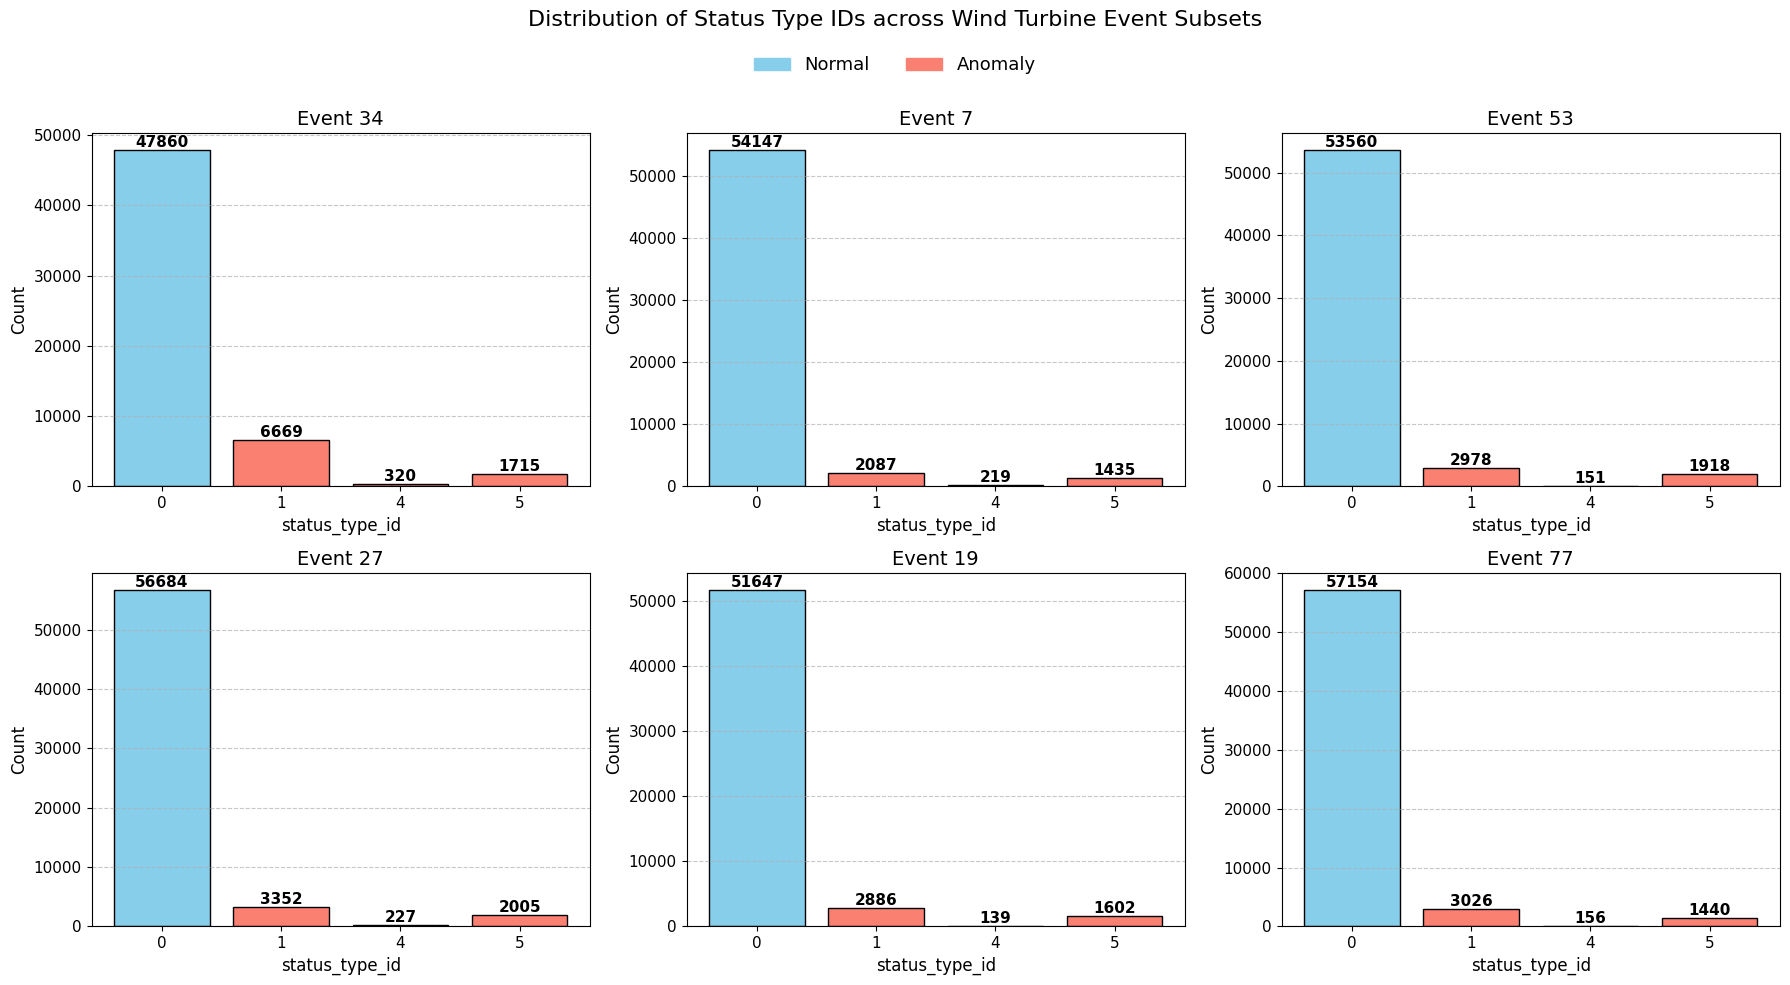

In [66]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (name, df) in zip(axes, datasets.items()):
    counts = df['status_type_id'].value_counts().sort_index()
    colors = ['skyblue' if x in [0, 2] else 'salmon' for x in counts.index]
    bars = ax.bar(counts.index.astype(str), counts.values, color=colors, edgecolor='black')

    ax.set_title(name, fontsize=14)
    ax.set_xlabel('status_type_id', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='both', labelsize=11)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1, str(int(height)),
                ha='center', va='bottom', fontsize=11, fontweight='bold')


fig.suptitle("Distribution of Status Type IDs across Wind Turbine Event Subsets",
             fontsize=16)

fig.legend(handles=[mpatches.Patch(color='skyblue', label='Normal'),
                    mpatches.Patch(color='salmon', label='Anomaly')],
           loc='upper center', ncol=2, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 0.95))

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


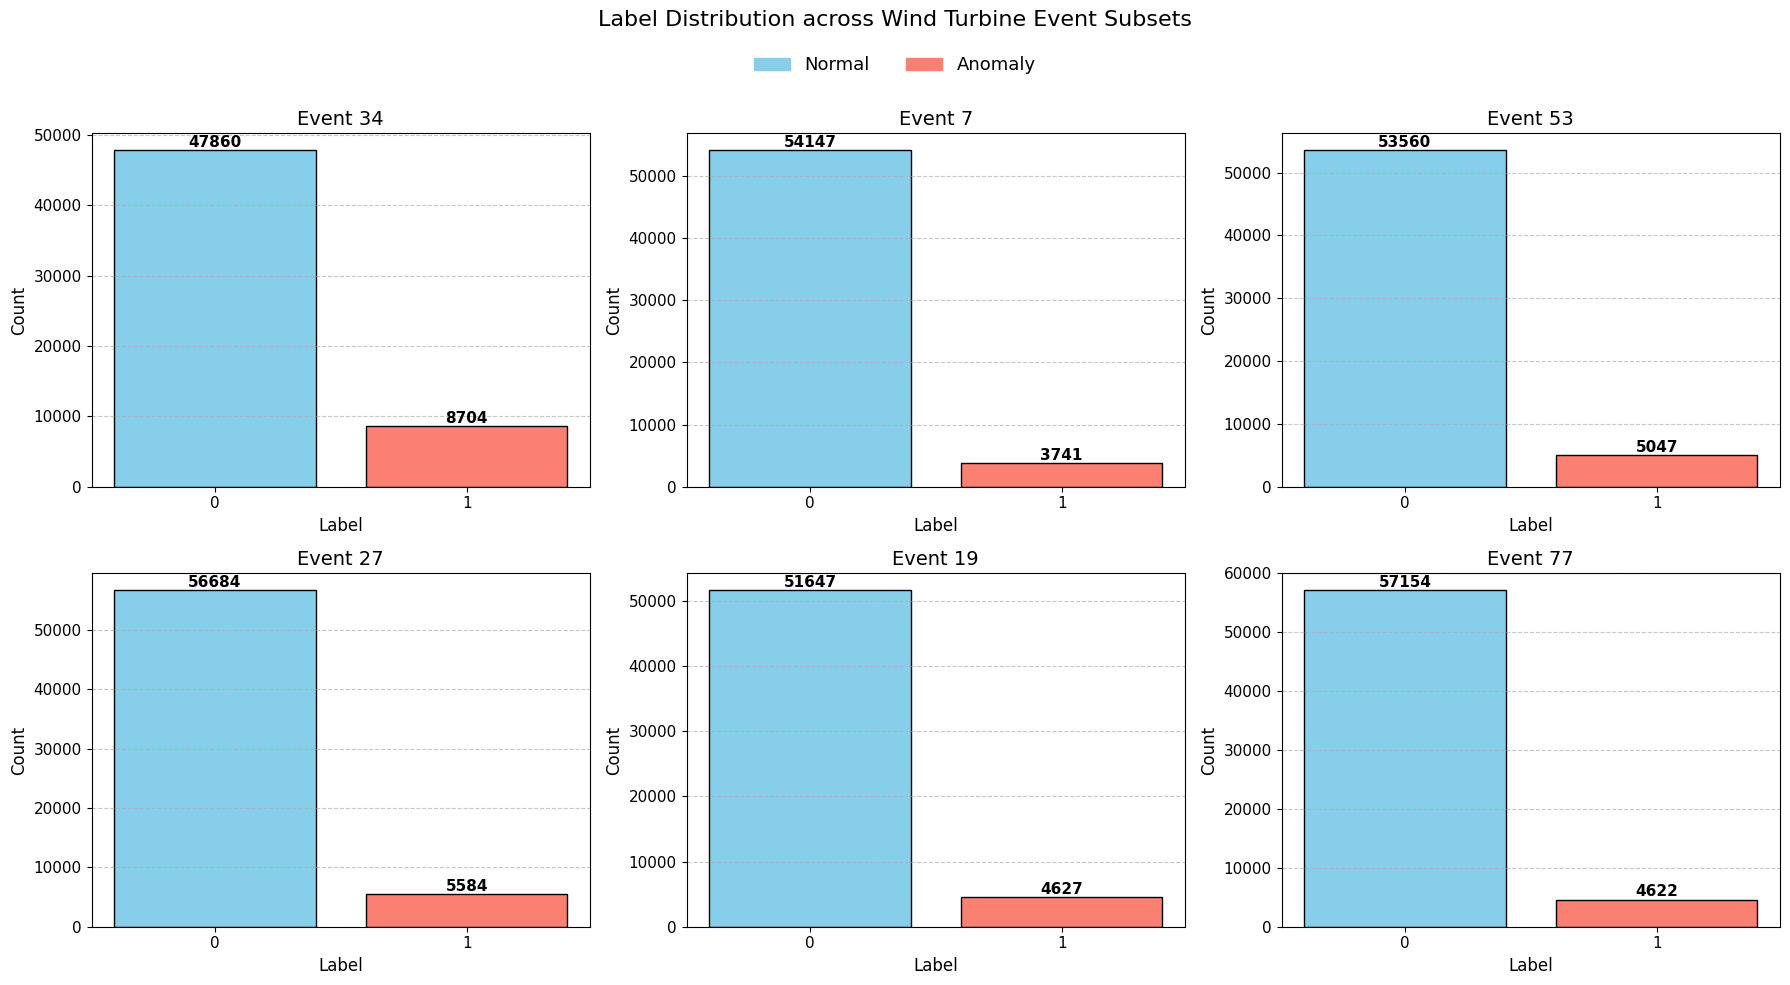

In [61]:
for name, df in datasets.items():
    df['label'] = df['status_type_id'].apply(lambda x: 0 if x in [0, 2] else 1)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (name, df) in zip(axes, datasets.items()):
    counts = df['label'].value_counts().reindex([0, 1], fill_value=0)
    colors = ['skyblue' if x == 0 else 'salmon' for x in counts.index]
    bars = ax.bar(counts.index, counts.values, color=colors, edgecolor='black')

    ax.set_title(name, fontsize=14)
    ax.set_xlabel('Label', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['0', '1'], fontsize=11)
    ax.tick_params(axis='y', labelsize=11)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1, str(int(height)),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

fig.suptitle("Label Distribution across Wind Turbine Event Subsets", fontsize=16)

fig.legend(handles=[mpatches.Patch(color='skyblue', label='Normal'),
                    mpatches.Patch(color='salmon', label='Anomaly')],
           loc='upper center', ncol=2, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 0.95))

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


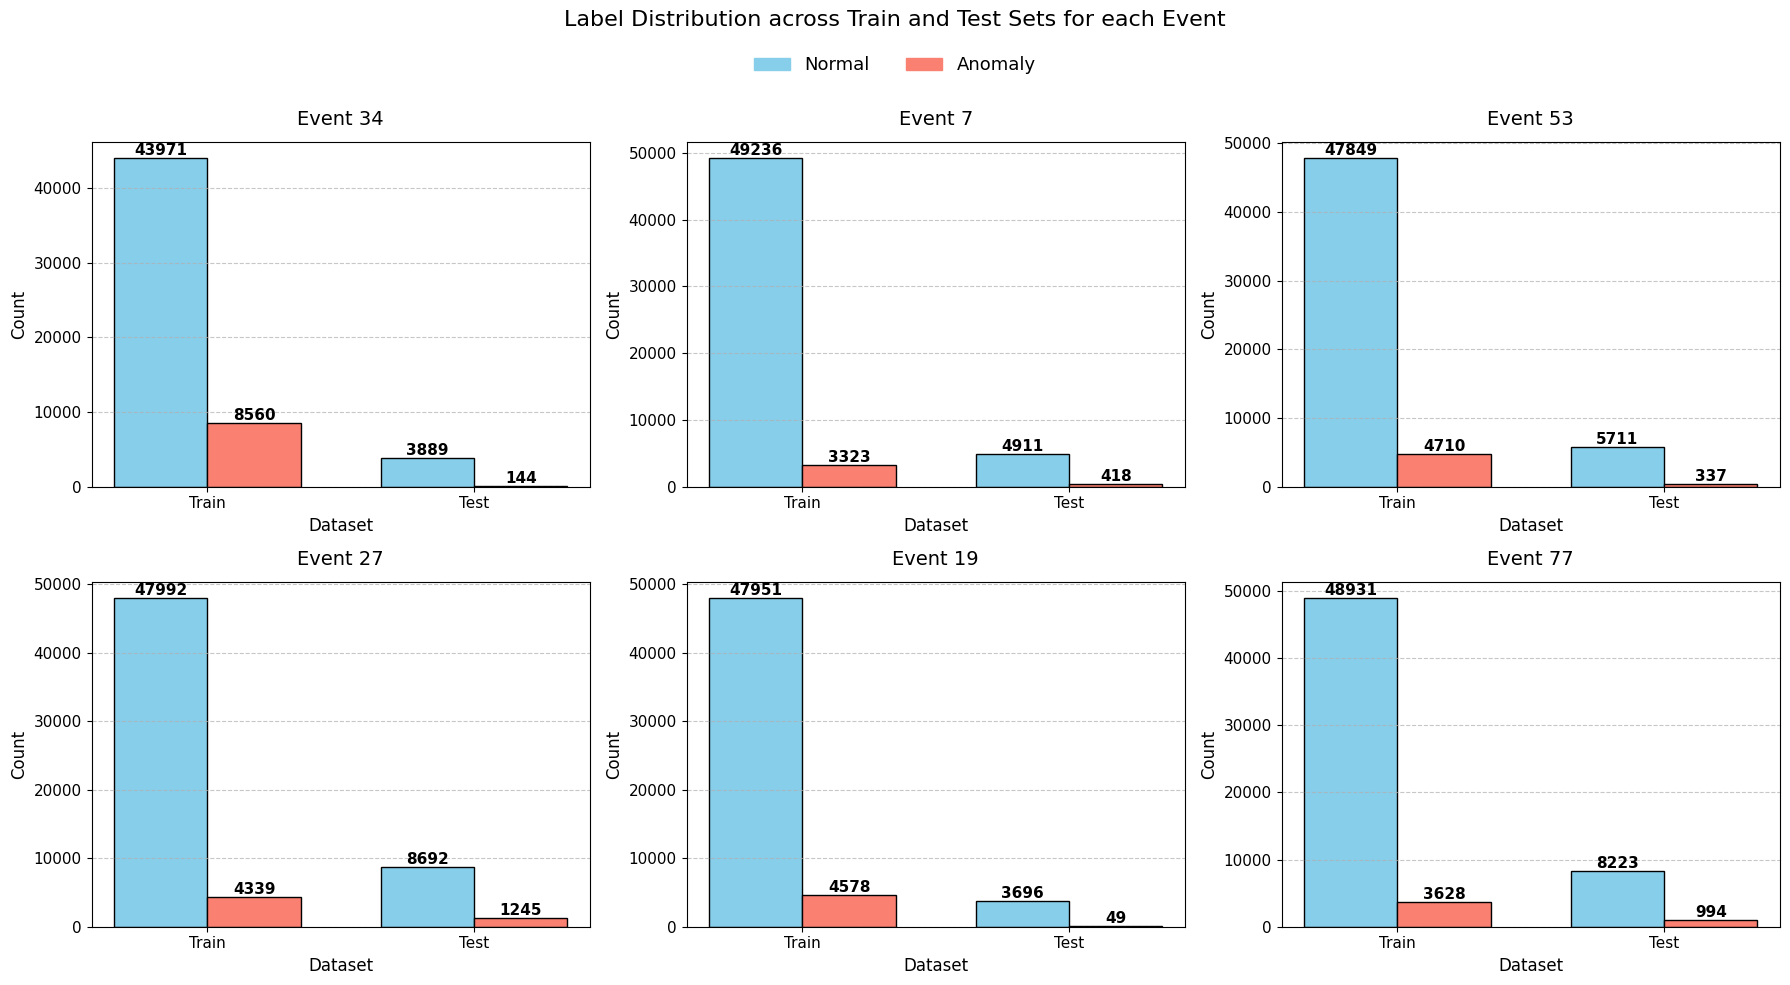

In [65]:
for name, df in datasets.items():
    df['label'] = df['status_type_id'].apply(lambda x: 0 if x in [0, 2] else 1)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (name, df) in zip(axes, datasets.items()):
    grouped = df.groupby(['train_test', 'label']).size().unstack(fill_value=0).reindex(['train', 'prediction'])
    x = np.arange(len(grouped.index))
    bar_width = 0.35

    ax.bar(x - bar_width/2, grouped[0], width=bar_width, color='skyblue', edgecolor='black', label='Normal')
    ax.bar(x + bar_width/2, grouped[1], width=bar_width, color='salmon', edgecolor='black', label='Anomaly')

    ax.set_xticks(x)
    ax.set_xticklabels(['Train', 'Test'], fontsize=11)
    ax.set_title(name, fontsize=14, pad=12)
    ax.set_xlabel('Dataset', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='y', labelsize=11)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    for i in range(len(x)):
        ax.text(x[i] - bar_width/2, grouped[0].iloc[i] + 1, str(grouped[0].iloc[i]),
                ha='center', va='bottom', fontsize=11, fontweight='bold')
        ax.text(x[i] + bar_width/2, grouped[1].iloc[i] + 1, str(grouped[1].iloc[i]),
                ha='center', va='bottom', fontsize=11, fontweight='bold')


fig.suptitle("Label Distribution across Train and Test Sets for each Event", fontsize=16)

fig.legend(handles=[mpatches.Patch(color='skyblue', label='Normal'),
                    mpatches.Patch(color='salmon', label='Anomaly')],
           loc='upper center', ncol=2, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 0.95))

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


###**Are there any missing or duplicate data?**

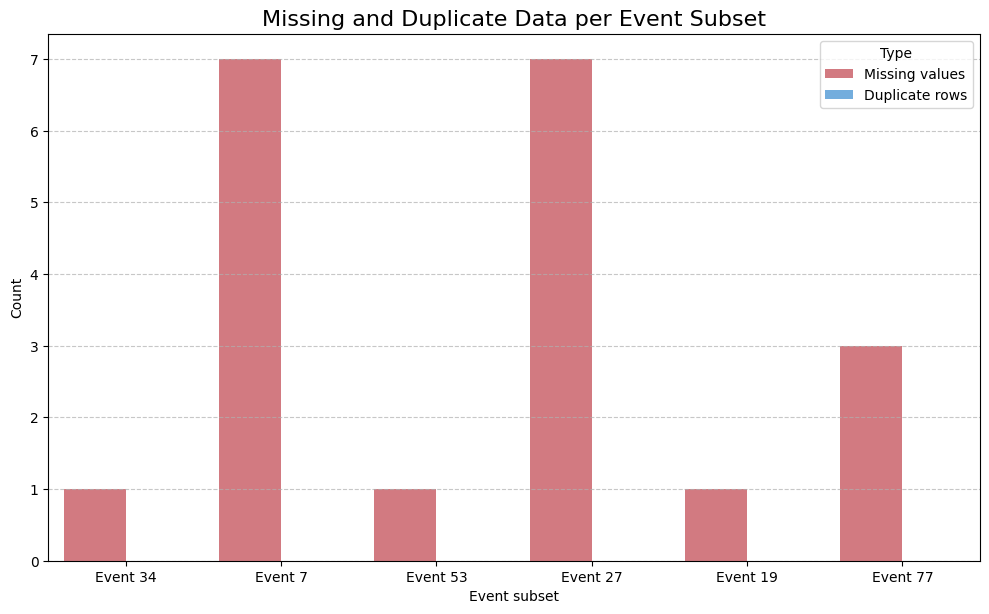

In [36]:
stats = []

for name, df in datasets.items():
    num_missing = df.isnull().sum().sum()
    num_duplicates = df.duplicated().sum()
    stats.append({'Event': name, 'Missing values': num_missing, 'Duplicate rows': num_duplicates})

stats_df = pd.DataFrame(stats)

stats_melted = stats_df.melt(id_vars='Event', var_name='Type', value_name='Count')
plt.figure(figsize=(10, 6))
sns.barplot(data=stats_melted, x='Event', y='Count', hue='Type', palette=['#E06C75', '#61AFEF'])

plt.xlabel('Event subset')
plt.ylabel('Count')
# plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Type')
plt.tight_layout()
plt.title('Missing and Duplicate Data per Event Subset', fontsize=16)

#plt.savefig('missing_and_duplicate_values.png', dpi=300, bbox_inches='tight')
plt.show()


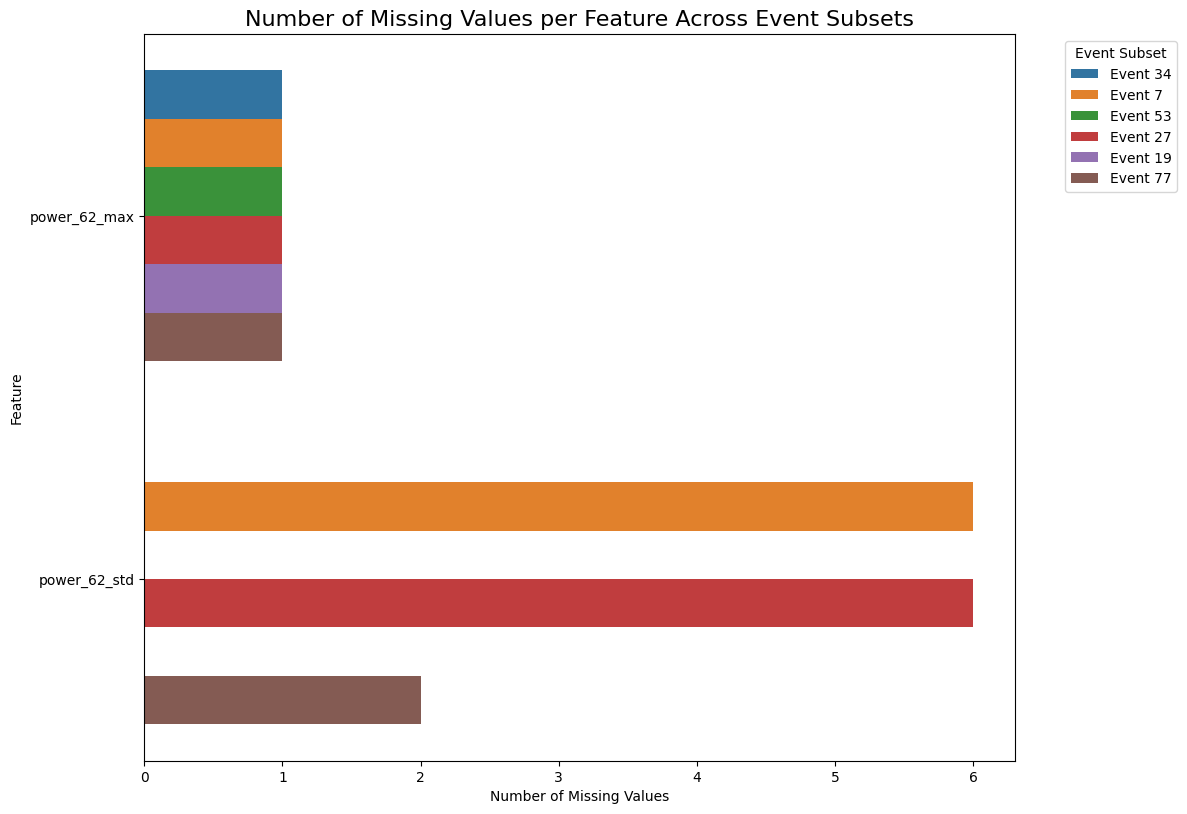

In [43]:
missing_features = []

for name, df in datasets.items():
    missing_count = df.isnull().sum()
    missing_count = missing_count[missing_count > 0]
    for feature, count in missing_count.items():
        missing_features.append({'Event': name, 'Feature': feature, 'Missing Count': count})

missing_df = pd.DataFrame(missing_features)

if not missing_df.empty:
    plt.figure(figsize=(12, 8))
    sns.barplot(data=missing_df, y='Feature', x='Missing Count', hue='Event', dodge=True)


    plt.xlabel('Number of Missing Values')
    plt.ylabel('Feature')
    plt.legend(title='Event Subset', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    #plt.savefig('missing_values_per_feature.png', dpi=300, bbox_inches='tight')
    plt.title('Number of Missing Values per Feature Across Event Subsets', fontsize=16)
    plt.show()
else:
    print("No missing values in any subset.")


###**Which sensor features contribute the most to distinguishing normal and anomalous wind turbine behavior?**

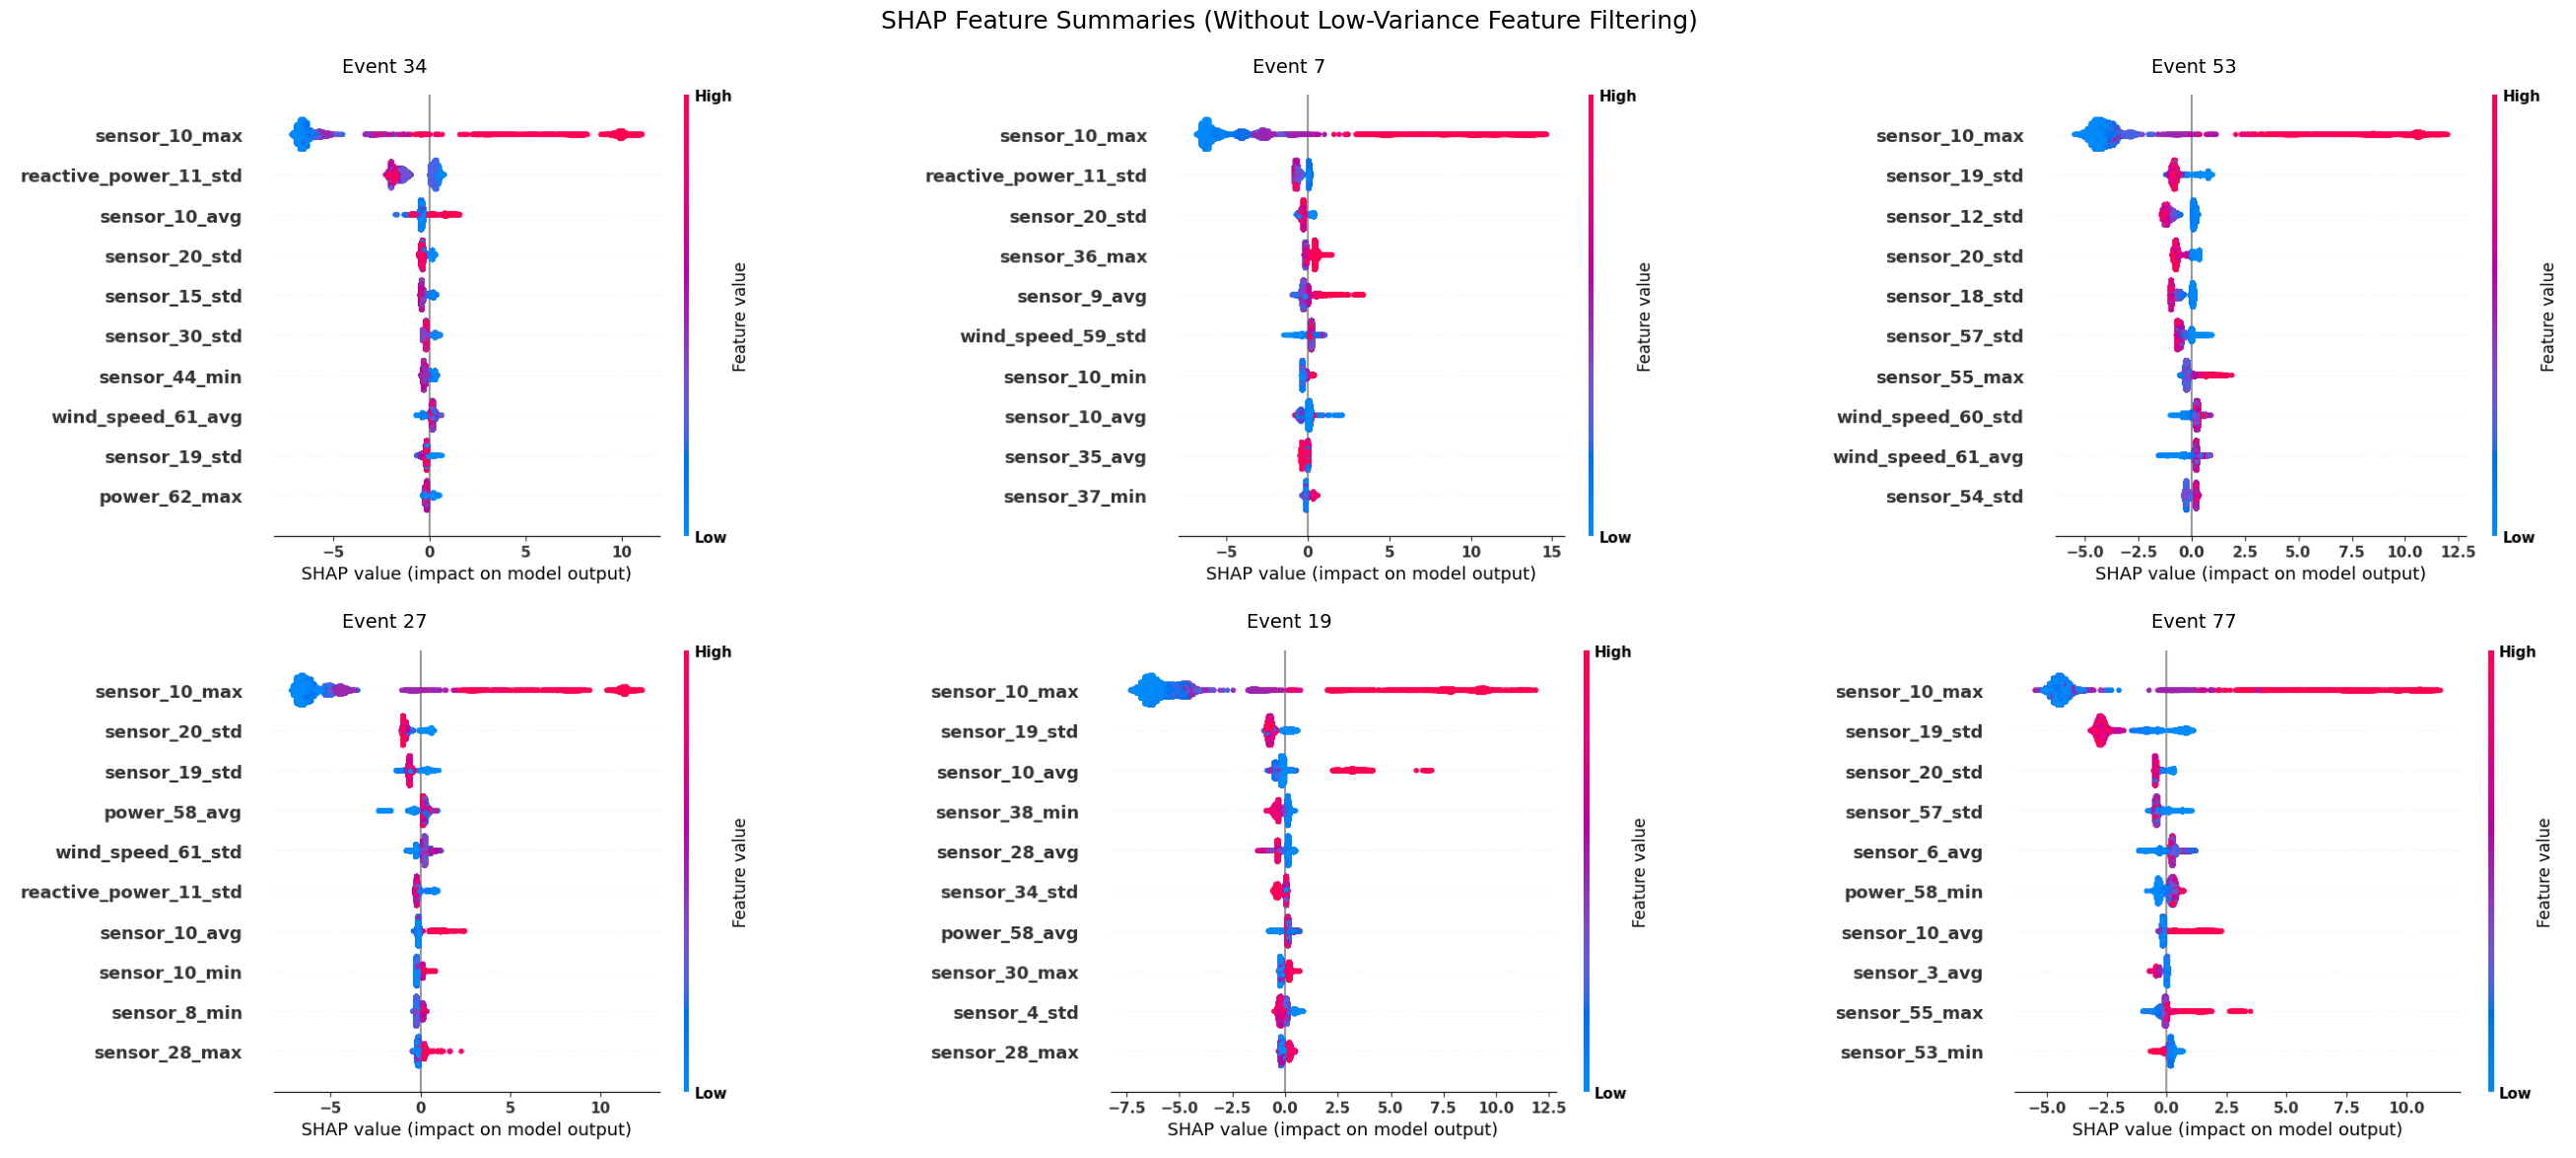

In [20]:
top_features_lists_no_filter = []
shap_values_dict = {}
features_dict = {}

fig1, axes1 = plt.subplots(2, 3, figsize=(28, 12))
axes1 = axes1.flatten()
plt.rcParams.update({
    'font.size': 14,
    'font.weight': 'bold'
})

for i, (name, df) in enumerate(datasets.items()):

    features = df.drop(columns=['train_test', 'status_type_id', 'asset_id', 'time_stamp', 'id'], errors='ignore')


    if 'label' not in features.columns:
        features['label'] = df['status_type_id'].apply(lambda x: 0 if x in [0, 2] else 1)
    labels = features['label']
    features = features.drop(columns=['label'])


    model = xgb.XGBClassifier(objective="binary:logistic", eval_metric='logloss')
    model.fit(features, labels)


    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(features)

    shap_values_dict[name] = shap_values
    features_dict[name] = features


    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    top_indices = np.argsort(mean_abs_shap)[-10:][::-1]
    top_features = features.columns[top_indices].tolist()
    top_features_lists_no_filter.append(top_features)


    buf = io.BytesIO()
    plt.figure(figsize=(12, 6))
    shap.summary_plot(shap_values, features, show=False, max_display=10)
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close()
    buf.seek(0)
    img = Image.open(buf)
    axes1[i].imshow(img)
    axes1[i].axis('off')
    axes1[i].set_title(name, fontsize=14)

fig1.suptitle('SHAP Feature Summaries (Without Low-Variance Feature Filtering)', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
#plt.savefig('shap_summary_pre_variance_filter.png', dpi=300, bbox_inches='tight')
plt.show()


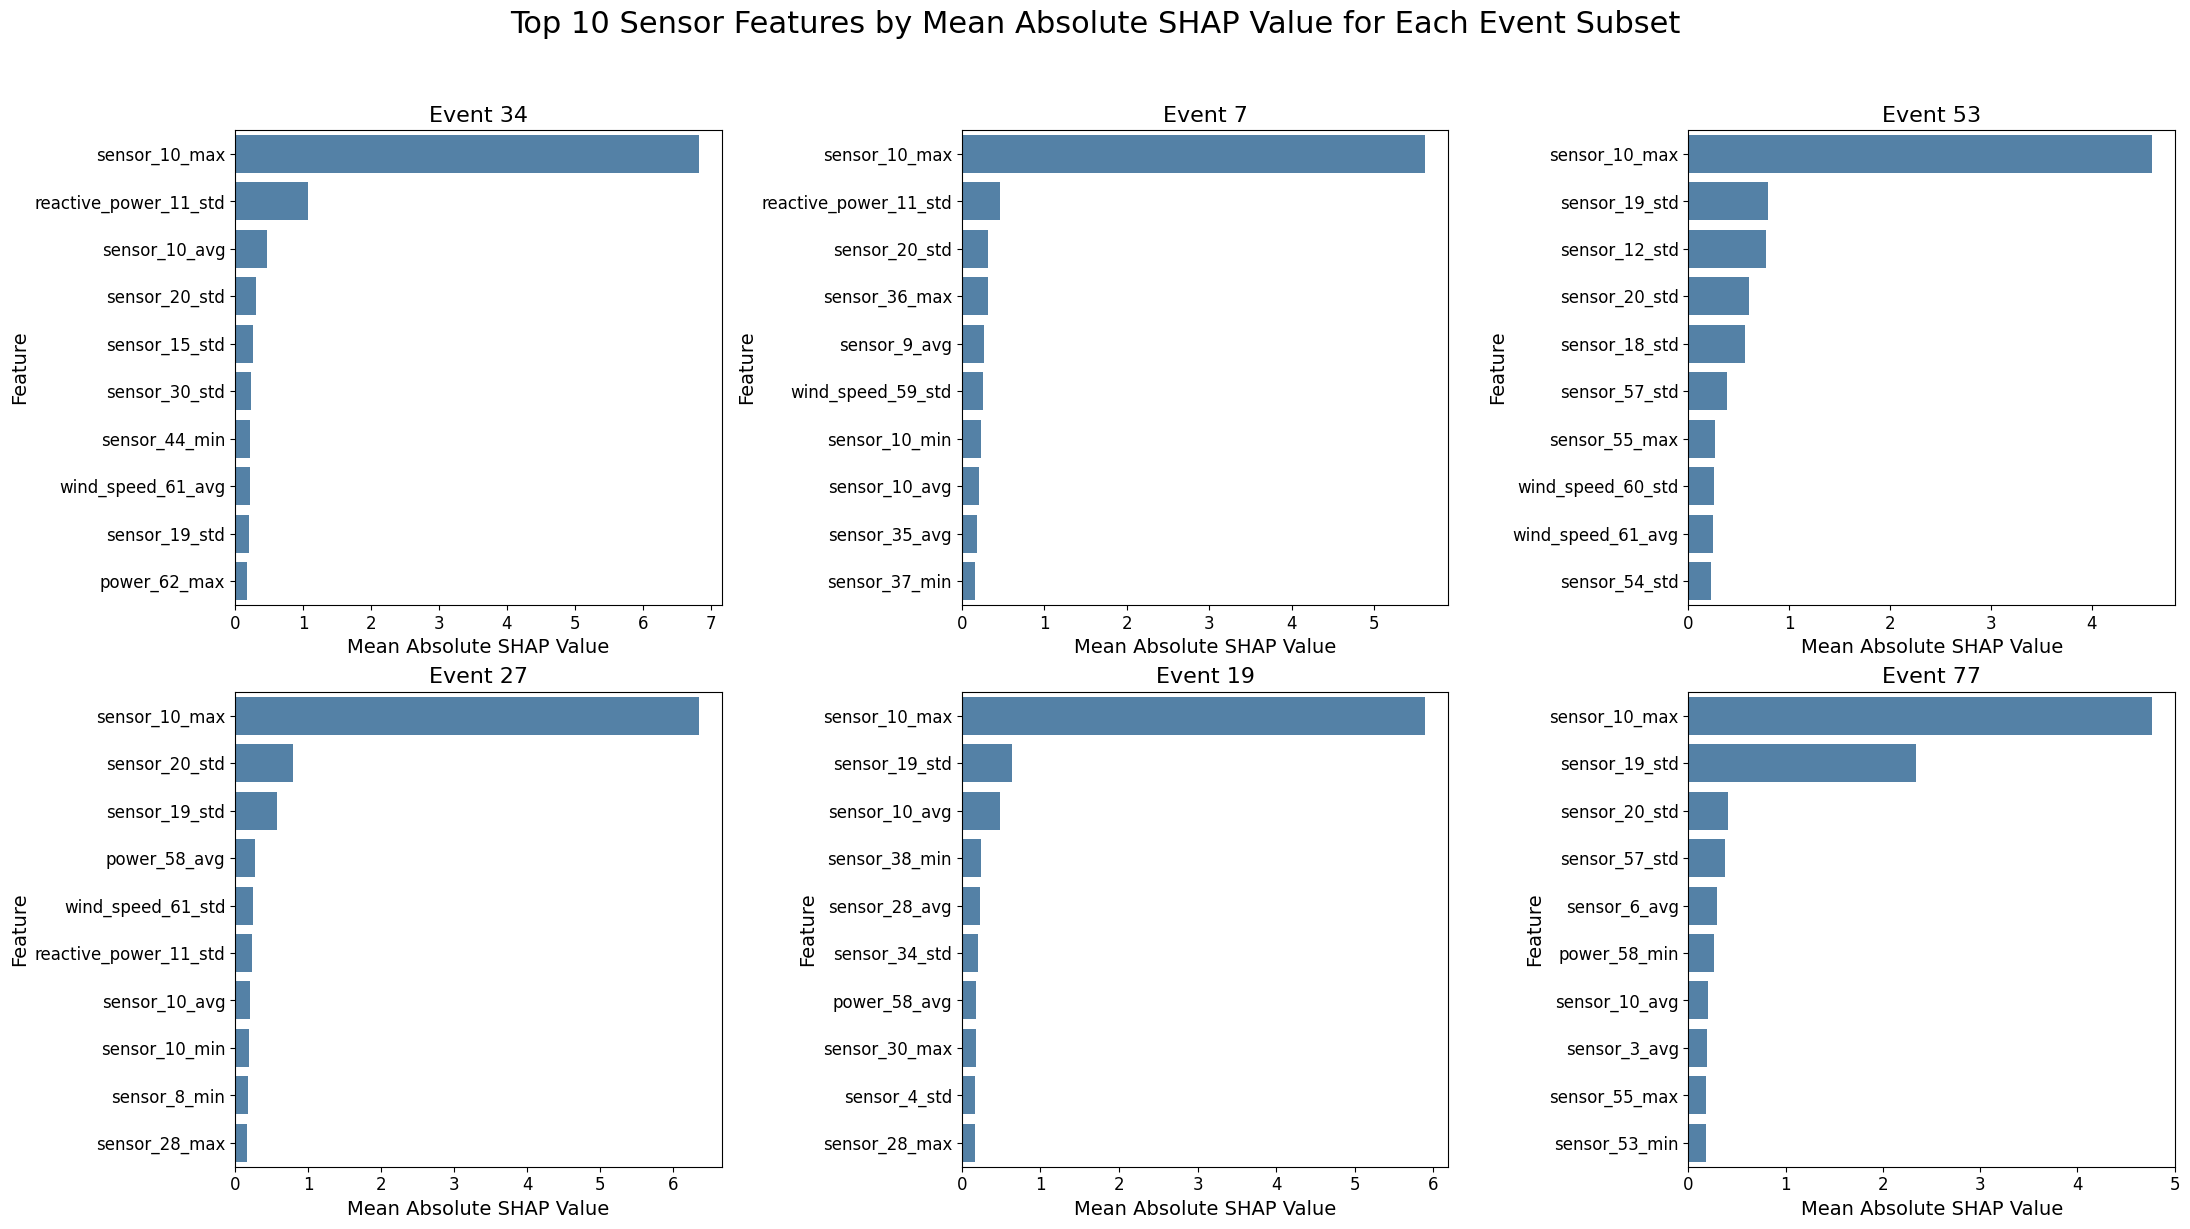

In [47]:
plt.rcParams.update(plt.rcParamsDefault)
fig2, axes2 = plt.subplots(2, 3, figsize=(22, 12))
axes2 = axes2.flatten()

for i, (name, shap_values) in enumerate(shap_values_dict.items()):
    features = features_dict[name]


    shap_importance = pd.DataFrame({
        'feature': features.columns,
        'mean_abs_shap': np.abs(shap_values).mean(axis=0)
    }).sort_values(by='mean_abs_shap', ascending=False)

    top_10 = shap_importance.head(10)

    ax = axes2[i]
    sns.barplot(
        y=top_10['feature'],
        x=top_10['mean_abs_shap'],
        color='steelblue',
        ax=ax
    )


    ax.set_xlabel("Mean Absolute SHAP Value", fontsize=14)
    ax.set_ylabel("Feature", fontsize=14)
    ax.set_title(name, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
fig2.suptitle(
    "Top 10 Sensor Features by Mean Absolute SHAP Value for Each Event Subset",
    fontsize=22,
    y=1.02
)

#plt.savefig('shap_barplots_pre_variance_filter.png', dpi=300, bbox_inches='tight')
plt.show()


In [22]:
plt.rcParams.update(plt.rcParamsDefault)

for name, shap_values in shap_values_dict.items():
    features = features_dict[name]

    shap_importance = pd.DataFrame({
        'feature': features.columns,
        'mean_abs_shap': np.abs(shap_values).mean(axis=0)
    }).sort_values(by='mean_abs_shap', ascending=False)

    top_5_features = shap_importance.head(5)['feature'].values

    event_df = datasets[name].copy()
    event_df['time_stamp'] = pd.to_datetime(event_df['time_stamp'])

    normal = event_df[event_df['label'] == 0]
    anomaly = event_df[event_df['label'] == 1]

    fig, axes = plt.subplots(5, 1, figsize=(18, 20), sharex=True)
    fig.suptitle(f"Top 5 Features (Without Low-Variance Feature Filtering) – {name}", fontsize=20)

    for i, feature in enumerate(top_5_features):
        ax = axes[i]
        ax.plot(event_df['time_stamp'], event_df[feature], label='Normal', color='blue')
        ax.scatter(anomaly['time_stamp'], anomaly[feature], color='red', label='Anomaly', s=10, zorder=5)

        ax.set_title(f"{feature} Over Time", fontsize=14)
        ax.set_ylabel("Value")
        ax.grid(True)


    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=2, fontsize=12, frameon=False)

    plt.xlabel("Time")
    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    # plt.savefig(f"top5_features_timeseries_{name}.png", dpi=300, bbox_inches="tight")
    plt.show()
    print()


Output hidden; open in https://colab.research.google.com to view.

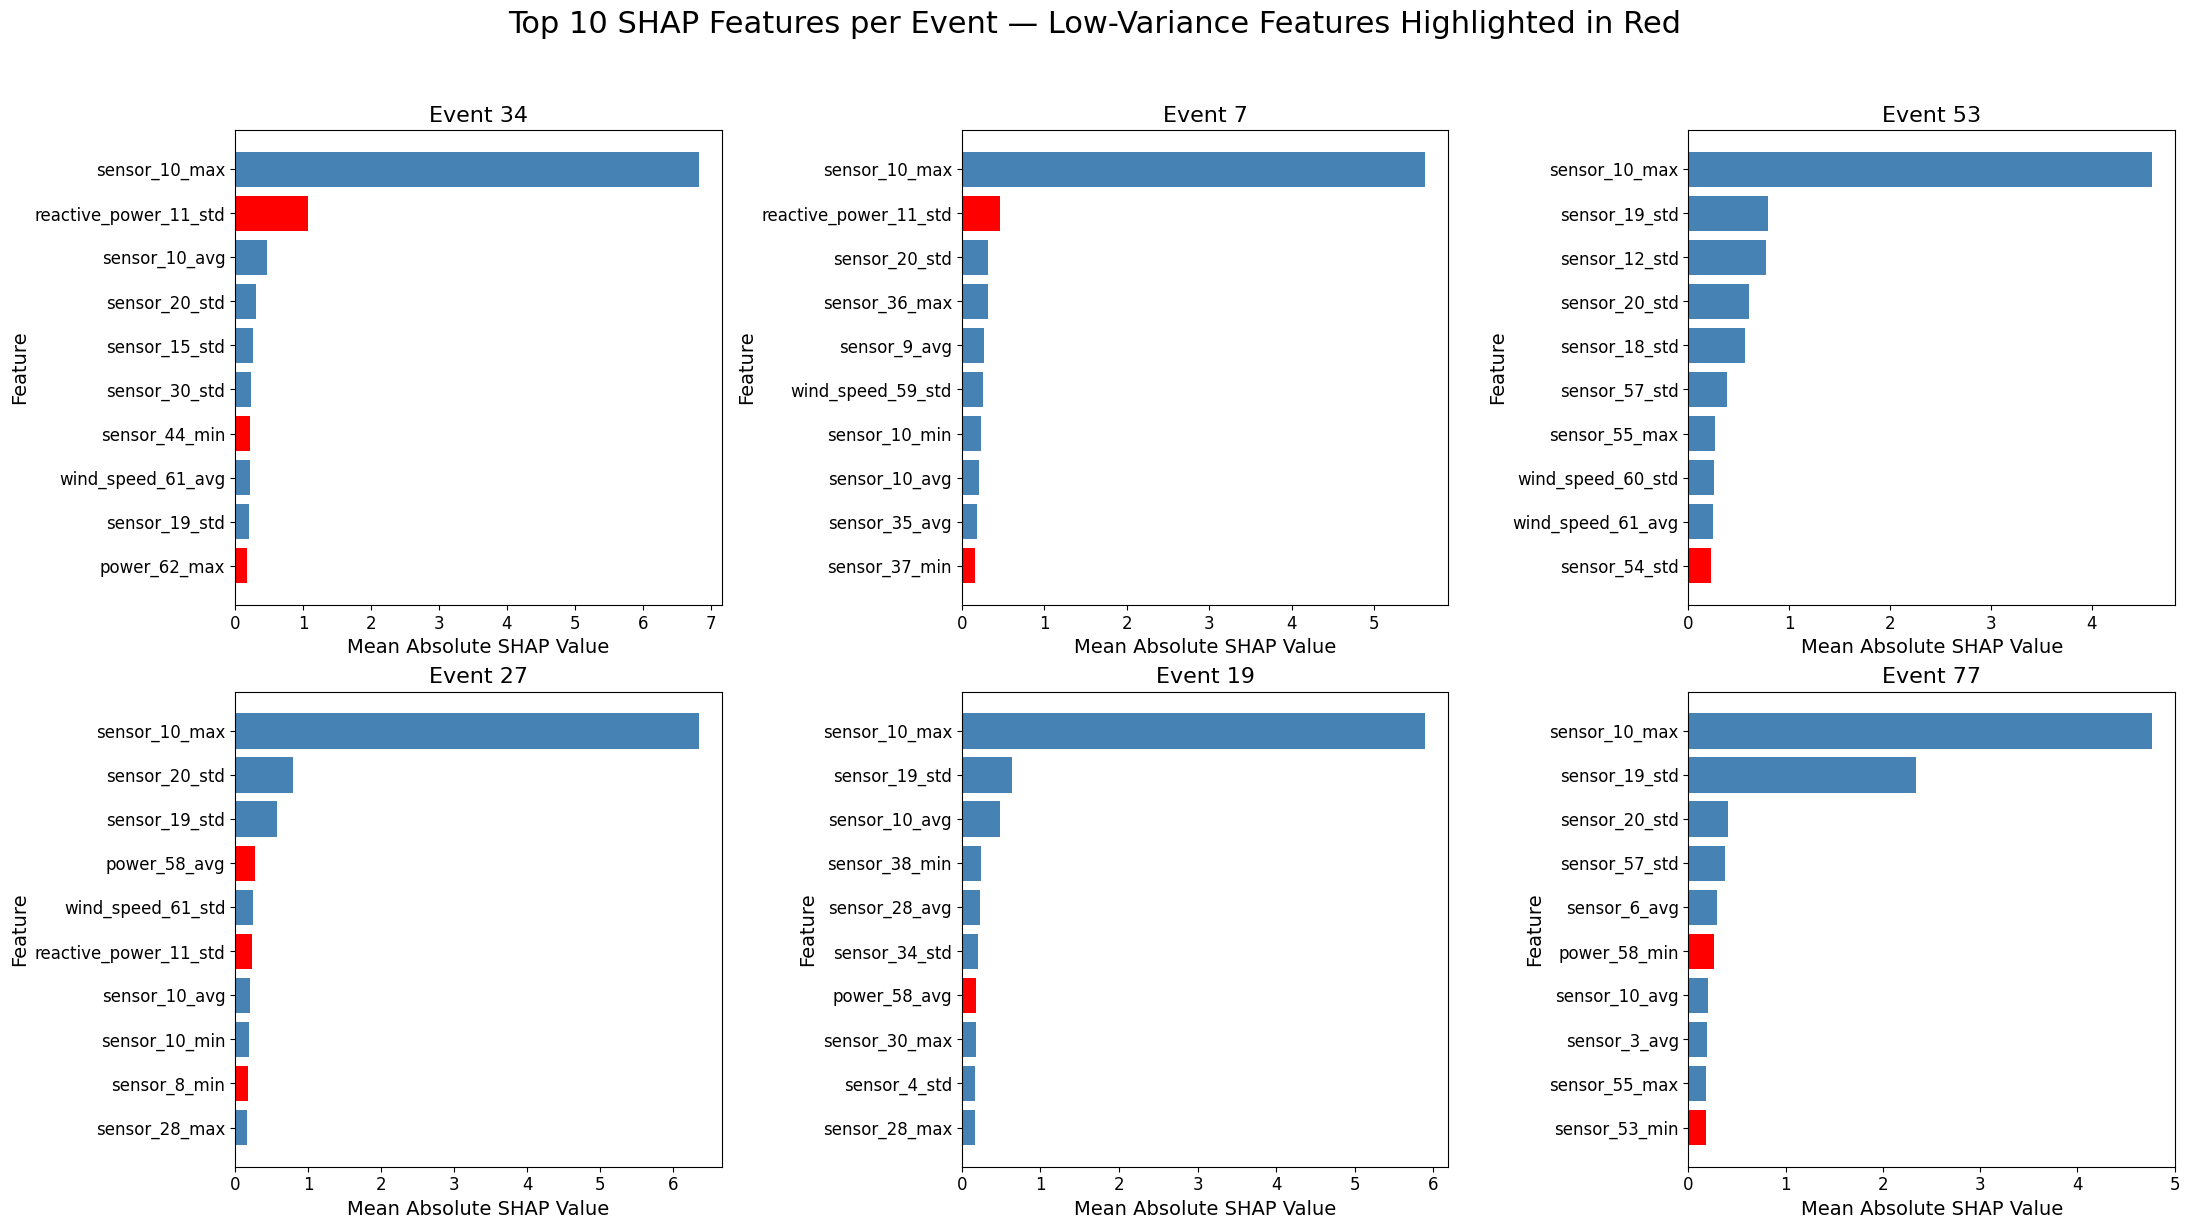

In [48]:
plt.rcParams.update(plt.rcParamsDefault)
fig2, axes2 = plt.subplots(2, 3, figsize=(22, 12))
axes2 = axes2.flatten()
variance_threshold = 0.2

for i, (name, shap_values) in enumerate(shap_values_dict.items()):
    features = features_dict[name]
    selector = VarianceThreshold(threshold=variance_threshold)
    selector.fit(features)
    low_variance_features = features.columns[~selector.get_support()]


    shap_importance = pd.DataFrame({
        'feature': features.columns,
        'mean_abs_shap': np.abs(shap_values).mean(axis=0)
    }).sort_values(by='mean_abs_shap', ascending=False)

    top_10 = shap_importance.head(10)
    ax = axes2[i]

    y_positions = range(len(top_10)-1, -1, -1)


    for j, (feature, value) in enumerate(zip(top_10['feature'], top_10['mean_abs_shap'])):
        color = 'red' if feature in low_variance_features else 'steelblue'
        ax.barh(y_positions[j], value, color=color)

    ax.set_yticks(y_positions)
    ax.set_yticklabels(top_10['feature'])

    ax.set_xlabel("Mean Absolute SHAP Value", fontsize=14)
    ax.set_ylabel("Feature", fontsize=14)
    ax.set_title(name, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('shap_barplots_with_variance_highlighted.png', dpi=300, bbox_inches='tight')

fig2.suptitle(
    "Top 10 SHAP Features per Event — Low-Variance Features Highlighted in Red",
    fontsize=22,
    y=1.02
)
plt.show()


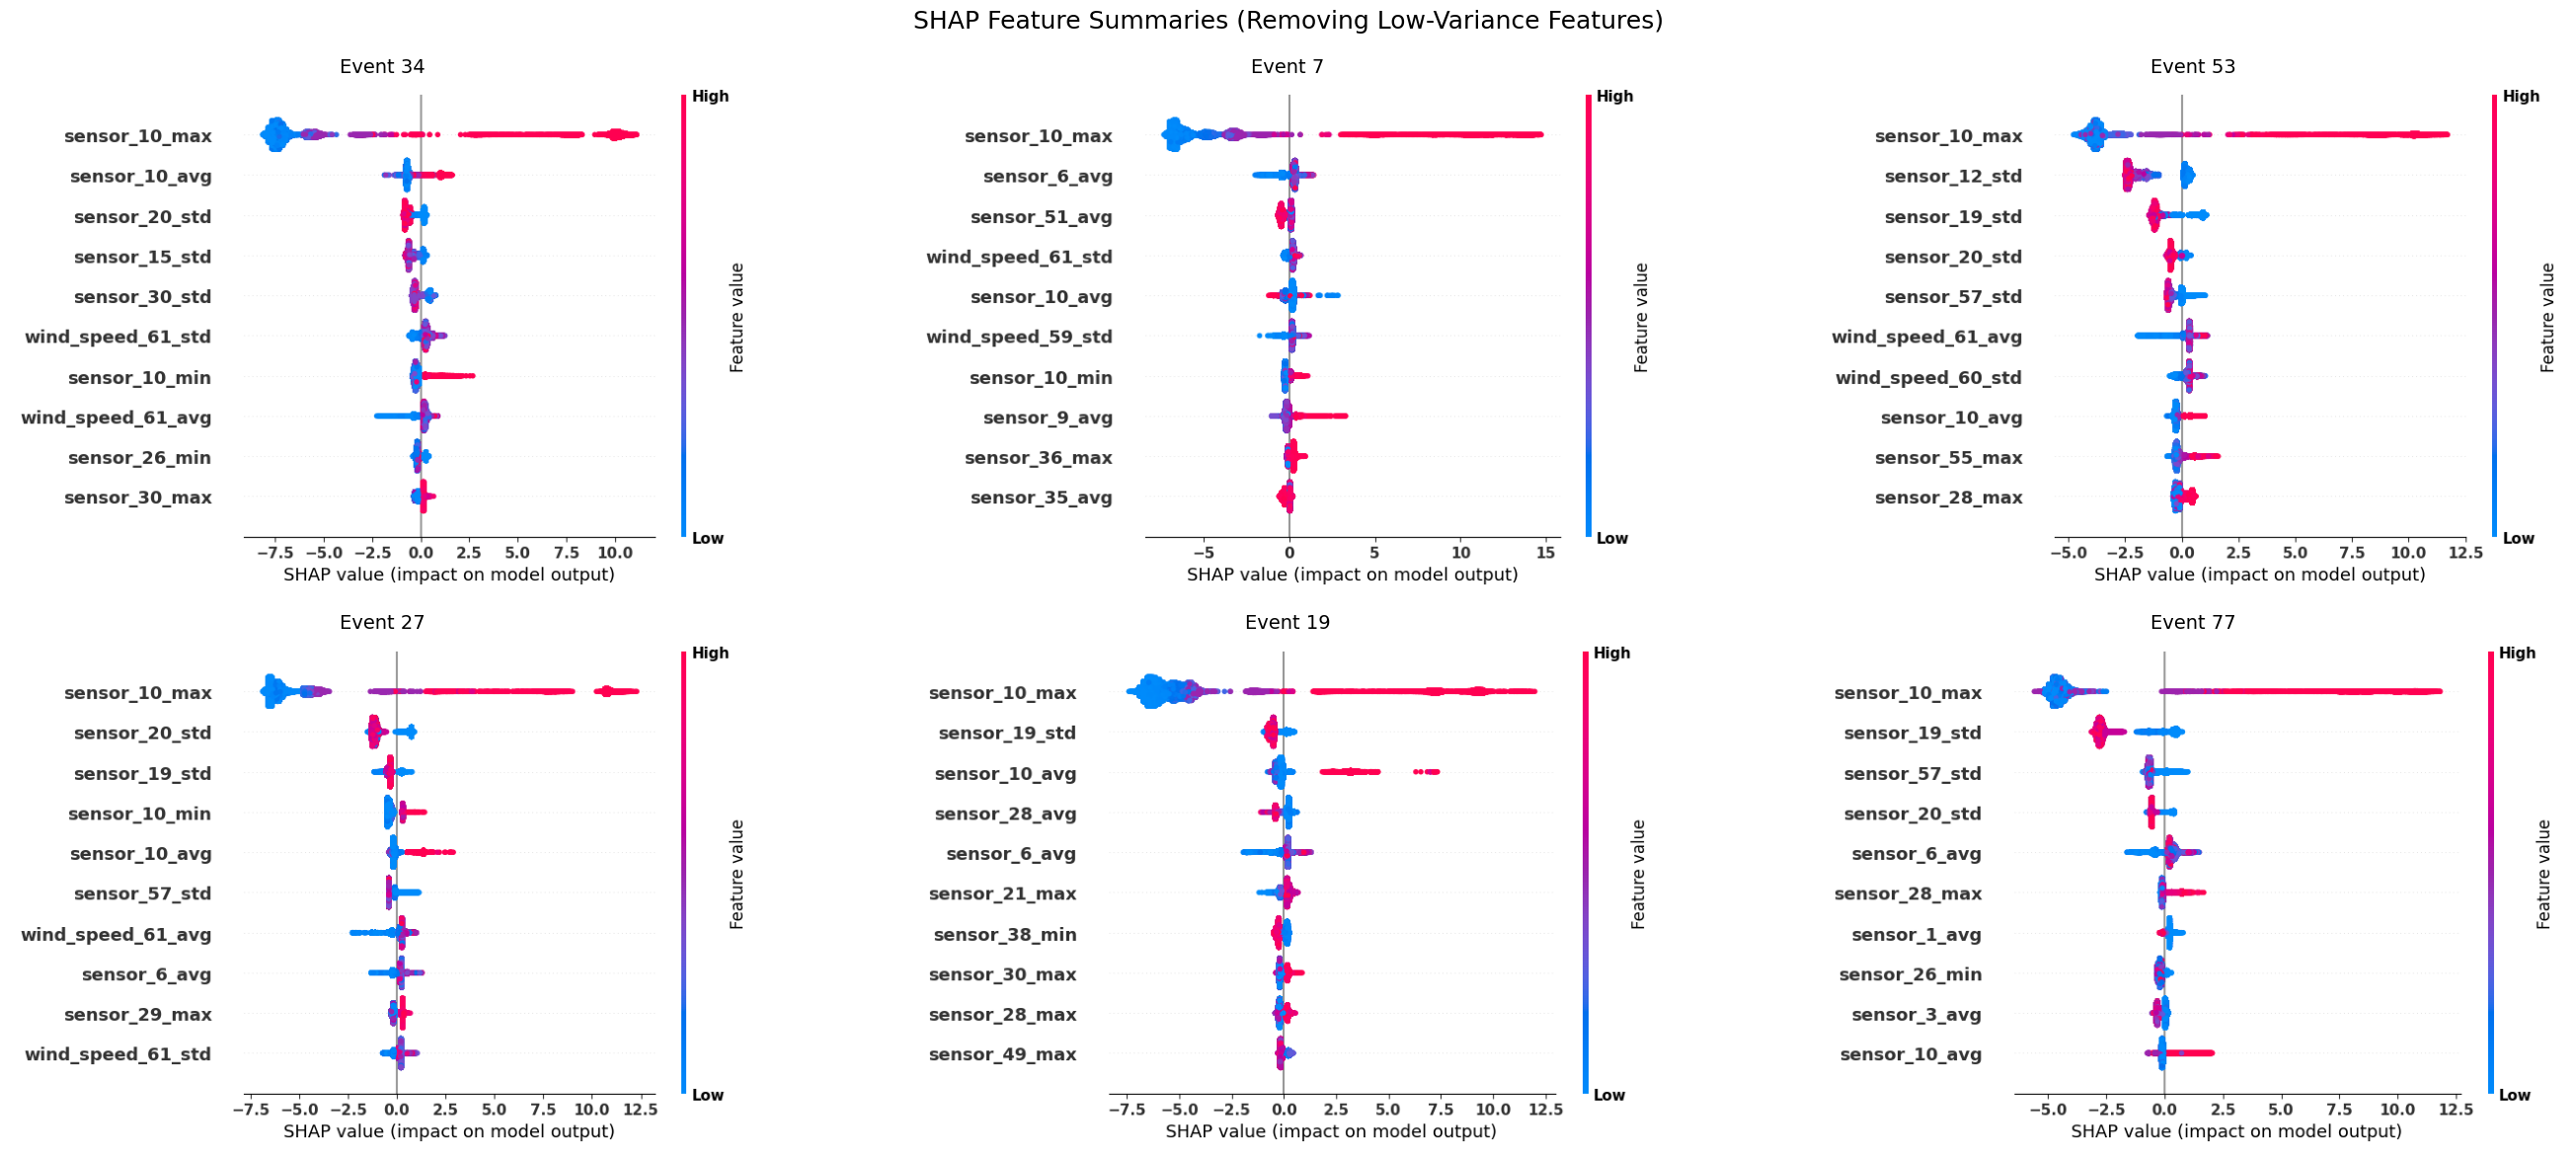

In [24]:
top_features_lists_filter = []
shap_values_dict_filter = {}
features_dict_filter = {}

variance_threshold = 0.2

fig1, axes1 = plt.subplots(2, 3, figsize=(28, 12))
axes1 = axes1.flatten()

plt.rcParams.update({
    'font.size': 14,
    'font.weight': 'bold'
})

for i, (name, df) in enumerate(datasets.items()):

    features = df.drop(columns=['train_test', 'status_type_id', 'asset_id', 'time_stamp', 'id'], errors='ignore')

    if 'label' not in features.columns:
        features['label'] = df['status_type_id'].apply(lambda x: 0 if x in [0, 2] else 1)
    labels = features['label']
    features = features.drop(columns=['label'])

    selector = VarianceThreshold(threshold=variance_threshold)
    features_filtered = selector.fit_transform(features)
    selected_features = features.columns[selector.get_support()]

    model = xgb.XGBClassifier(objective="binary:logistic", eval_metric='logloss')
    model.fit(features[selected_features], labels)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(features[selected_features])
    shap_values_dict_filter[name] = shap_values
    features_dict_filter[name] = features[selected_features]

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    top_indices = np.argsort(mean_abs_shap)[-10:][::-1]
    top_features = selected_features[top_indices].tolist()
    top_features_lists_filter.append(top_features)

    buf = io.BytesIO()
    plt.figure(figsize=(12, 6))
    shap.summary_plot(shap_values, features[selected_features], show=False, max_display=10)
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close()
    buf.seek(0)
    img = Image.open(buf)
    axes1[i].imshow(img)
    axes1[i].axis('off')
    axes1[i].set_title(name, fontsize=14)

fig1.suptitle('SHAP Feature Summaries (Removing Low-Variance Features)', fontsize=18)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
#plt.savefig('shap_summary_with_variance_threshold.png', dpi=300, bbox_inches='tight')
plt.show()


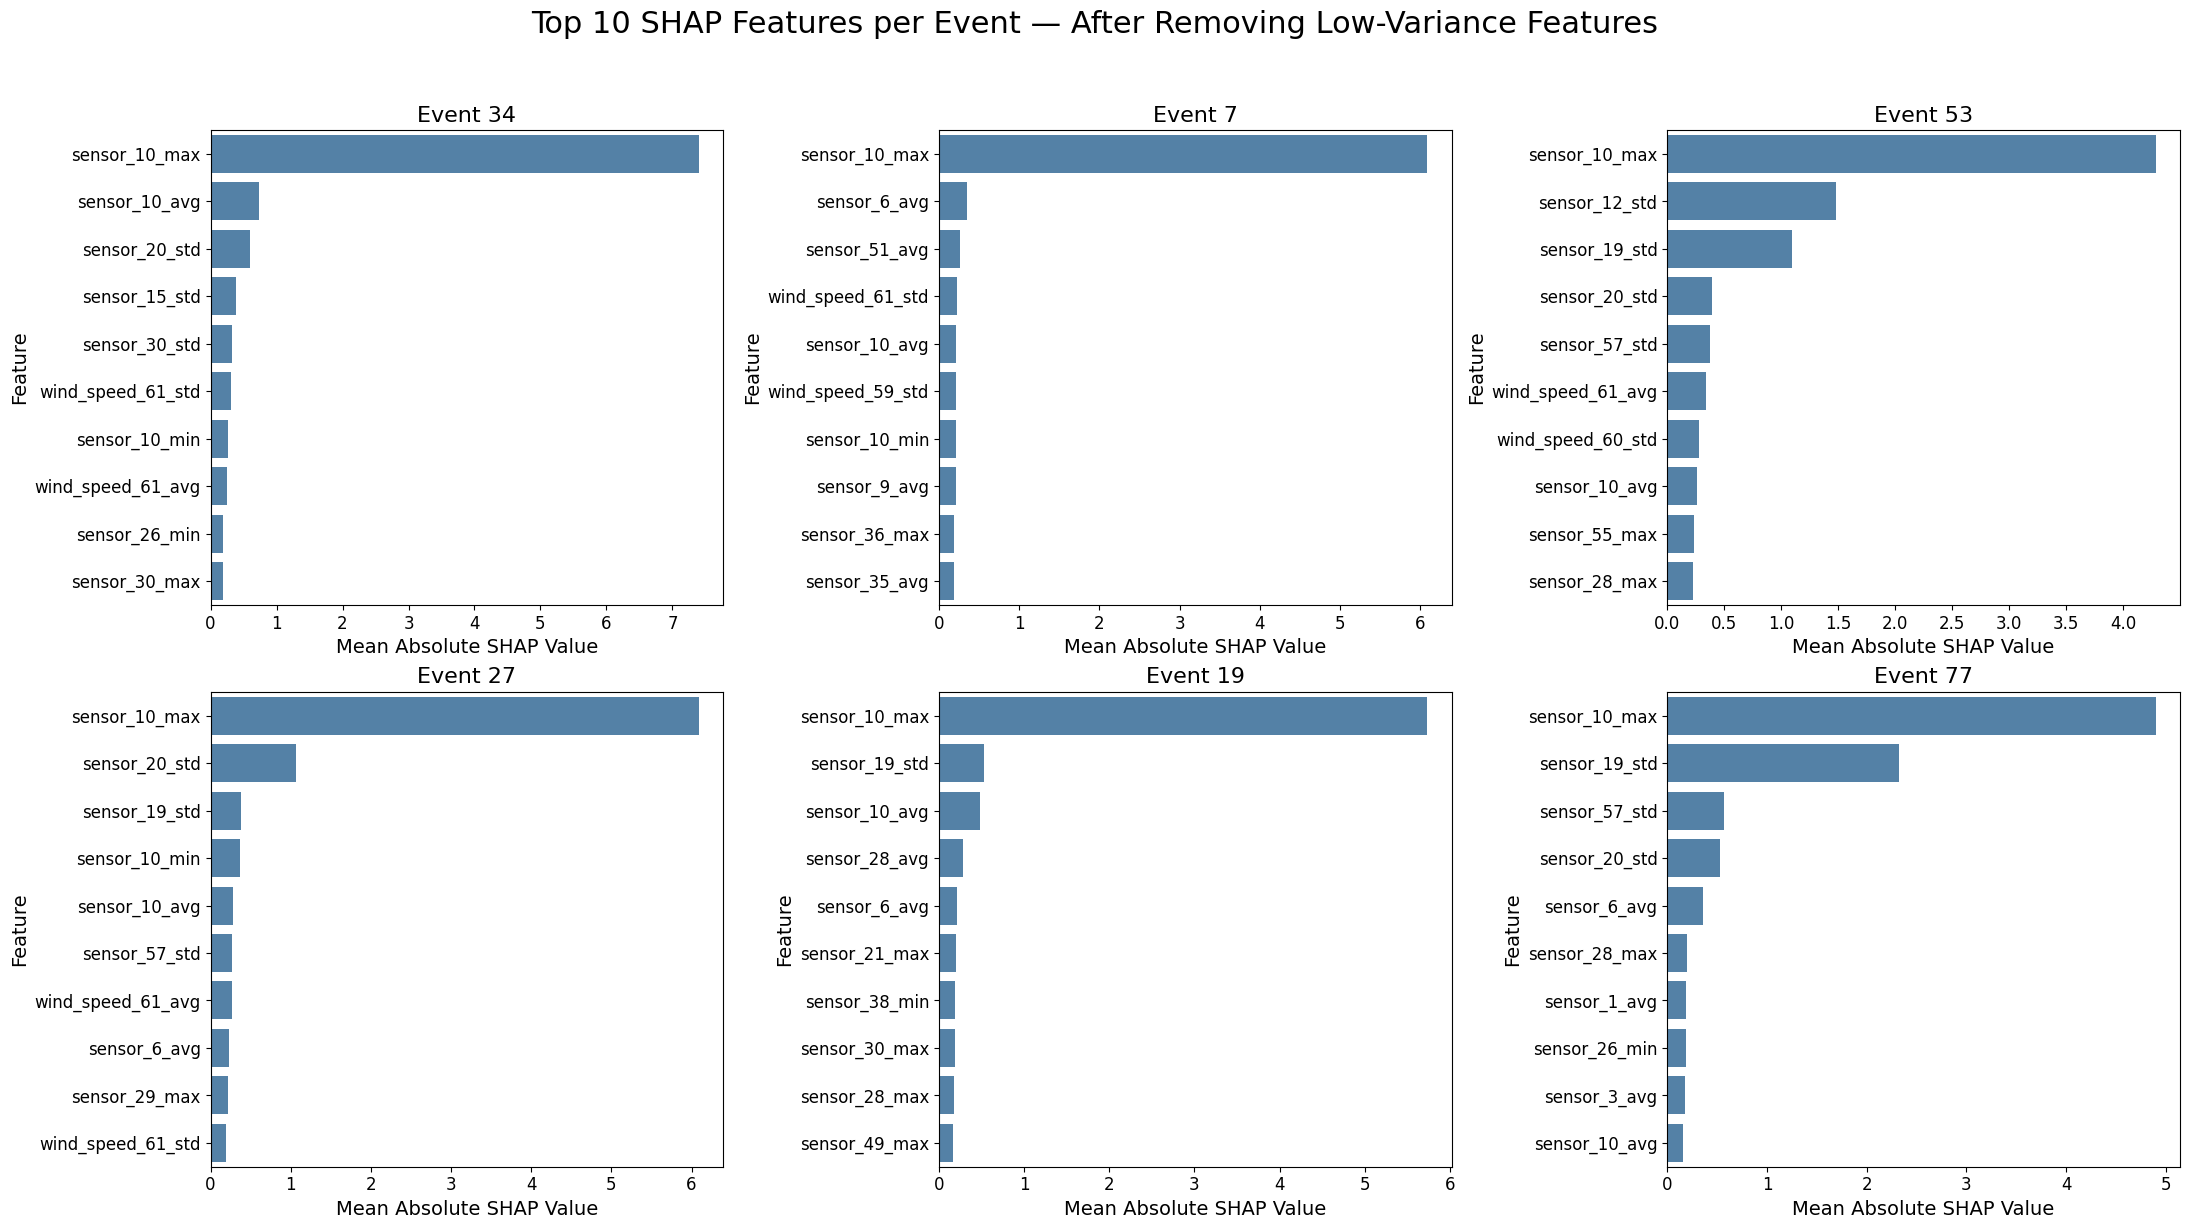

In [50]:
plt.rcParams.update(plt.rcParamsDefault)
fig3, axes3 = plt.subplots(2, 3, figsize=(22, 12))
axes3 = axes3.flatten()

for i, (name, shap_values) in enumerate(shap_values_dict_filter.items()):
    features = features_dict_filter[name]

    shap_importance = pd.DataFrame({
        'feature': features.columns,
        'mean_abs_shap': np.abs(shap_values).mean(axis=0)
    }).sort_values(by='mean_abs_shap', ascending=False)

    top_10 = shap_importance.head(10)
    ax = axes3[i]

    sns.barplot(
        y=top_10['feature'],
        x=top_10['mean_abs_shap'],
        color='steelblue',
        ax=ax
    )


    ax.set_xlabel("Mean Absolute SHAP Value", fontsize=14)
    ax.set_ylabel("Feature", fontsize=14)
    ax.set_title(name, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
#plt.savefig('shap_barplots_with_variance_filter.png', dpi=300, bbox_inches='tight')
fig3.suptitle(
    "Top 10 SHAP Features per Event — After Removing Low-Variance Features",
    fontsize=22,
    y=1.02
)

plt.show()


In [26]:
plt.rcParams.update(plt.rcParamsDefault)

for name, shap_values in shap_values_dict_filter.items():
    features = features_dict_filter[name]

    shap_importance = pd.DataFrame({
        'feature': features.columns,
        'mean_abs_shap': np.abs(shap_values).mean(axis=0)
    }).sort_values(by='mean_abs_shap', ascending=False)

    top_5_features = shap_importance.head(5)['feature'].values

    event_df = datasets[name].copy()
    event_df['time_stamp'] = pd.to_datetime(event_df['time_stamp'])

    normal = event_df[event_df['label'] == 0]
    anomaly = event_df[event_df['label'] == 1]

    fig, axes = plt.subplots(5, 1, figsize=(18, 20), sharex=True)
    fig.suptitle(f"Top 5 Features (Removing Low-Variance Features) – {name}", fontsize=20)

    for i, feature in enumerate(top_5_features):
        ax = axes[i]
        ax.plot(event_df['time_stamp'], event_df[feature], label='Normal', color='blue')
        ax.scatter(anomaly['time_stamp'], anomaly[feature], color='red', label='Anomaly', s=10, zorder=5)

        ax.set_title(f"{feature} Over Time", fontsize=14)
        ax.set_ylabel("Value")
        ax.grid(True)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=2, fontsize=12, frameon=False)

    plt.xlabel("Time")
    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.show()
    print()


Output hidden; open in https://colab.research.google.com to view.

## Data Preprocessing, Model Training and Testing: All Events

Example: Non-overlapping and overlapping sliding windows – Event 34

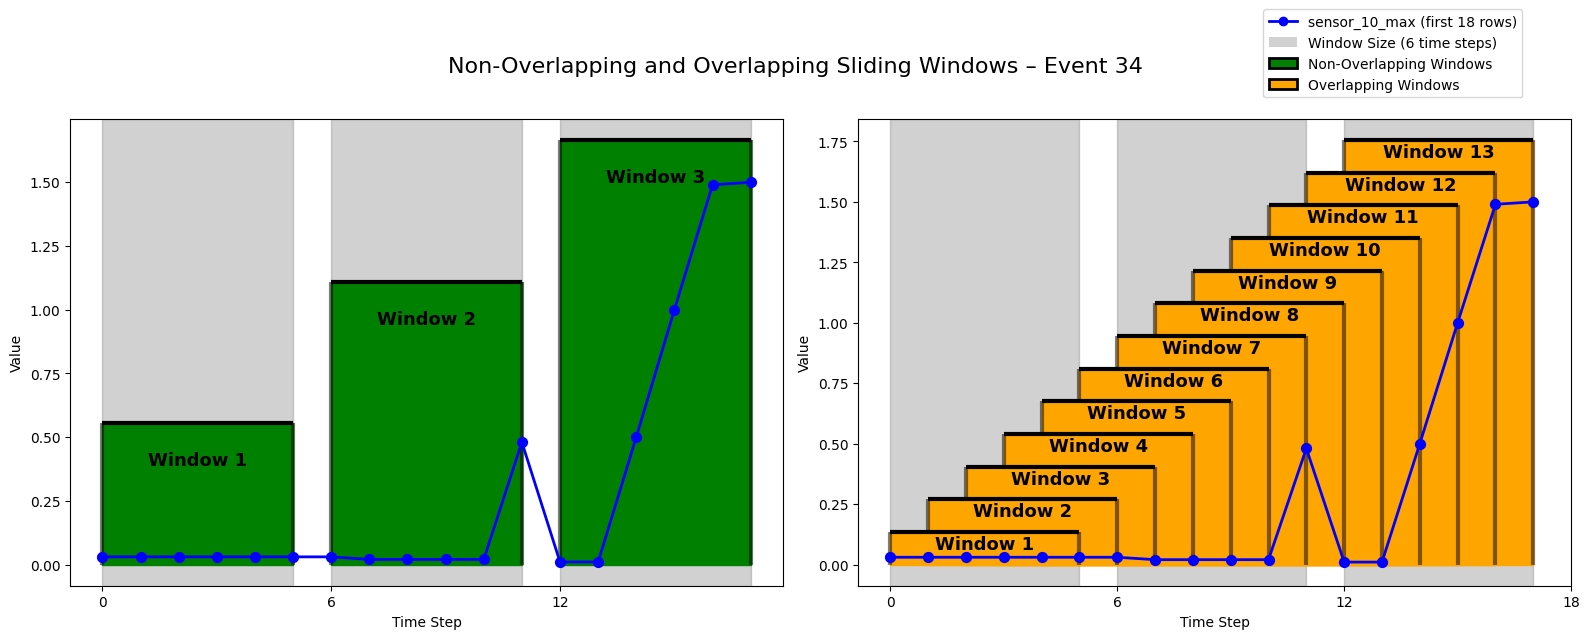

In [52]:
def create_sequences_overlapping(data, timesteps):
    return [data[i : i + timesteps] for i in range(len(data) - timesteps + 1)]

def create_sequences_non_overlapping(data, timesteps):
    return [data[i : i + timesteps] for i in range(0, len(data) - timesteps + 1, timesteps)]

event_34 = datasets["Event 34"]
event_34['time_stamp'] = pd.to_datetime(event_34['time_stamp'])
sensor_data = event_34['sensor_10_max'].values[:18]
time = np.arange(len(sensor_data))

timesteps = 6

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(time, sensor_data, color='blue', linewidth=2, zorder=3)
plt.scatter(time, sensor_data, color='blue', s=50, zorder=3)

single_color = 'dimgray'

for i in range(0, len(sensor_data), timesteps):
    start = i
    end = min(i + timesteps, len(sensor_data))

    plt.axvspan(time[start], time[end-1], color=single_color, alpha=0.3)

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.xticks(np.arange(0, len(sensor_data)+1, timesteps))

num_windows_non = len(sensor_data) // timesteps
line_color = "black"
fill_color = "green"
box_height = max(sensor_data) * 0.37

prev_tops_non = np.zeros(len(sensor_data))

for i in range(0, len(sensor_data), timesteps):
    start = i
    end = min(i + timesteps, len(sensor_data))
    y_top = (i//timesteps + 1) * box_height

    plt.hlines(y=y_top, xmin=time[start], xmax=time[end-1], color=line_color, linewidth=3)
    plt.vlines(x=time[start], ymin=prev_tops_non[start], ymax=y_top, color=line_color, linewidth=3, alpha=0.5)
    plt.vlines(x=time[end-1], ymin=prev_tops_non[end-1], ymax=y_top, color=line_color, linewidth=3, alpha=0.5)
    plt.fill_between(time[start:end], prev_tops_non[start:end], y_top, color=fill_color, alpha=1)

    plt.text((time[start] + time[end-1]) / 2,
         y_top - box_height * 0.2,
         f'Window {i//timesteps + 1}',
         ha='center',
         va='top',
         fontsize=13,
         fontweight='bold',
         color='black',
         zorder=4)

    prev_tops_non[start:end] = y_top

plt.subplot(1, 2, 2)
plt.plot(time, sensor_data, color='blue', linewidth=2, zorder=3)
plt.scatter(time, sensor_data, color='blue', s=50, zorder=3)

single_color = 'dimgray'

for i in range(0, len(sensor_data), timesteps):
    start = i
    end = min(i + timesteps, len(sensor_data))

    plt.axvspan(time[start], time[end-1], color=single_color, alpha=0.3)

num_windows = len(sensor_data) - timesteps + 1
line_color = "black"
fill_color = "orange"
box_height = max(sensor_data) * 0.09

prev_tops = np.zeros(len(sensor_data))

for i in range(num_windows):
    start = i
    end = i + timesteps - 1
    y_top = (i+1) * box_height

    plt.hlines(y=y_top, xmin=time[start], xmax=time[end], color=line_color, linewidth=3)
    plt.vlines(x=time[start], ymin=prev_tops[start], ymax=y_top, color=line_color, linewidth=3, alpha=0.5)
    plt.vlines(x=time[end], ymin=prev_tops[end], ymax=y_top, color=line_color, linewidth=3, alpha=0.5)
    plt.fill_between(time[start:end+1], 0, y_top, color=fill_color, alpha=1)

    plt.text((time[start] + time[end]) / 2,
         y_top - box_height * 0.10,
         f'Window {i+1}',
         ha='center',
         va='top',
         fontsize=13,
         fontweight='bold',
         color='black',
         zorder=4)

    prev_tops[start:end+1] = y_top

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.xticks(np.arange(0, len(sensor_data)+1, timesteps))

legend_elements = [
    Line2D([0], [0], color='blue', lw=2, marker='o', markersize=6, label='sensor_10_max (first 18 rows)'),
    Patch(facecolor='dimgray', alpha=0.3, label='Window Size (6 time steps)'),
    Patch(facecolor='green', alpha=1, edgecolor='black', linewidth=2, label='Non-Overlapping Windows'),
    Patch(facecolor='orange', alpha=1, edgecolor='black', linewidth=2, label='Overlapping Windows')
]

plt.tight_layout(rect=[0, 0, 1, 0.9])

plt.legend(
    handles=legend_elements,
    loc='upper center',
    bbox_to_anchor=(0.75, 1.25),
    ncol=1,
    fontsize=10,
    frameon=True
)
#plt.savefig("non_overlapping_and_overlapping_windows_event34.png", dpi=300, bbox_inches="tight")
plt.suptitle("Non-Overlapping and Overlapping Sliding Windows – Event 34", fontsize=16)
plt.show()


###LSTM Autoencoder

#### Without Removing Low-Variance Features


Event 34
Selected features: ['sensor_10_max' 'reactive_power_11_std' 'sensor_10_avg' 'sensor_20_std'
 'sensor_15_std']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 6, 10)          │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 6, 5)           │            55 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,535 (6.00 KB)

 Trainable params: 1,535 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.7180 - val_loss: 0.8254
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6691 - val_loss: 0.7538
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6074 - val_loss: 0.6756
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5380 - val_loss: 0.6060
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4874 - val_loss: 0.5502
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4484 - val_loss: 0.5084
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4183 - val_loss: 0.4748
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3957 - val_loss: 0.4475
Epoch 9/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3779 - val_loss: 0.4257
Epoch 10/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3641 - val_loss: 0.4077
Epoch 11/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3532 - val_loss: 0.3936
Epoch 12/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/ste

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 6, 10)          │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 6, 5)           │            55 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,535 (6.00 KB)

 Trainable params: 1,535 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.6307 - val_loss: 0.7401
Epoch 2/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5900 - val_loss: 0.7049
Epoch 3/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5516 - val_loss: 0.6651
Epoch 4/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5122 - val_loss: 0.6189
Epoch 5/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4712 - val_loss: 0.5749
Epoch 6/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4386 - val_loss: 0.5414
Epoch 7/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4149 - val_loss: 0.5146
Epoch 8/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3951 - val_loss: 0.4900
Epoch 9/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3771 - val_loss: 0.4645
Epoch 10/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3605 - val_loss: 0.4394
Epoch 11/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3459 - val_loss: 0.4176
Epoch 12/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/st

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 6, 10)          │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 6, 5)           │            55 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,535 (6.00 KB)

 Trainable params: 1,535 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.7985 - val_loss: 0.6884
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7491 - val_loss: 0.6319
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6893 - val_loss: 0.5456
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.6154 - val_loss: 0.4679
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5554 - val_loss: 0.4167
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5078 - val_loss: 0.3762
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4711 - val_loss: 0.3446
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4406 - val_loss: 0.3183
Epoch 9/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4129 - val_loss: 0.2950
Epoch 10/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3879 - val_loss: 0.2748
Epoch 11/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3682 - val_loss: 0.2579
Epoch 12/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 10)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 6, 10)          │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 6, 5)           │            55 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,535 (6.00 KB)

 Trainable params: 1,535 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.7946 - val_loss: 0.7349
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7488 - val_loss: 0.6938
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7000 - val_loss: 0.6386
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6265 - val_loss: 0.5663
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5413 - val_loss: 0.4915
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4842 - val_loss: 0.4338
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4526 - val_loss: 0.3965
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4287 - val_loss: 0.3678
Epoch 9/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4096 - val_loss: 0.3409
Epoch 10/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3920 - val_loss: 0.3142
Epoch 11/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3745 - val_loss: 0.2874
Epoch 12/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/st

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 10)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 6, 10)          │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 6, 5)           │            55 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,535 (6.00 KB)

 Trainable params: 1,535 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.7926 - val_loss: 0.7689
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7313 - val_loss: 0.7091
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6682 - val_loss: 0.6591
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6266 - val_loss: 0.6119
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5878 - val_loss: 0.5600
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5478 - val_loss: 0.5163
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5162 - val_loss: 0.4790
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4912 - val_loss: 0.4417
Epoch 9/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4678 - val_loss: 0.4049
Epoch 10/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4470 - val_loss: 0.3759
Epoch 11/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4321 - val_loss: 0.3552
Epoch 12/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/st

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 10)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 6, 10)          │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 6, 5)           │            55 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,535 (6.00 KB)

 Trainable params: 1,535 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7827 - val_loss: 0.7126
Epoch 2/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7348 - val_loss: 0.6678
Epoch 3/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6852 - val_loss: 0.6059
Epoch 4/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6212 - val_loss: 0.5290
Epoch 5/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5559 - val_loss: 0.4636
Epoch 6/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5042 - val_loss: 0.4146
Epoch 7/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4676 - val_loss: 0.3804
Epoch 8/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4415 - val_loss: 0.3553
Epoch 9/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4215 - val_loss: 0.3349
Epoch 10/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4037 - val_loss: 0.3166
Epoch 11/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3879 - val_loss: 0.2994
Epoch 12/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/s

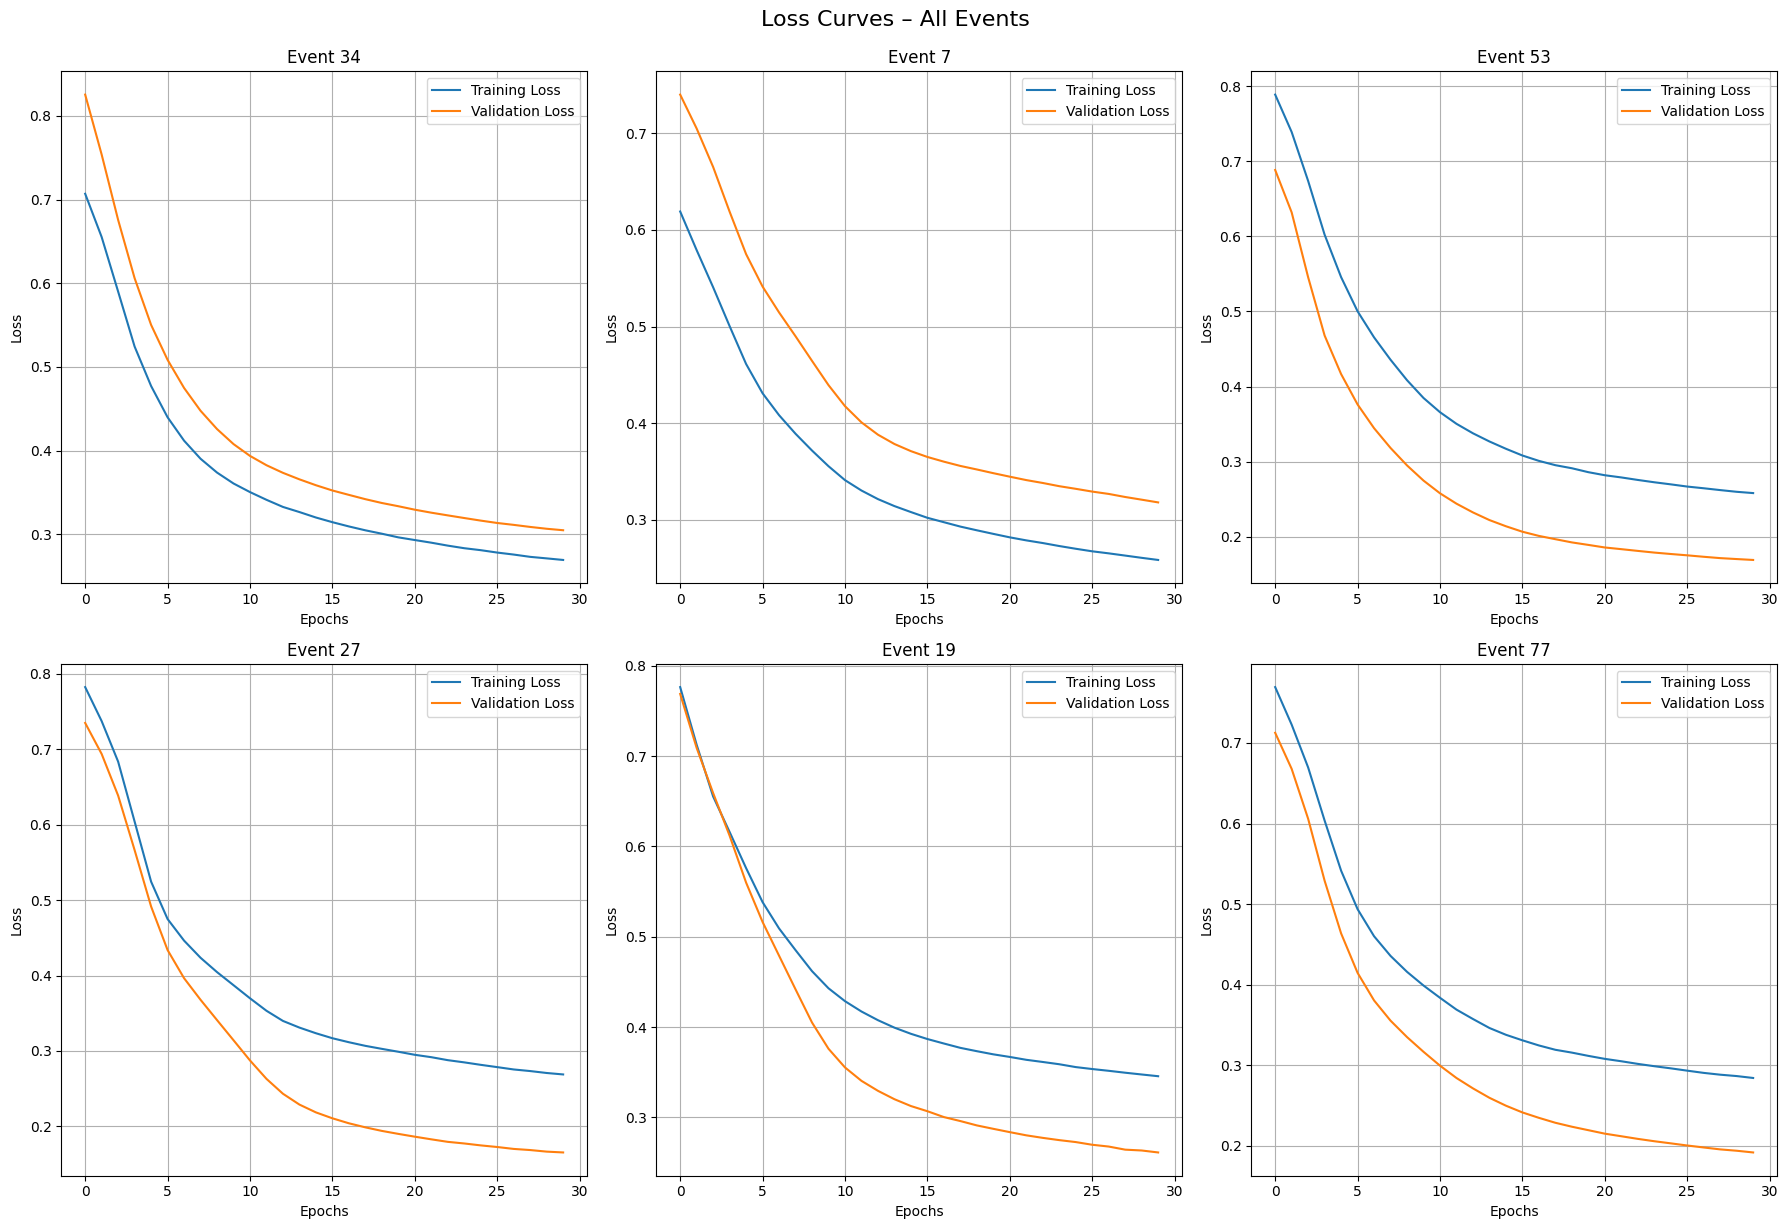

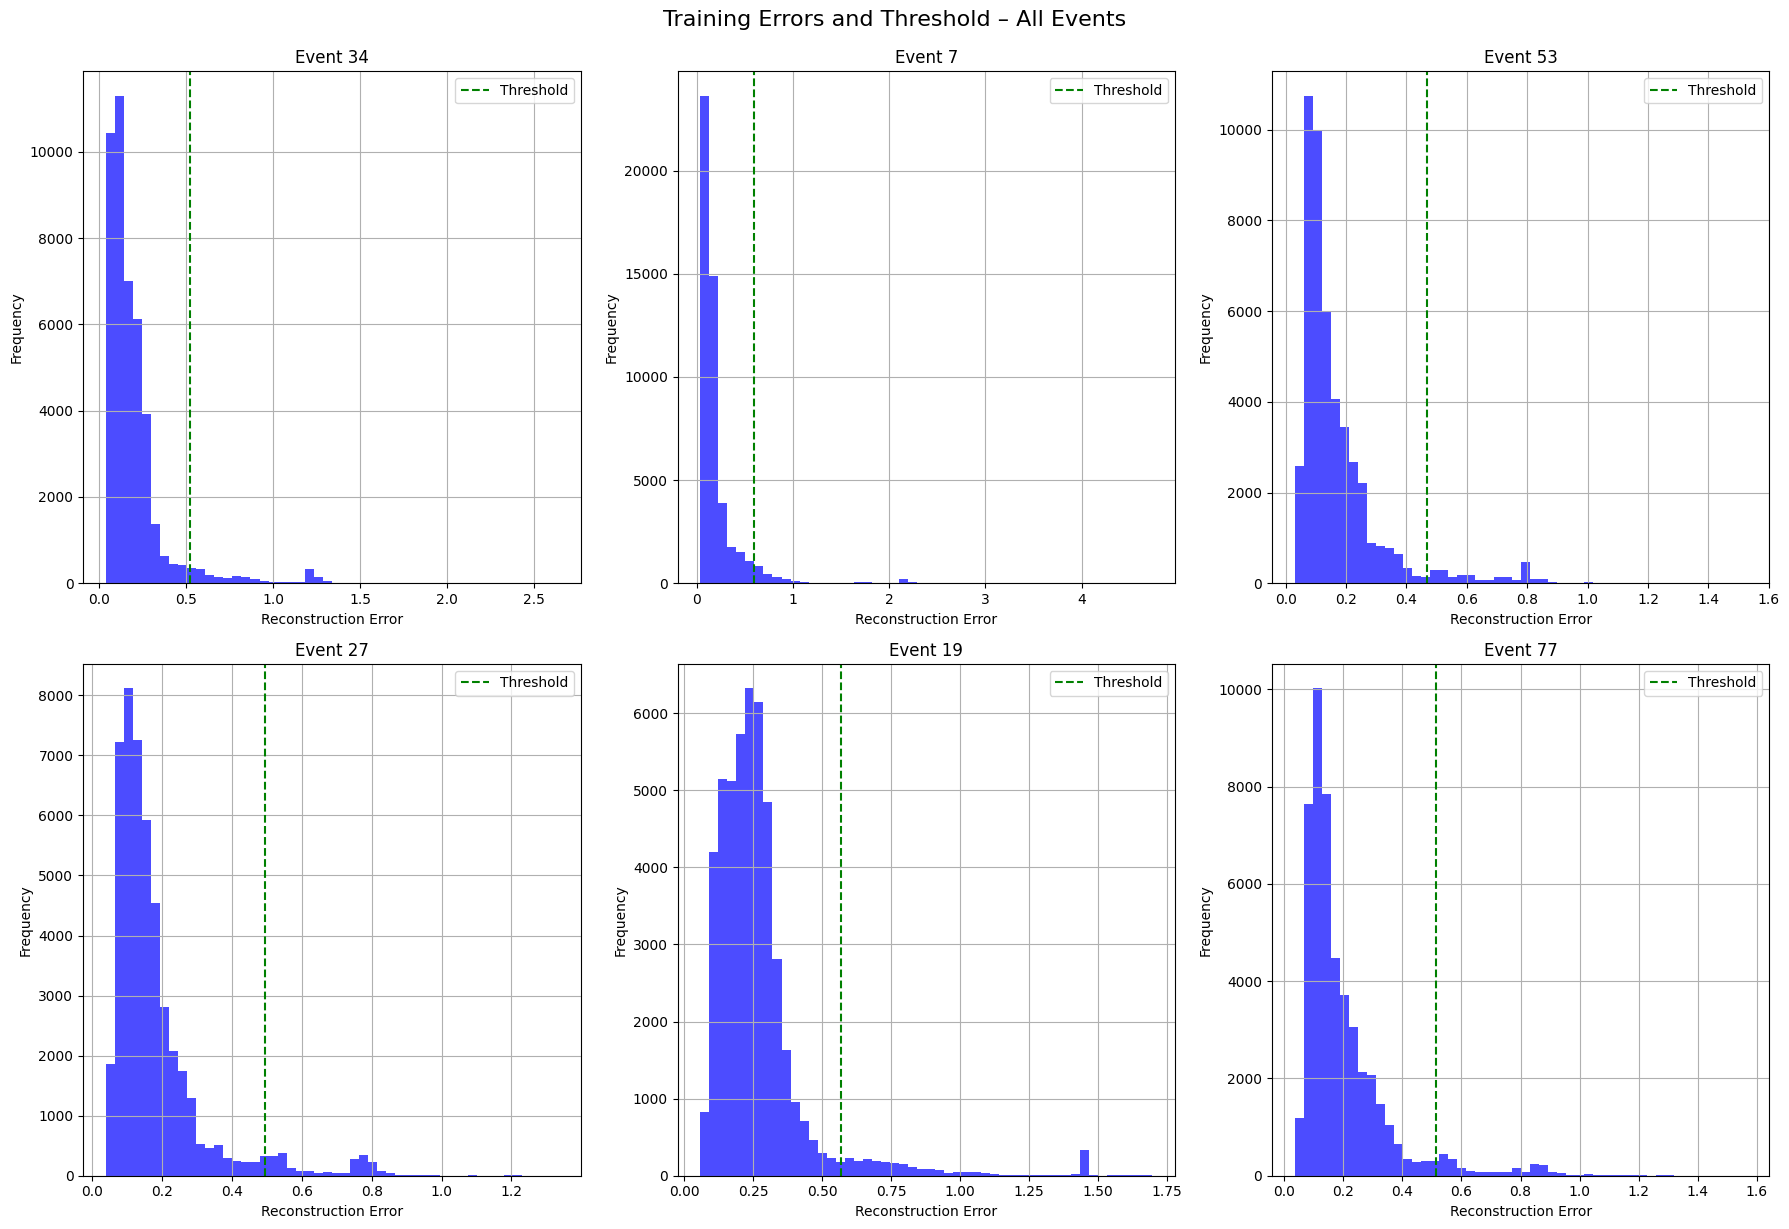

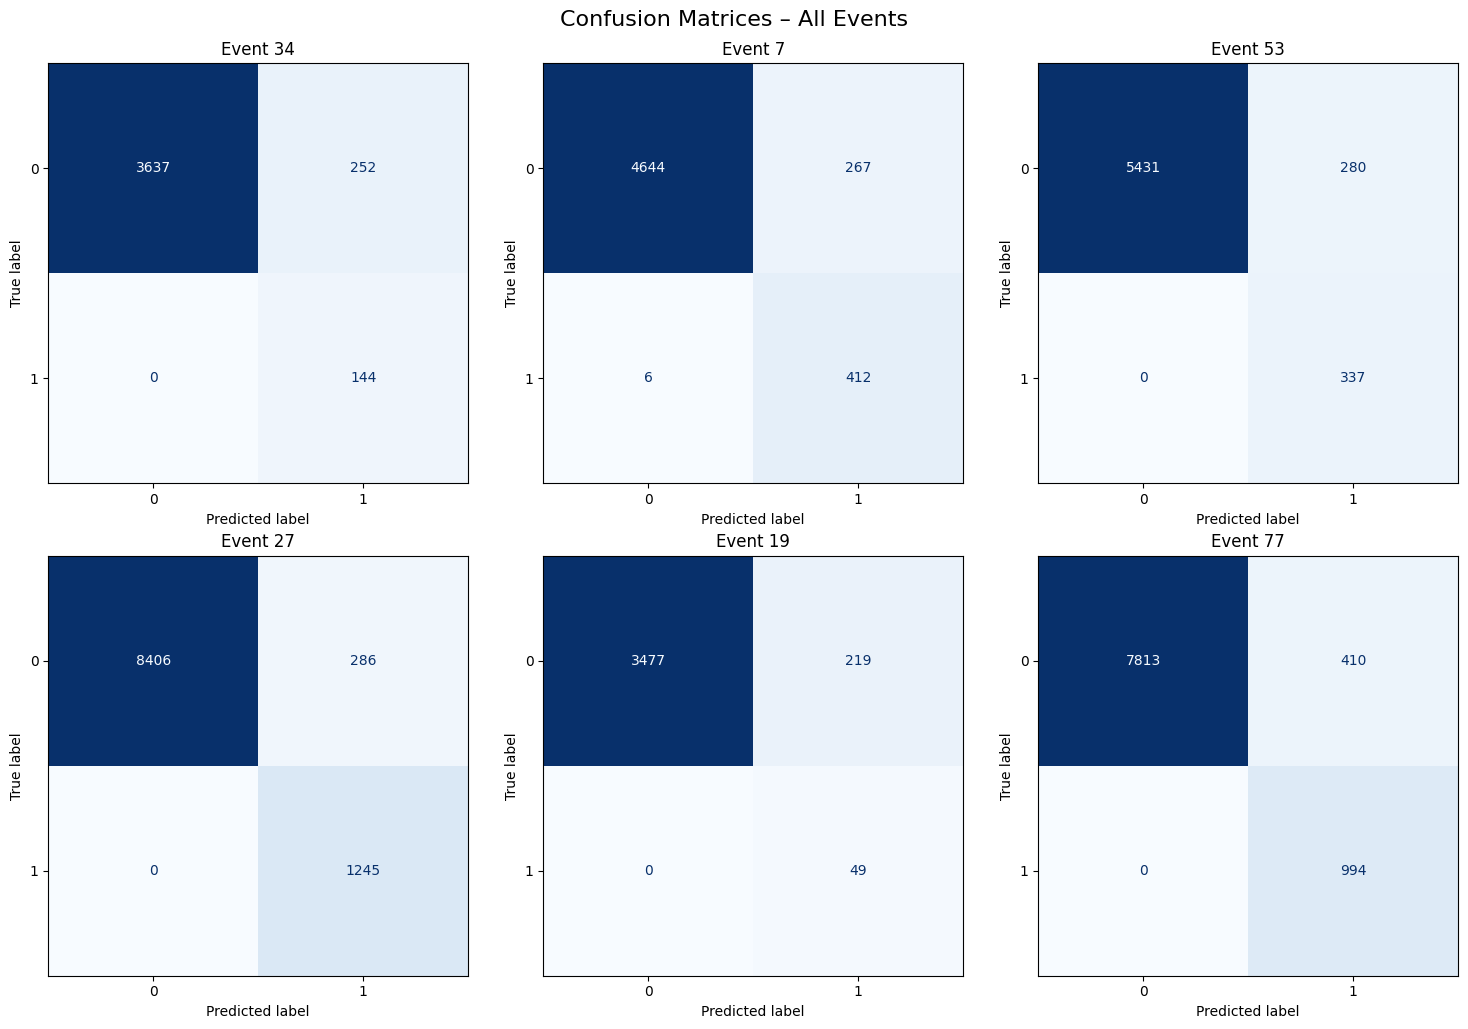

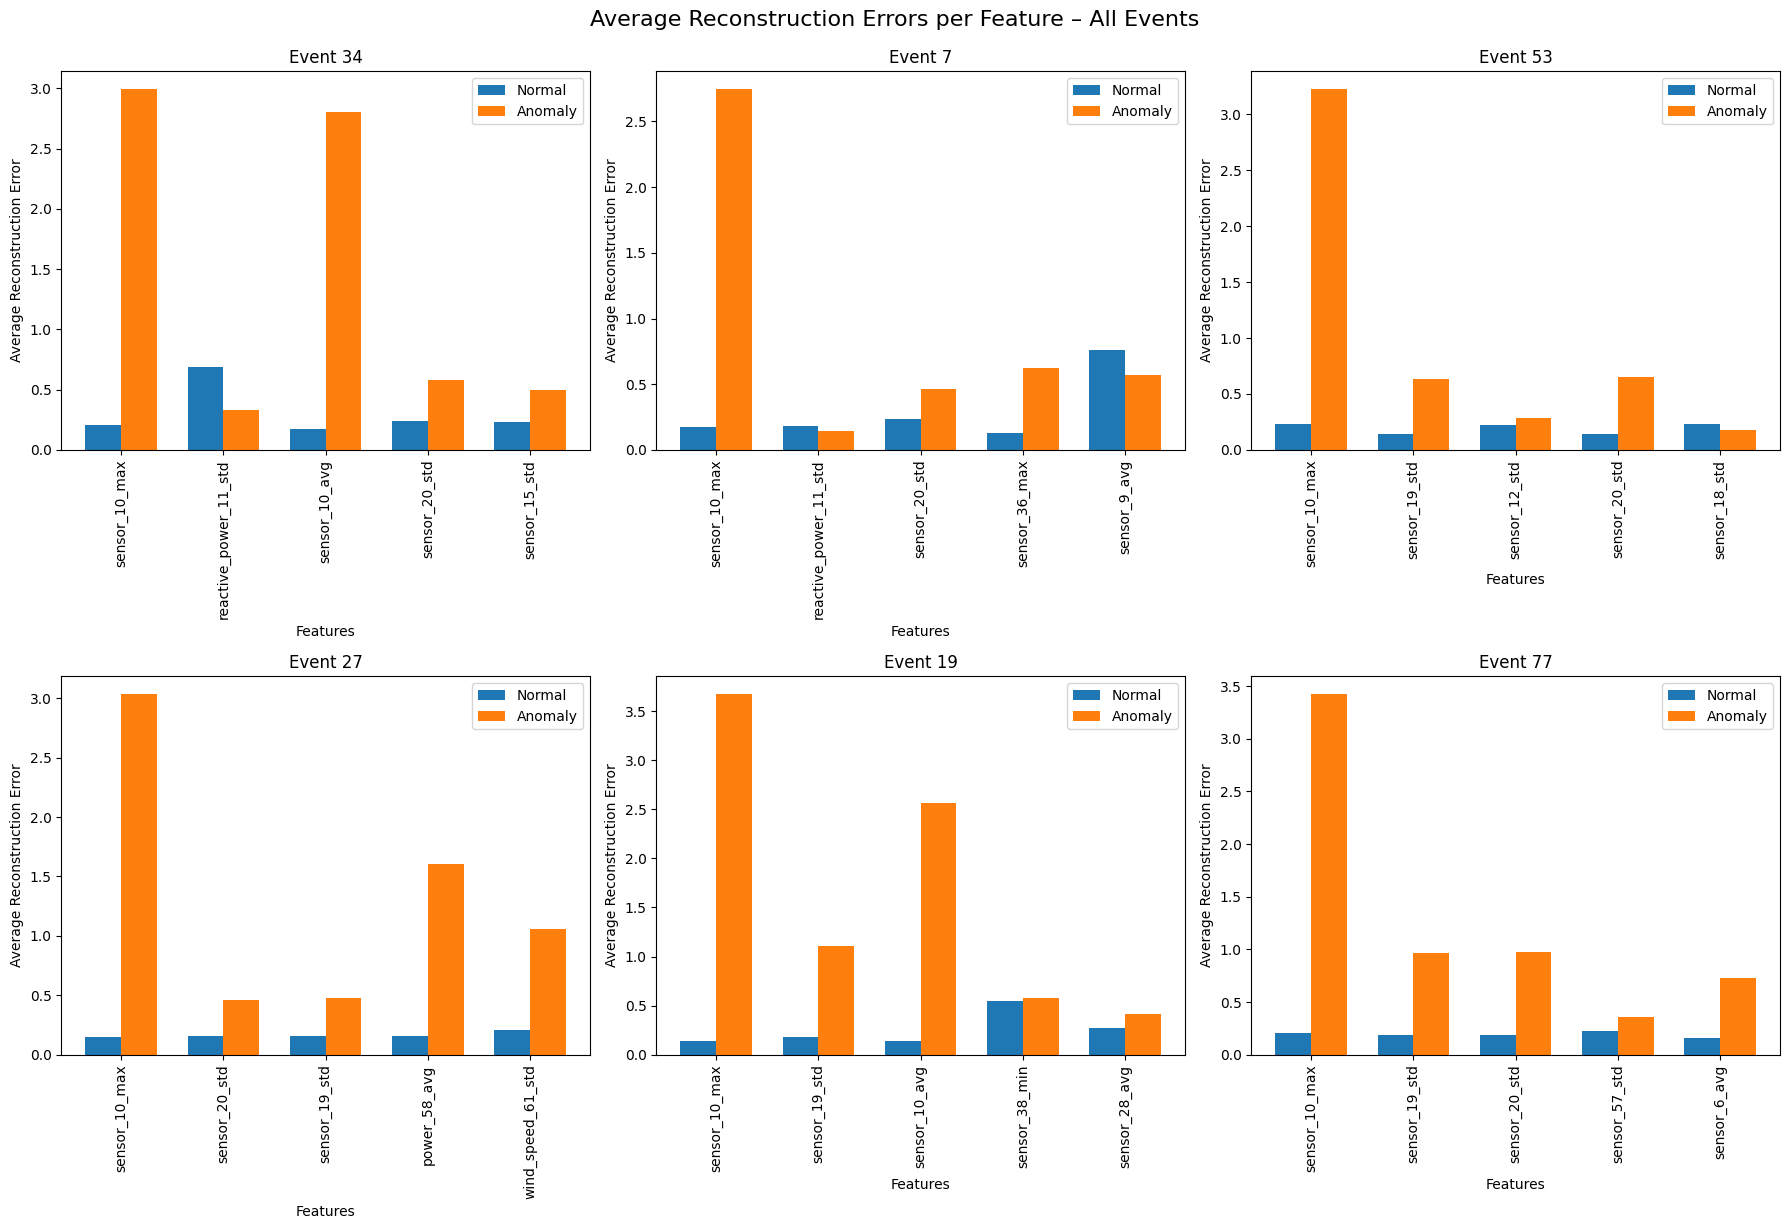

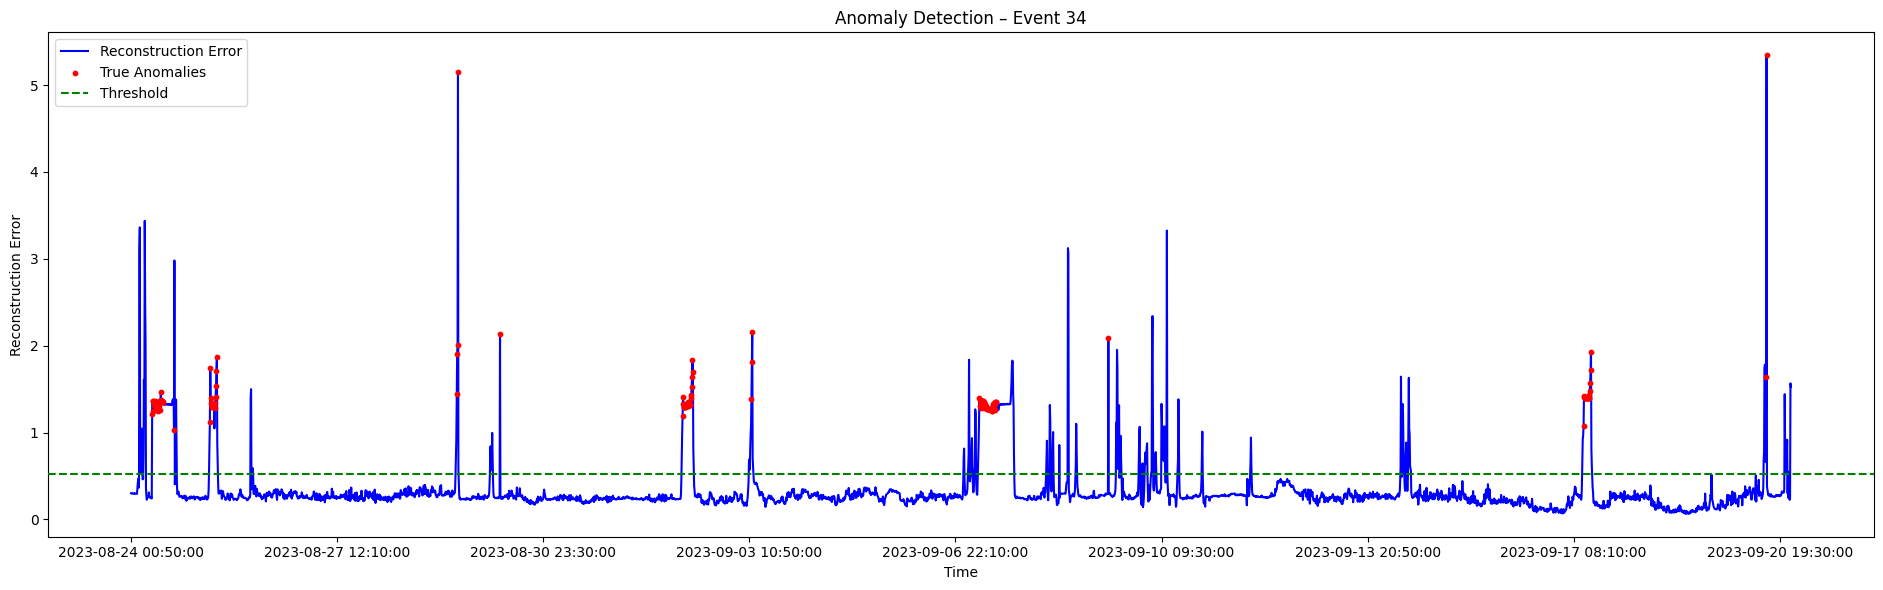

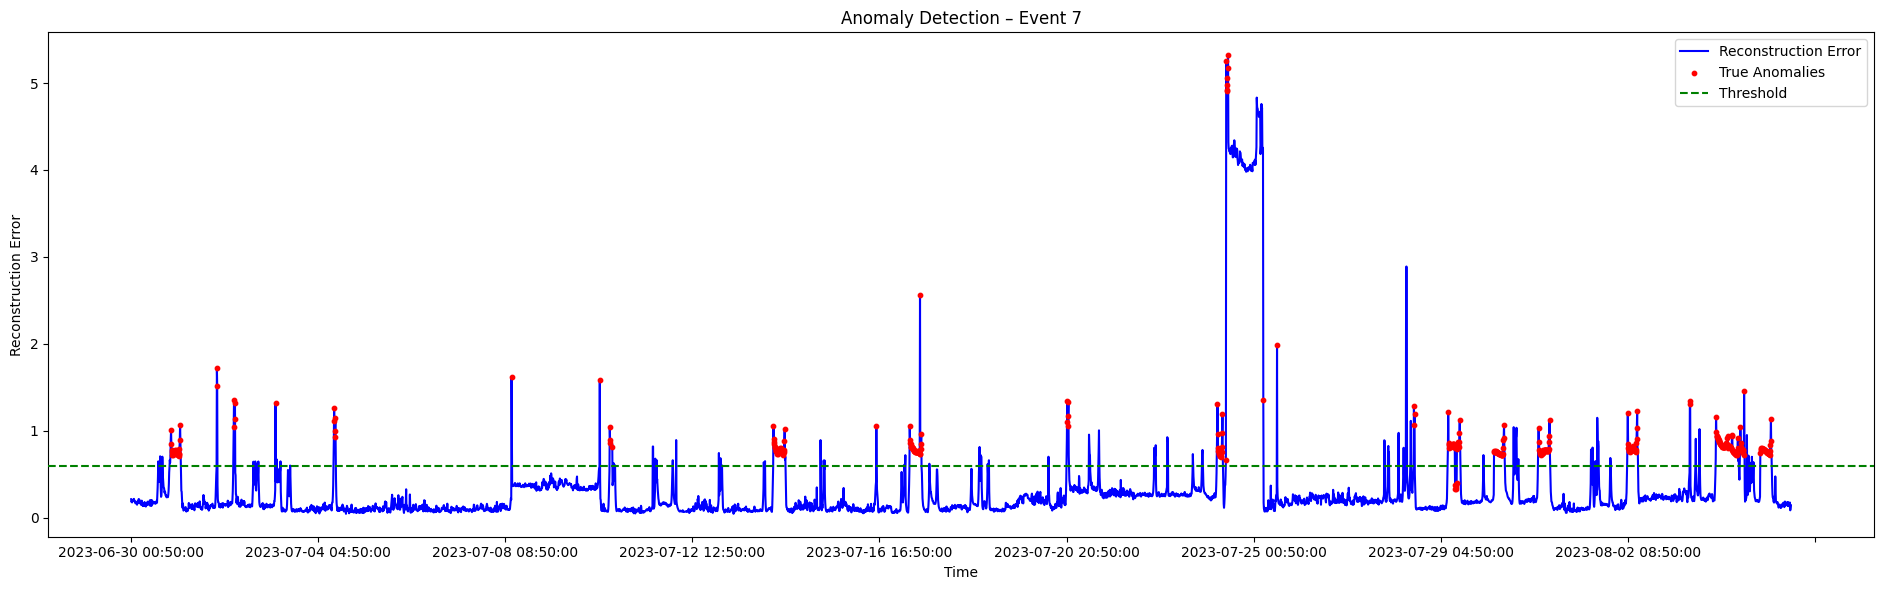

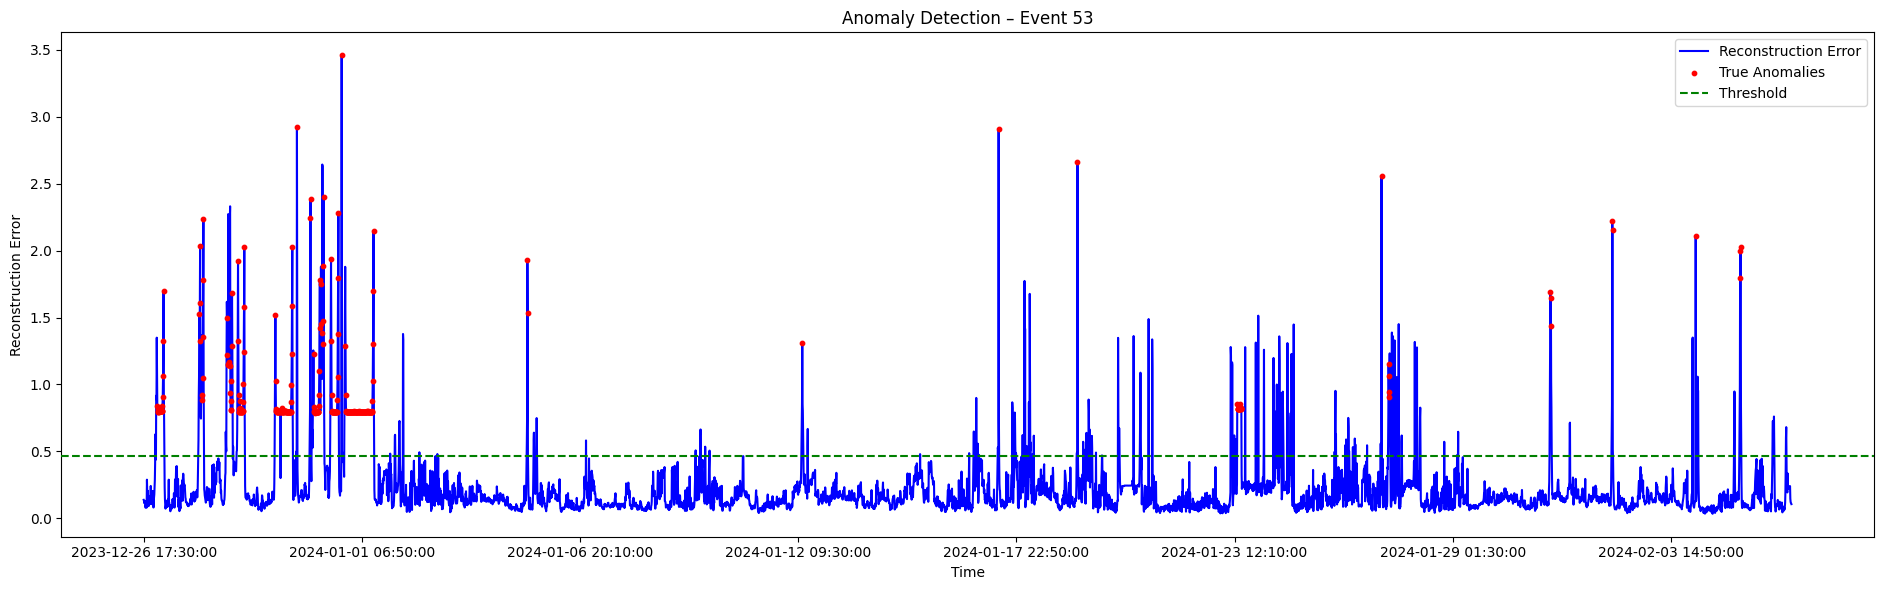

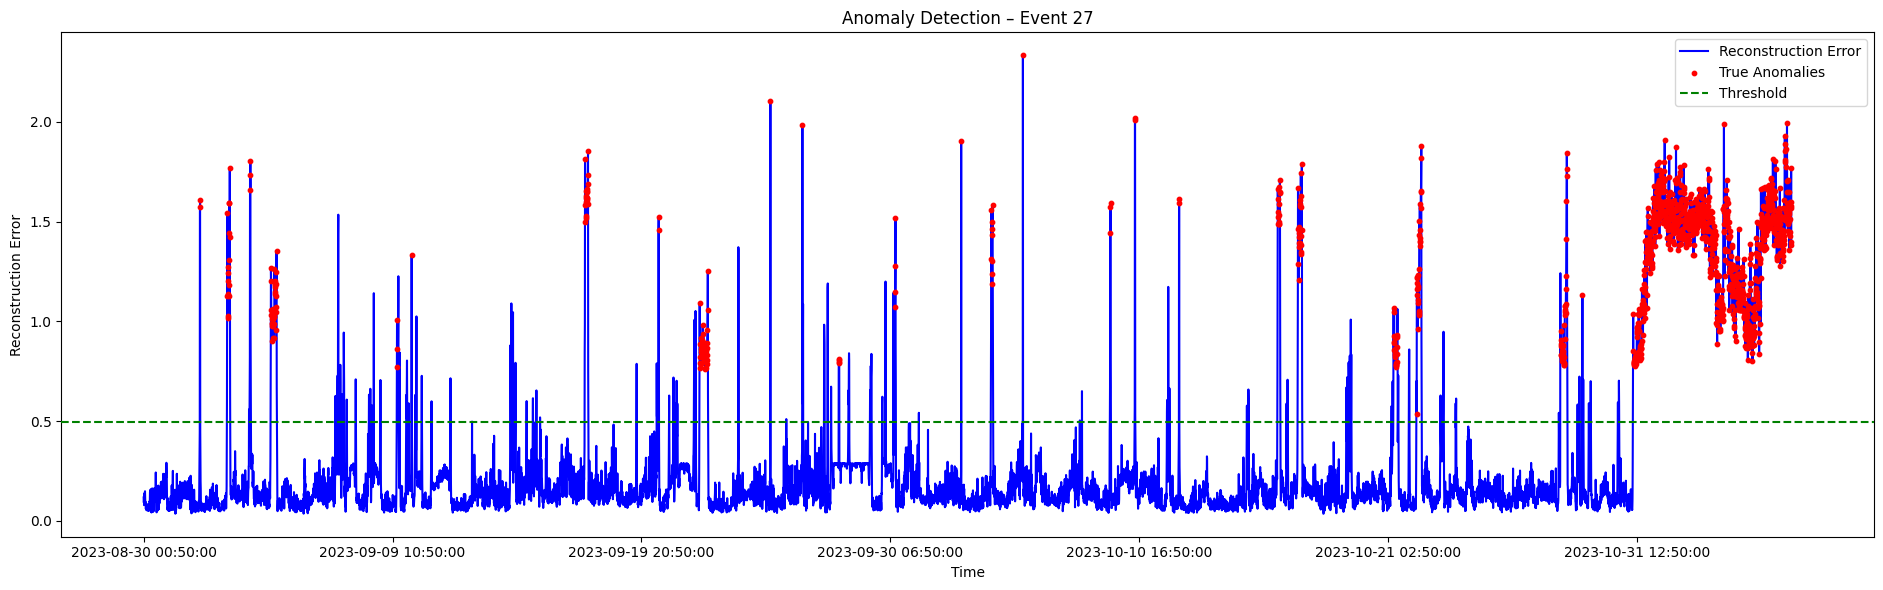

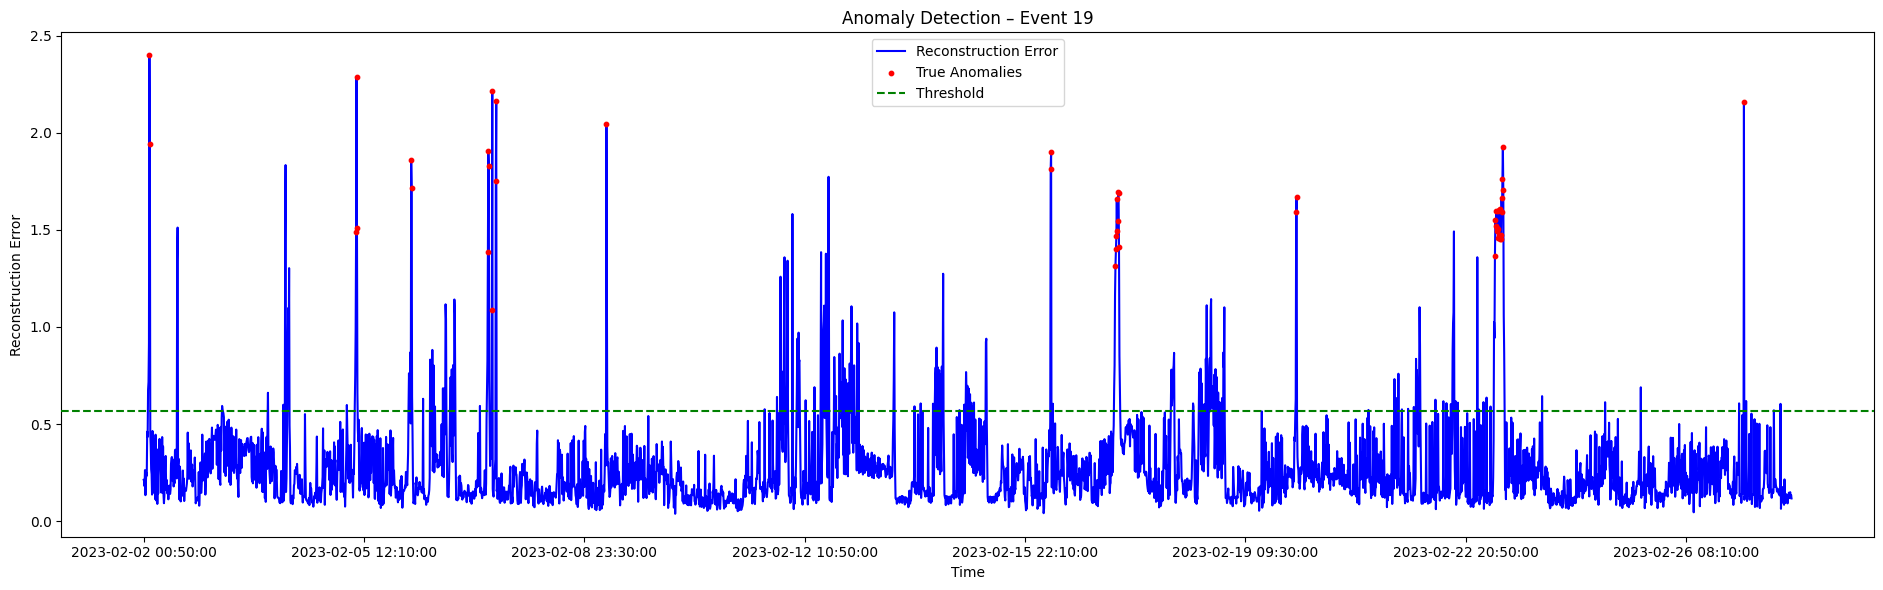

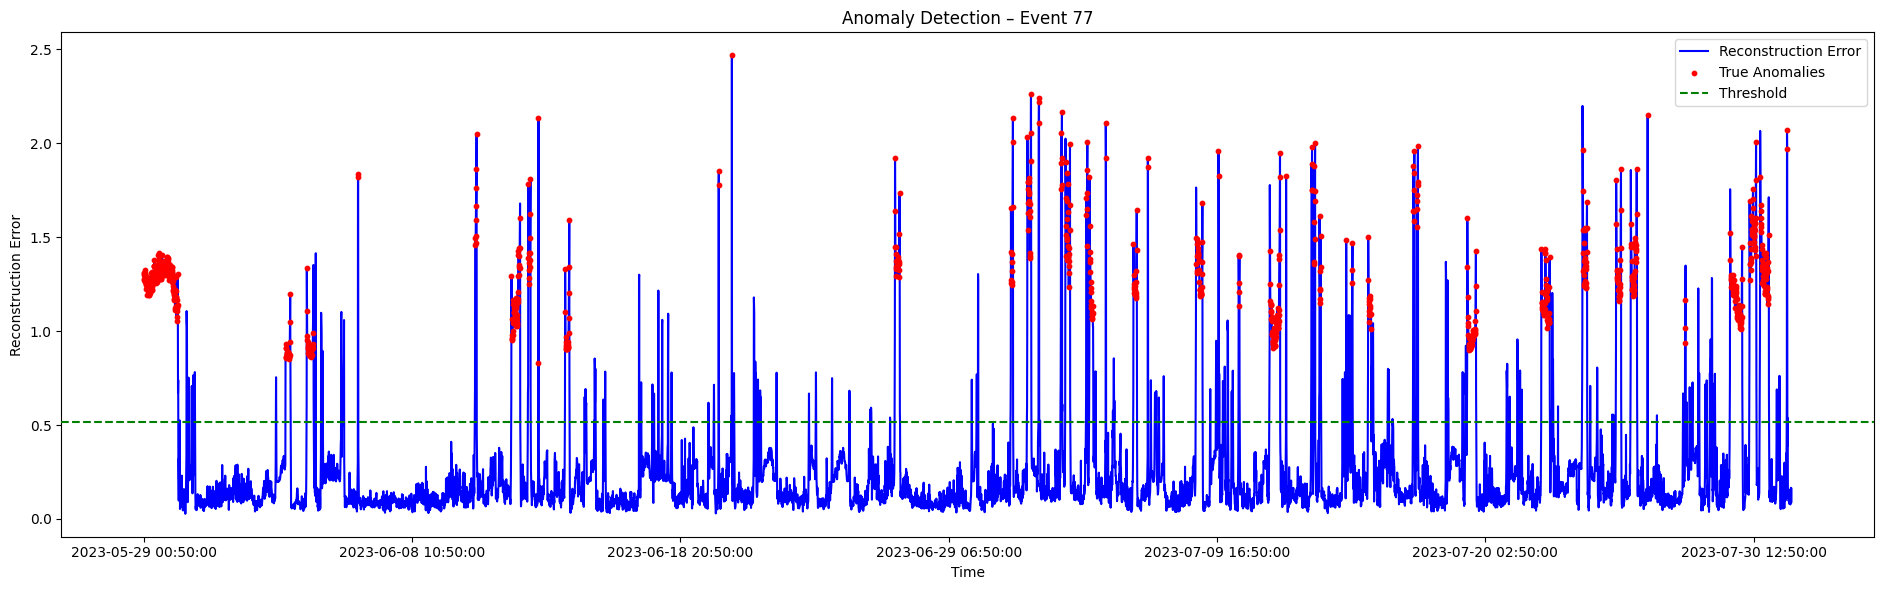

In [28]:
def create_sequences(data, timesteps):
    return np.array([data[i: i + timesteps] for i in range(len(data) - timesteps + 1)])


def create_sequences_with_indices(data, timesteps):
    sequences, index_map = [], []
    for i in range(len(data) - timesteps + 1):
        sequences.append(data[i: i + timesteps])
        index_map.append(list(range(i, i + timesteps)))
    return np.array(sequences), index_map


def safe_confusion_matrix(y_true, y_pred):
    labels = [0, 1]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if cm.shape == (1, 1):
        TN = cm[0, 0] if y_true[0] == 0 else 0
        FP = FN = TP = 0
    elif cm.shape == (1, 2):
        TN, FP = cm[0]
        FN = TP = 0
    elif cm.shape == (2, 1):
        TN = cm[0, 0]
        FN = cm[1, 0]
        FP = TP = 0
    else:
        TN, FP, FN, TP = cm.ravel()
    return TN, FP, FN, TP


datasets = {
    'Event 34': pd.read_csv('Wind Farm B/datasets/34.csv', sep=';'),
    'Event 7': pd.read_csv('Wind Farm B/datasets/7.csv', sep=';'),
    'Event 53': pd.read_csv('Wind Farm B/datasets/53.csv', sep=';'),
    'Event 27': pd.read_csv('Wind Farm B/datasets/27.csv', sep=';'),
    'Event 19': pd.read_csv('Wind Farm B/datasets/19.csv', sep=';'),
    'Event 77': pd.read_csv('Wind Farm B/datasets/77.csv', sep=';')
}

timesteps = 6
conf_matrices = {}
results = []
loss_curves = {}
histograms = {}
feature_errors_dict = {}
time_series_errors = {}

for event_name, df in datasets.items():
    print(f"\n{event_name}")

    df['label'] = df['status_type_id'].apply(lambda x: 0 if x in [0, 2] else 1)

    features = df.drop(columns=['train_test', 'status_type_id', 'asset_id', 'time_stamp', 'id'], errors='ignore')
    if 'label' not in features.columns:
        features['label'] = df['label']
    labels = features['label']
    features = features.drop(columns=['label'])

    model = xgb.XGBClassifier(objective="binary:logistic")
    model.fit(features, labels)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(features)

    shap_importance = pd.DataFrame({
        'feature': features.columns,
        'mean_abs_shap': np.abs(shap_values).mean(axis=0)
    }).sort_values(by='mean_abs_shap', ascending=False)

    top_features = shap_importance.head(5)['feature'].values
    print("Selected features:", top_features)

    normal_train = df[(df['train_test'] == 'train') & (df['label'] == 0)]
    normal_train_filtered = normal_train[top_features]
    X_normal_train = normal_train_filtered

    scaler = StandardScaler()
    X_normal_train_scaled = scaler.fit_transform(X_normal_train)

    X_train_seq = create_sequences(X_normal_train_scaled, timesteps)
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], timesteps, X_normal_train_scaled.shape[1]))

    os.environ['PYTHONHASHSEED'] = '42'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

    input_shape = (timesteps, X_normal_train_scaled.shape[1])
    inputs = Input(shape=input_shape)
    encoded = LSTM(10, activation='tanh', return_sequences=False)(inputs)
    encoded = Dropout(0.2)(encoded)
    bottleneck = RepeatVector(timesteps)(encoded)
    decoded = LSTM(10, activation='tanh', return_sequences=True)(bottleneck)
    decoded = Dropout(0.2)(decoded)
    outputs = TimeDistributed(Dense(X_normal_train_scaled.shape[1], activation='linear'))(decoded)

    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer=Adam(0.0001), loss='mae')

    autoencoder.summary()

    history = autoencoder.fit(
        X_train_seq, X_train_seq,
        epochs=30, batch_size=256,
        validation_split=0.1, shuffle=True, verbose=1
    )


    loss_curves[event_name] = history.history

    reconstructed_train = autoencoder.predict(X_train_seq)

    row_errors = np.mean(np.abs(X_train_seq - reconstructed_train), axis=(1, 2))
    threshold = np.percentile(row_errors, 95)

    print(f"Reconstruction error threshold ({event_name}): {threshold:.6f}")

    histograms[event_name] = (row_errors, threshold)

    test = df[df['train_test'] == 'prediction']
    X_test = test[top_features]
    y_test = test['label'].values
    X_test_scaled = scaler.transform(X_test)

    X_test_seq, index_map = create_sequences_with_indices(X_test_scaled, timesteps)
    reconstructed_test = autoencoder.predict(X_test_seq)

    abs_errors = np.abs(reconstructed_test - X_test_seq)
    sample_errors = np.mean(abs_errors, axis=2)

    error_sum, error_count = defaultdict(float), defaultdict(int)
    for seq_idx, row_indices in enumerate(index_map):
        for t_idx, row_idx in enumerate(row_indices):
            error_sum[row_idx] += sample_errors[seq_idx, t_idx]
            error_count[row_idx] += 1

    row_errors_test = np.array([error_sum[i] / error_count[i] if error_count[i] > 0 else np.nan
                                for i in range(len(X_test_scaled))])
    predicted_labels = (row_errors_test > threshold).astype(int)

    valid_mask = ~np.isnan(row_errors_test)
    y_true, y_pred = y_test[valid_mask], predicted_labels[valid_mask]

    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred, zero_division=0) * 100
    rec = recall_score(y_true, y_pred, zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, zero_division=0) * 100
    TN, FP, FN, TP = safe_confusion_matrix(y_true, y_pred)
    far = (FP / (FP + TN) * 100) if (FP + TN) > 0 else 0

    results.append({
        'Event': event_name,
        'Accuracy': round(acc, 2),
        'Precision': round(prec, 2),
        'Recall': round(rec, 2),
        'F1': round(f1, 2),
        'FAR': round(far, 2)
    })

    conf_matrices[event_name] = np.array([[TN, FP], [FN, TP]])

    num_features = abs_errors.shape[2]
    num_samples = len(X_test_scaled)

    error_sum_per_feature = defaultdict(lambda: np.zeros(num_features))
    error_count_per_feature = defaultdict(int)

    for seq_idx, row_indices in enumerate(index_map):
        for t_idx, row_idx in enumerate(row_indices):
            error_sum_per_feature[row_idx] += abs_errors[seq_idx, t_idx]
            error_count_per_feature[row_idx] += 1

    feature_errors_per_sample = np.zeros((num_samples, num_features))

    for i in range(num_samples):
        if error_count_per_feature[i] > 0:
            feature_errors_per_sample[i] = error_sum_per_feature[i] / error_count_per_feature[i]
        else:
            feature_errors_per_sample[i] = np.nan

    feature_errors_valid = feature_errors_per_sample[valid_mask]
    y_true_valid = y_true
    y_pred_valid = y_pred

    normal_errors = feature_errors_valid[y_true_valid == 0]
    anomaly_errors = feature_errors_valid[y_true_valid == 1]

    avg_normal_errors = np.nanmean(normal_errors, axis=0)
    avg_anomaly_errors = np.nanmean(anomaly_errors, axis=0)

    feature_errors_dict[event_name] = (top_features, avg_normal_errors, avg_anomaly_errors)

    test = df[df['train_test'] == 'prediction']
    test_data = test[timesteps - 1:]
    timestamps = test_data['time_stamp'].values
    y_true_aligned = y_true[timesteps - 1:]
    y_pred_aligned = y_pred[timesteps - 1:]
    row_errors_aligned = row_errors_test[timesteps - 1:]

    time_series_errors[event_name] = (row_errors_aligned, threshold, y_true_aligned, y_pred_aligned, timestamps)


results_df = pd.DataFrame(results)
results_df.loc['Average'] = results_df.mean(numeric_only=True).round(2)

print("\nAnomaly Detection Results for All Events: LSTM Autoencoder (without removing low-variance features) (%):\n")
print(results_df)

print()


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for ax, (event_name, hist) in zip(axes, loss_curves.items()):
    ax.plot(hist['loss'], label='Training Loss')
    ax.plot(hist['val_loss'], label='Validation Loss')
    ax.set_title(event_name)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
fig.suptitle("Loss Curves – All Events", fontsize=16, y=1.02)
# plt.savefig("loss_curves_all_events.png", dpi=300, bbox_inches="tight")
plt.show()

print()


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for ax, (event_name, (errors, threshold)) in zip(axes, histograms.items()):
    ax.hist(errors, bins=50, color="blue", alpha=0.7)
    ax.axvline(x=threshold, color="green", linestyle="--", label="Threshold")
    ax.set_title(event_name)
    ax.set_xlabel("Reconstruction Error")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.grid(True)
plt.tight_layout()
fig.suptitle("Training Errors and Threshold – All Events", fontsize=16, y=1.02)
# plt.savefig("histograms_all_events.png", dpi=300, bbox_inches="tight")
plt.show()

print()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
labels = [0, 1]
for ax, (event_name, cm) in zip(axes.flatten(), conf_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax, colorbar=False)
    ax.set_title(event_name)
plt.tight_layout()
fig.suptitle("Confusion Matrices – All Events", fontsize=16, y=1.02)
# plt.savefig("confusion_matrices_all_events_lstm_nofilter.png", dpi=300, bbox_inches="tight")
plt.show()

print()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for ax, (event_name, (top_features, avg_normal_errors, avg_anomaly_errors)) in zip(axes, feature_errors_dict.items()):
    x = np.arange(len(top_features))
    width = 0.35
    ax.bar(x - width/2, avg_normal_errors, width, label='Normal')
    ax.bar(x + width/2, avg_anomaly_errors, width, label='Anomaly')
    ax.set_xlabel('Features')
    ax.set_ylabel('Average Reconstruction Error')
    ax.set_xticks(x)
    ax.set_xticklabels(top_features, rotation=90)
    ax.legend()
    ax.set_title(event_name)
plt.tight_layout()
fig.suptitle("Average Reconstruction Errors per Feature – All Events", fontsize=16, y=1.02)
# plt.savefig("feature_errors_all_events.png", dpi=300, bbox_inches="tight")
plt.show()

print()

for event_name, (row_errors_aligned, threshold, y_true_aligned, y_pred_aligned, timestamps) in time_series_errors.items():
    plt.figure(figsize=(19, 6))

    anomalies = (y_true_aligned == 1)
    plt.plot(timestamps, row_errors_aligned, label="Reconstruction Error", color="blue", zorder=2)
    plt.scatter(timestamps[anomalies], row_errors_aligned[anomalies],
                color="red", label="True Anomalies", s=10, zorder=5)
    plt.axhline(y=threshold, color="green", linestyle="--", label="Threshold", zorder=3)

    plt.xlabel("Time")
    plt.ylabel("Reconstruction Error")
    plt.title(f"Anomaly Detection – {event_name}")
    plt.legend()
    plt.tight_layout()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

    plt.show()
    print()


#### Removing Low-Variance Features


Event 34
Selected features: ['sensor_10_max' 'sensor_10_avg' 'sensor_20_std' 'sensor_15_std'
 'sensor_30_std']


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 10)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_6 (RepeatVector)  │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 6, 10)          │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 6, 5)           │            55 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,535 (6.00 KB)

 Trainable params: 1,535 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.7493 - val_loss: 0.6938
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7044 - val_loss: 0.6424
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6543 - val_loss: 0.5848
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6017 - val_loss: 0.5187
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5560 - val_loss: 0.4673
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5256 - val_loss: 0.4421
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5040 - val_loss: 0.4233
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4840 - val_loss: 0.4041
Epoch 9/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4629 - val_loss: 0.3831
Epoch 10/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4424 - val_loss: 0.3610
Epoch 11/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4227 - val_loss: 0.3388
Epoch 12/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/ste

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 10)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_7 (RepeatVector)  │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 6, 10)          │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 6, 5)           │            55 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,535 (6.00 KB)

 Trainable params: 1,535 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.7445 - val_loss: 0.8733
Epoch 2/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6963 - val_loss: 0.8013
Epoch 3/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6276 - val_loss: 0.7056
Epoch 4/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5507 - val_loss: 0.6282
Epoch 5/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4966 - val_loss: 0.5791
Epoch 6/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4631 - val_loss: 0.5421
Epoch 7/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4383 - val_loss: 0.5095
Epoch 8/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4187 - val_loss: 0.4796
Epoch 9/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4000 - val_loss: 0.4521
Epoch 10/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3844 - val_loss: 0.4284
Epoch 11/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3717 - val_loss: 0.4087
Epoch 12/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/s

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 10)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_8 (RepeatVector)  │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 6, 10)          │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 6, 5)           │            55 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,535 (6.00 KB)

 Trainable params: 1,535 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.7970 - val_loss: 0.6834
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7476 - val_loss: 0.6222
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6847 - val_loss: 0.5295
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6132 - val_loss: 0.4638
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5627 - val_loss: 0.4212
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5196 - val_loss: 0.3857
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4817 - val_loss: 0.3548
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4477 - val_loss: 0.3296
Epoch 9/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4236 - val_loss: 0.3107
Epoch 10/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4041 - val_loss: 0.2952
Epoch 11/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3886 - val_loss: 0.2815
Epoch 12/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/st

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 10)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_9 (RepeatVector)  │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 6, 10)          │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 6, 5)           │            55 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,535 (6.00 KB)

 Trainable params: 1,535 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.6707 - val_loss: 0.6987
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6255 - val_loss: 0.6437
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5786 - val_loss: 0.5869
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5313 - val_loss: 0.5342
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4883 - val_loss: 0.4830
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4456 - val_loss: 0.4322
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4090 - val_loss: 0.3868
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3811 - val_loss: 0.3515
Epoch 9/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3599 - val_loss: 0.3225
Epoch 10/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3451 - val_loss: 0.2983
Epoch 11/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3329 - val_loss: 0.2803
Epoch 12/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/s

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 10)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_10 (RepeatVector) │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 6, 10)          │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 6, 5)           │            55 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,535 (6.00 KB)

 Trainable params: 1,535 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.7348 - val_loss: 0.7798
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6574 - val_loss: 0.7087
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5941 - val_loss: 0.6434
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5481 - val_loss: 0.5581
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5003 - val_loss: 0.4742
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4597 - val_loss: 0.4258
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4292 - val_loss: 0.3899
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4004 - val_loss: 0.3596
Epoch 9/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3766 - val_loss: 0.3354
Epoch 10/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3594 - val_loss: 0.3178
Epoch 11/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3482 - val_loss: 0.3045
Epoch 12/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/st

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 10)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_11 (RepeatVector) │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 6, 10)          │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 6, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 6, 5)           │            55 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,535 (6.00 KB)

 Trainable params: 1,535 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.7974 - val_loss: 0.7229
Epoch 2/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7456 - val_loss: 0.6679
Epoch 3/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6826 - val_loss: 0.5866
Epoch 4/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6078 - val_loss: 0.5169
Epoch 5/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5510 - val_loss: 0.4621
Epoch 6/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.5057 - val_loss: 0.4160
Epoch 7/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4712 - val_loss: 0.3811
Epoch 8/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.4453 - val_loss: 0.3542
Epoch 9/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4235 - val_loss: 0.3303
Epoch 10/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4043 - val_loss: 0.3077
Epoch 11/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3868 - val_loss: 0.2878
Epoch 12/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/s

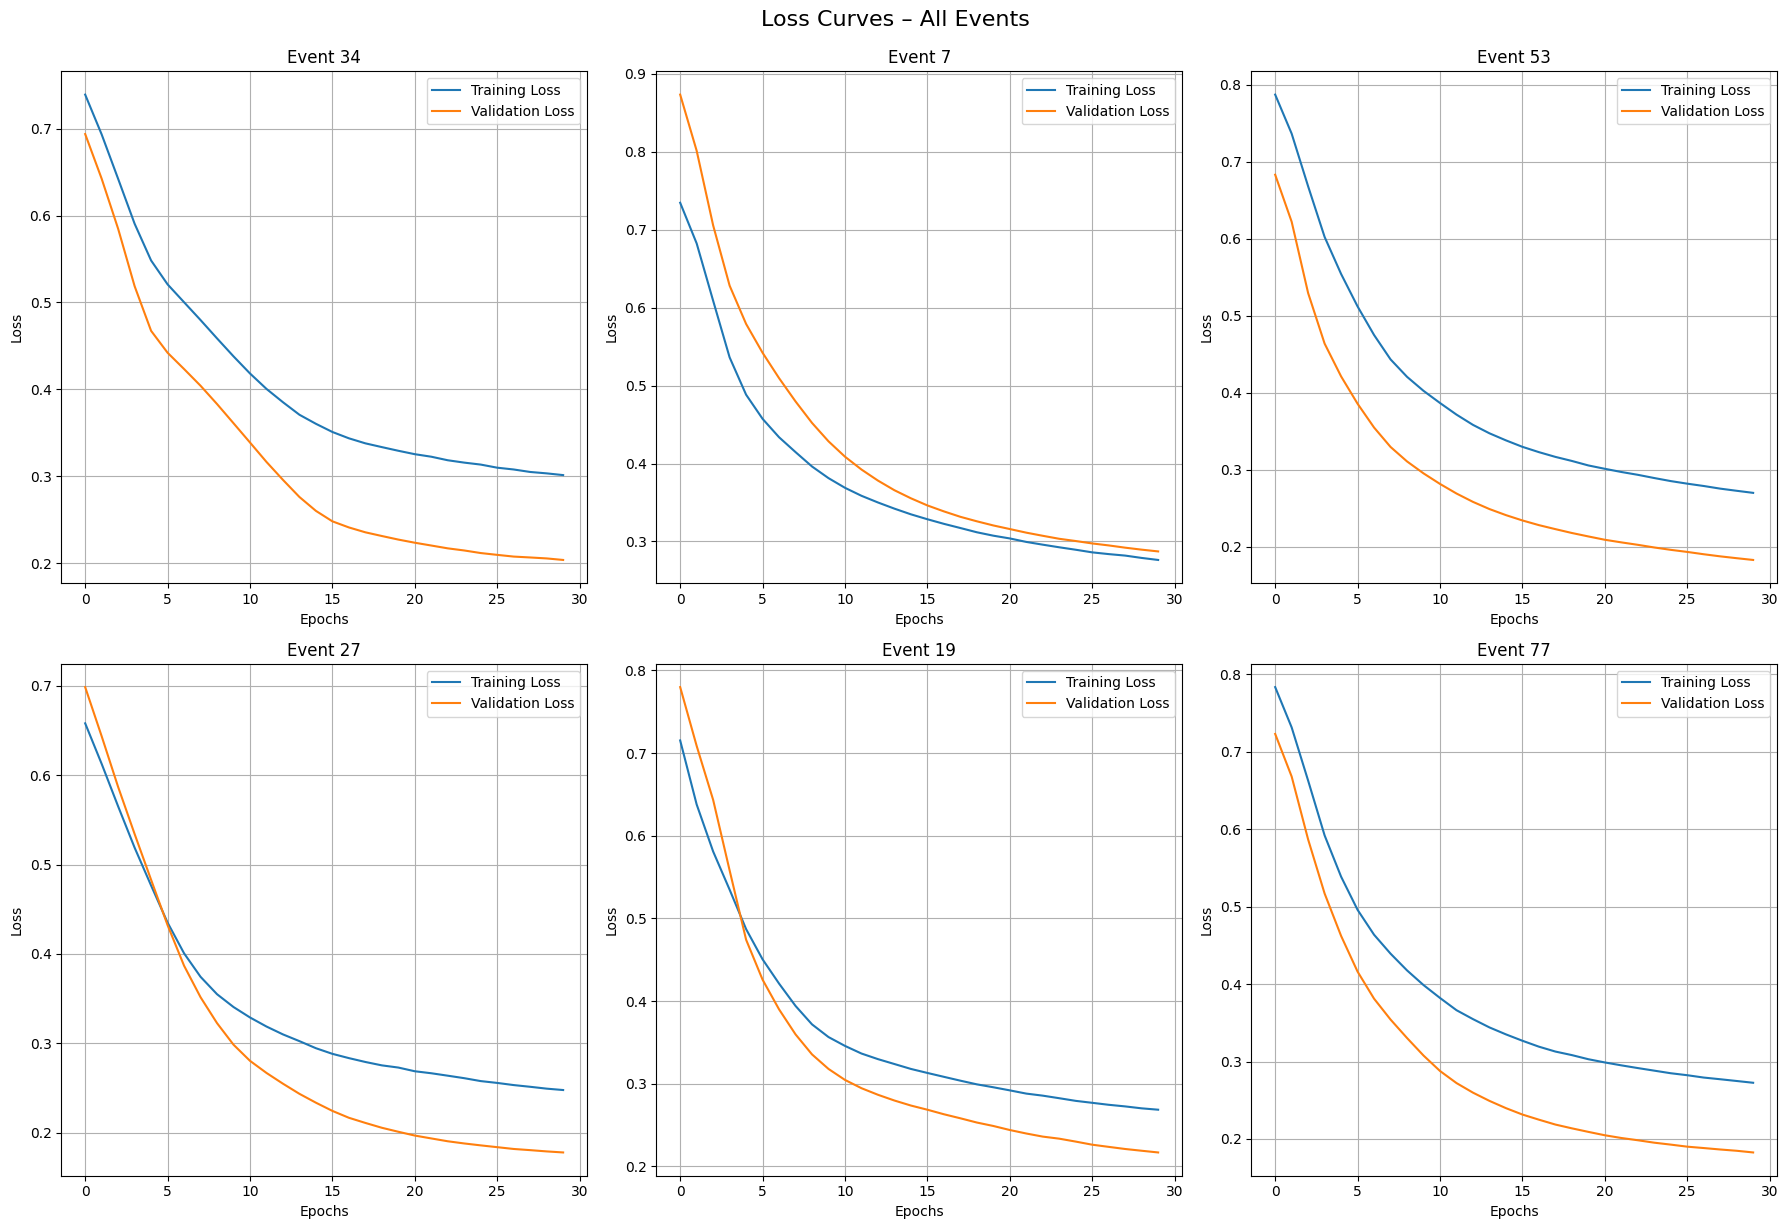

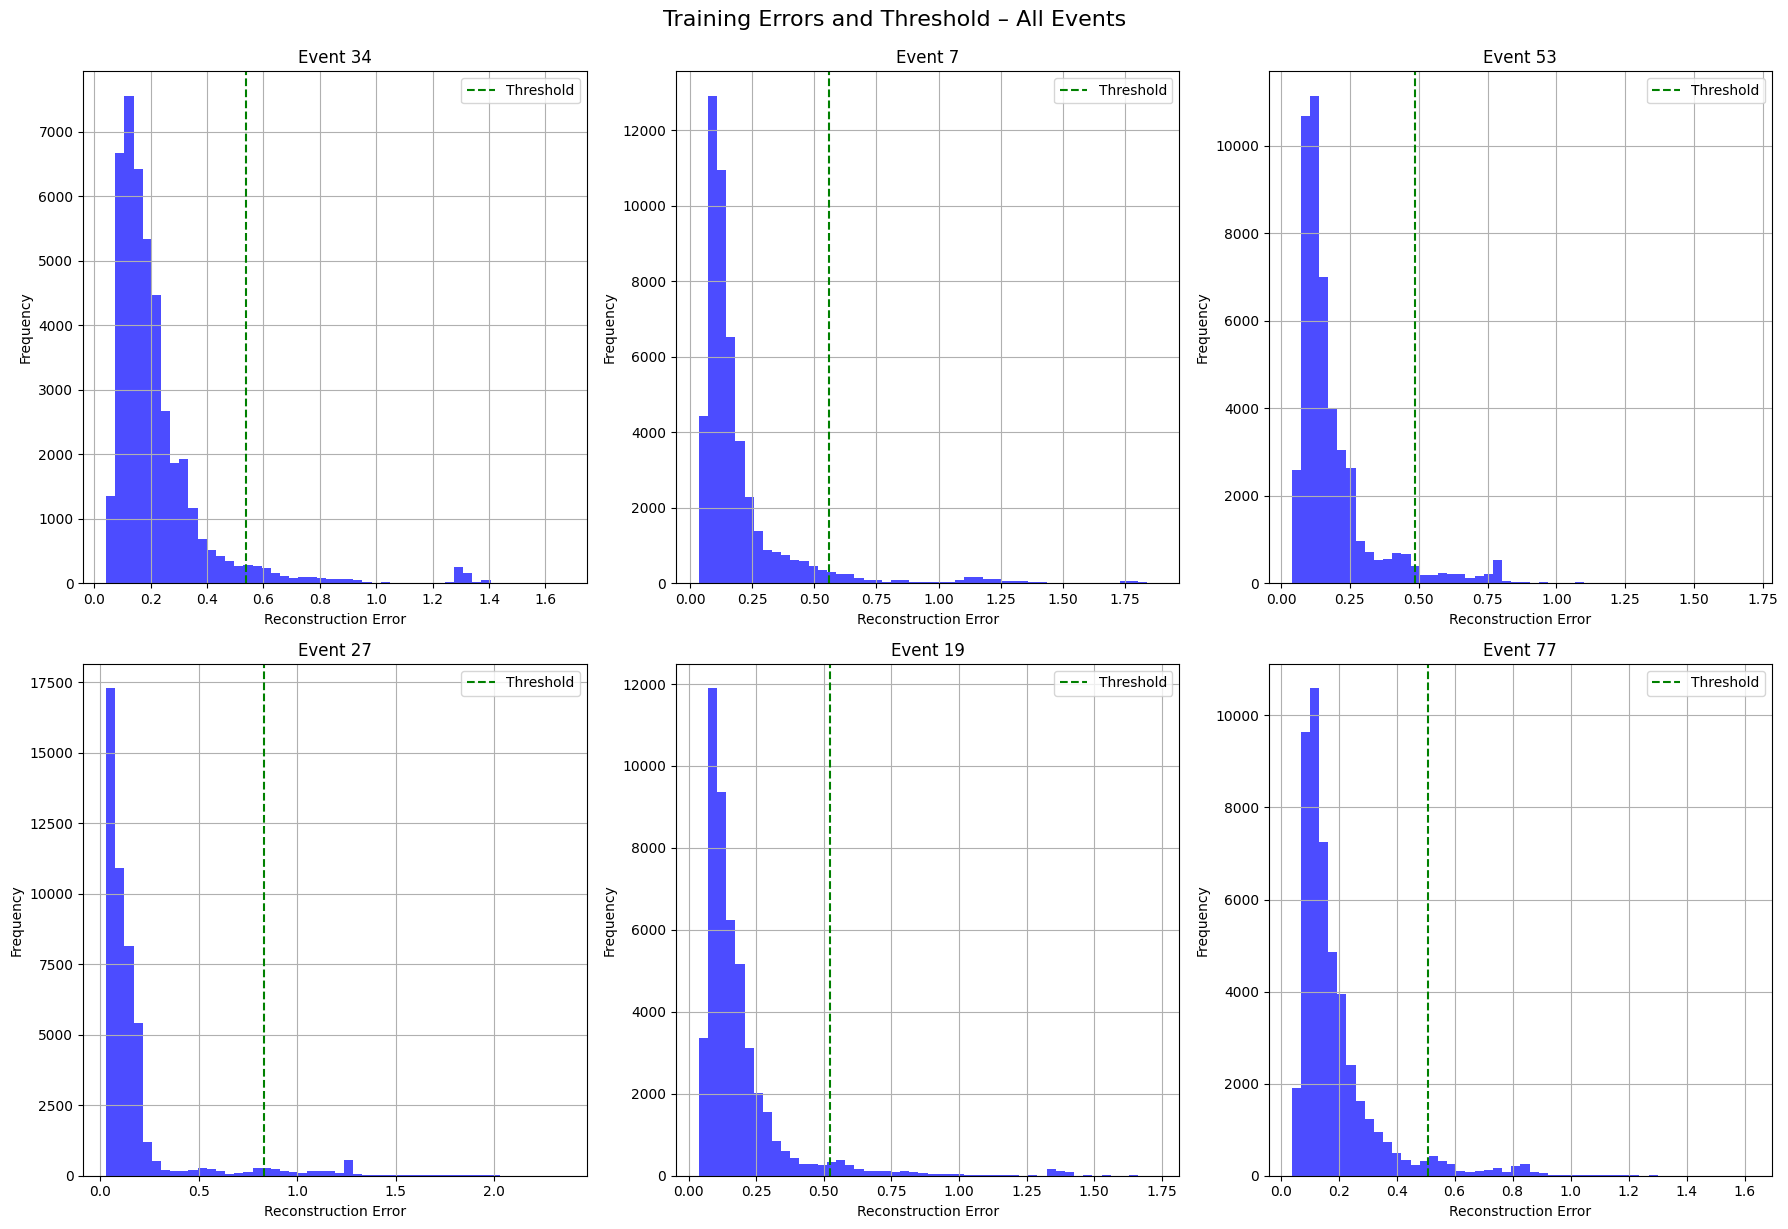

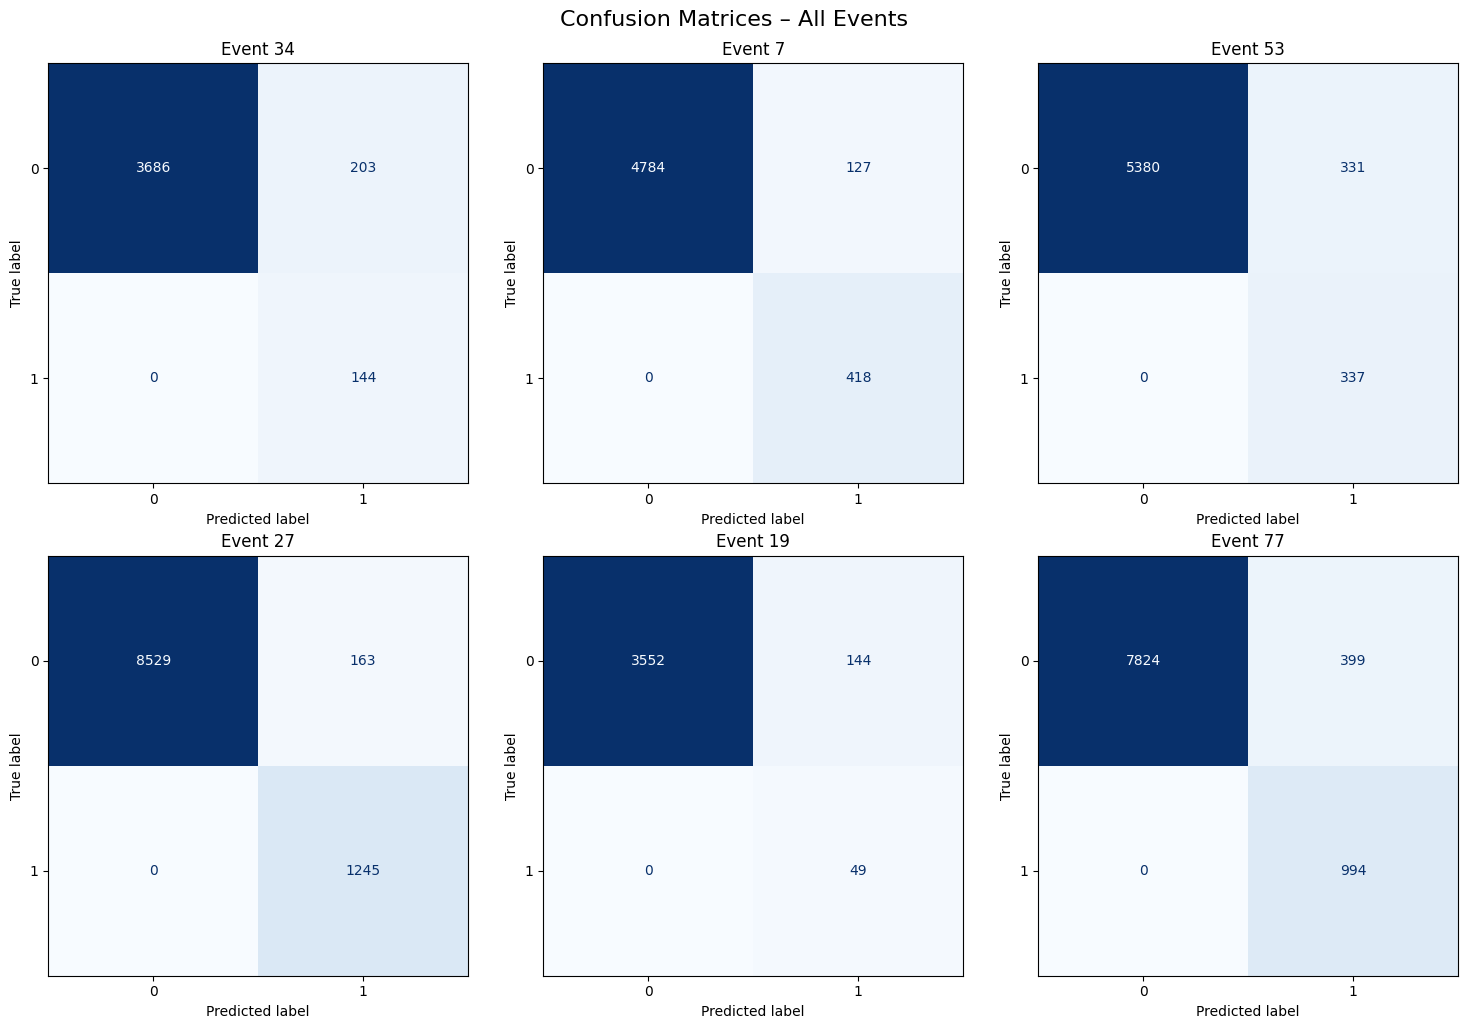

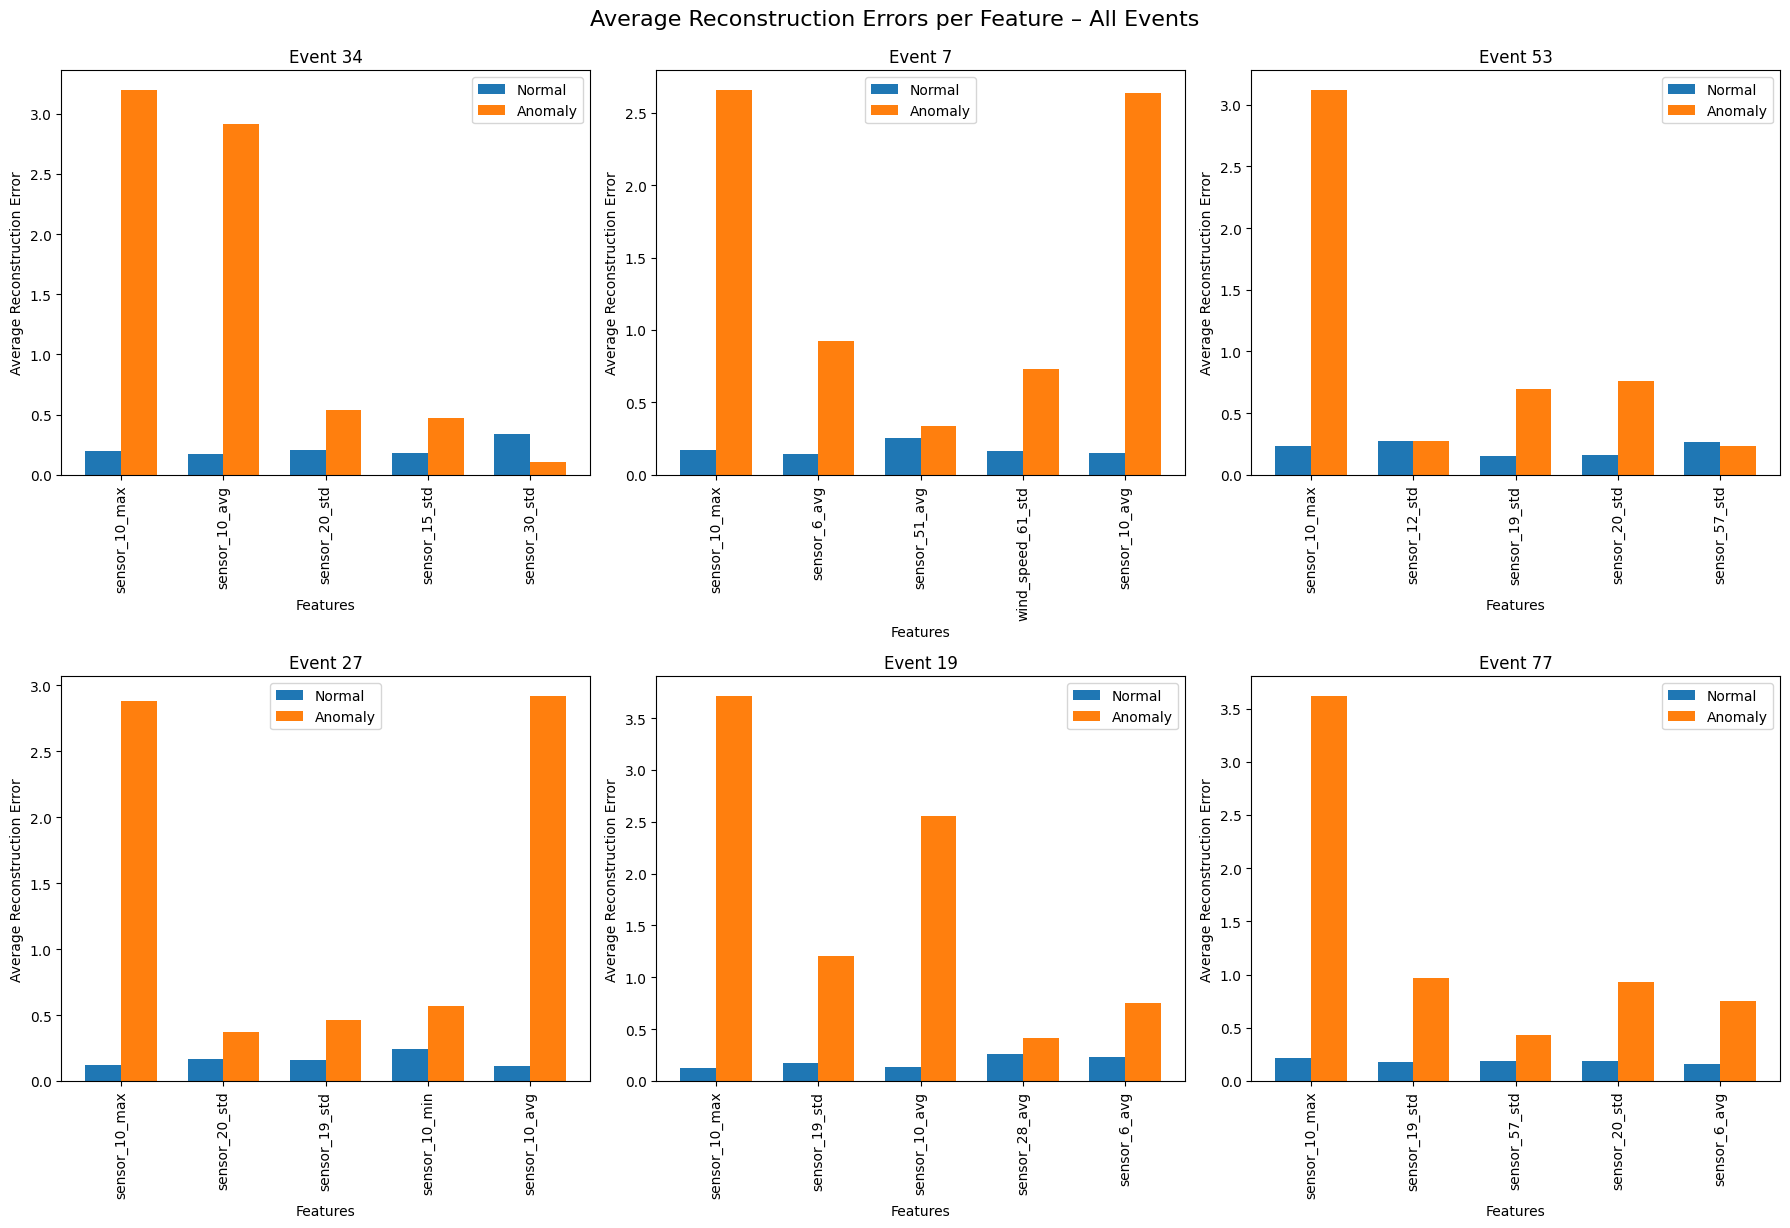

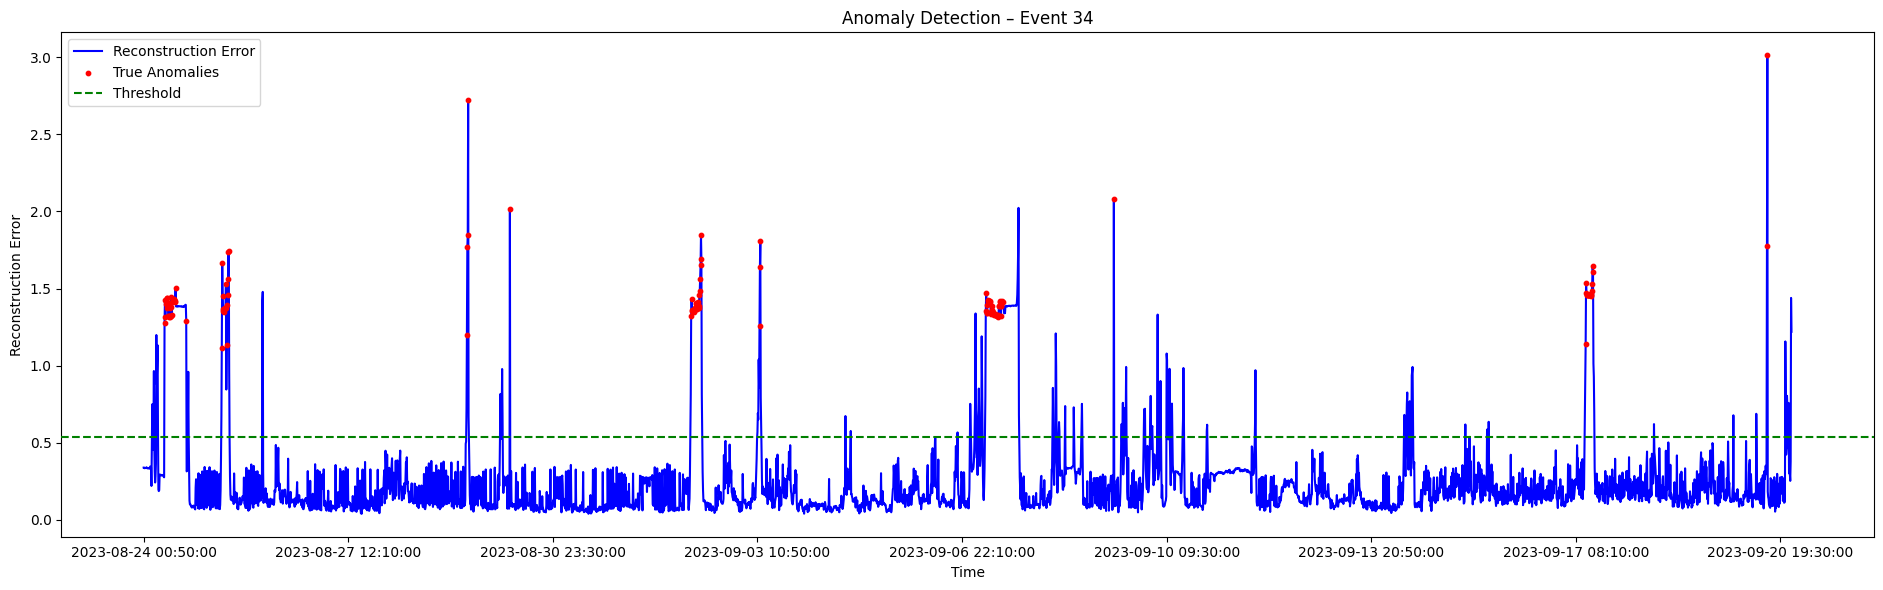

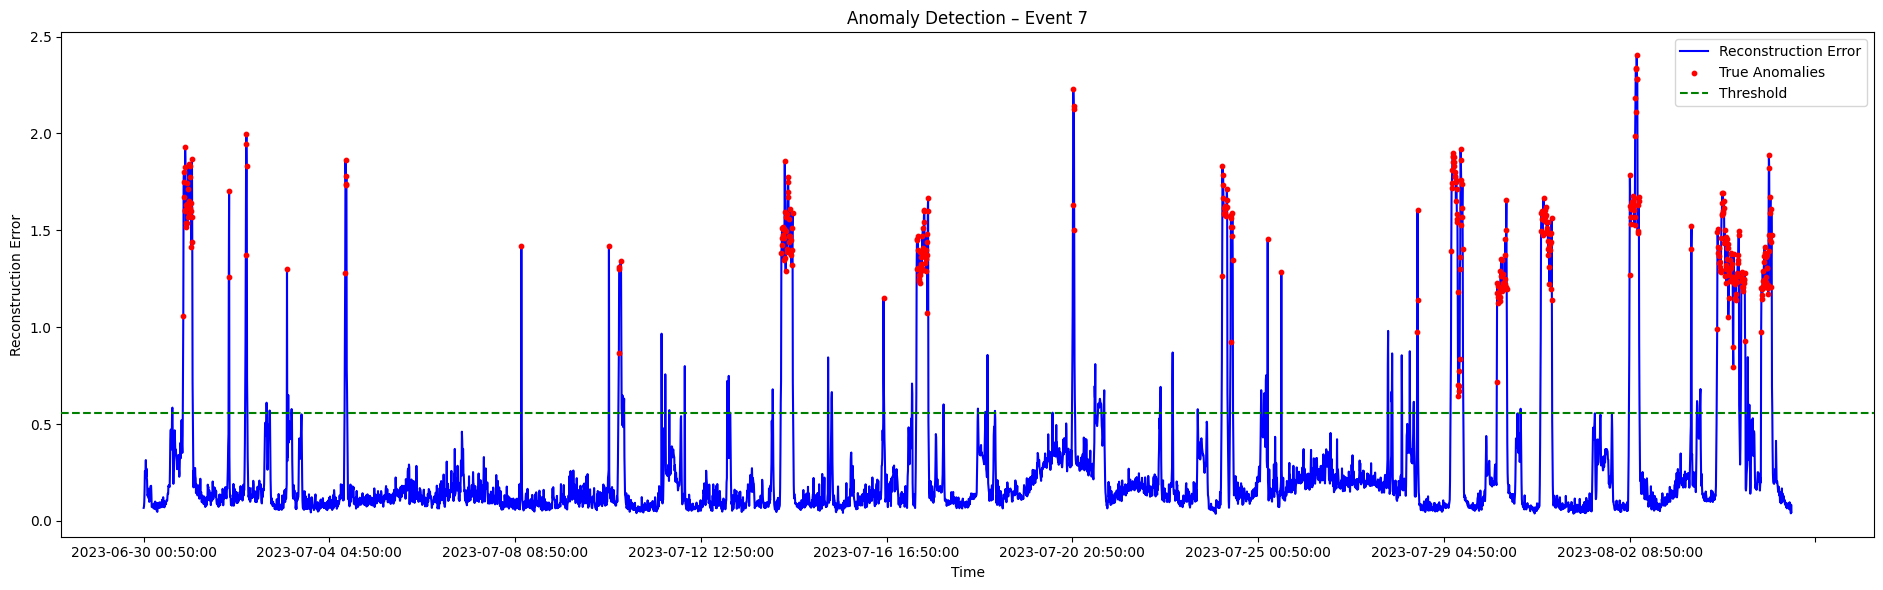

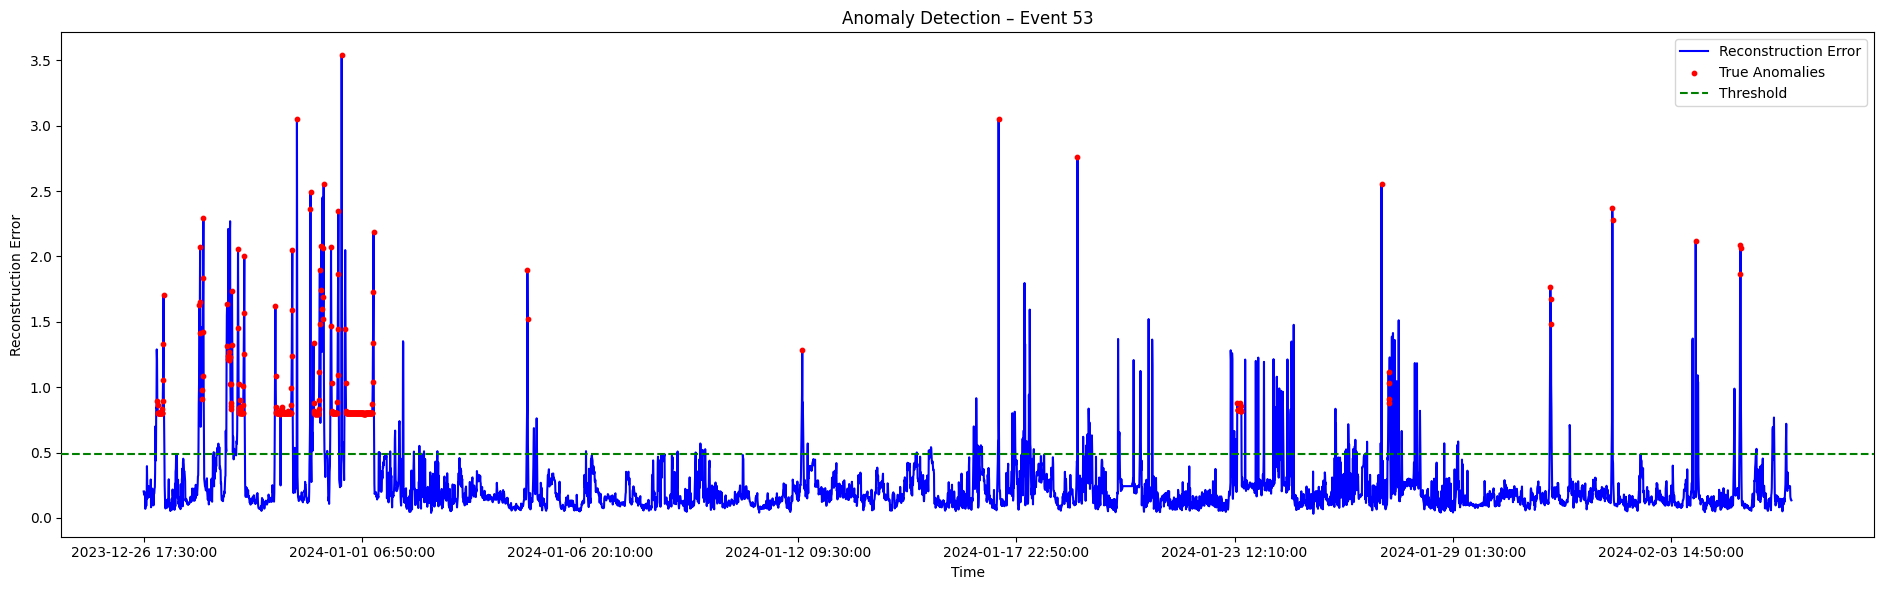

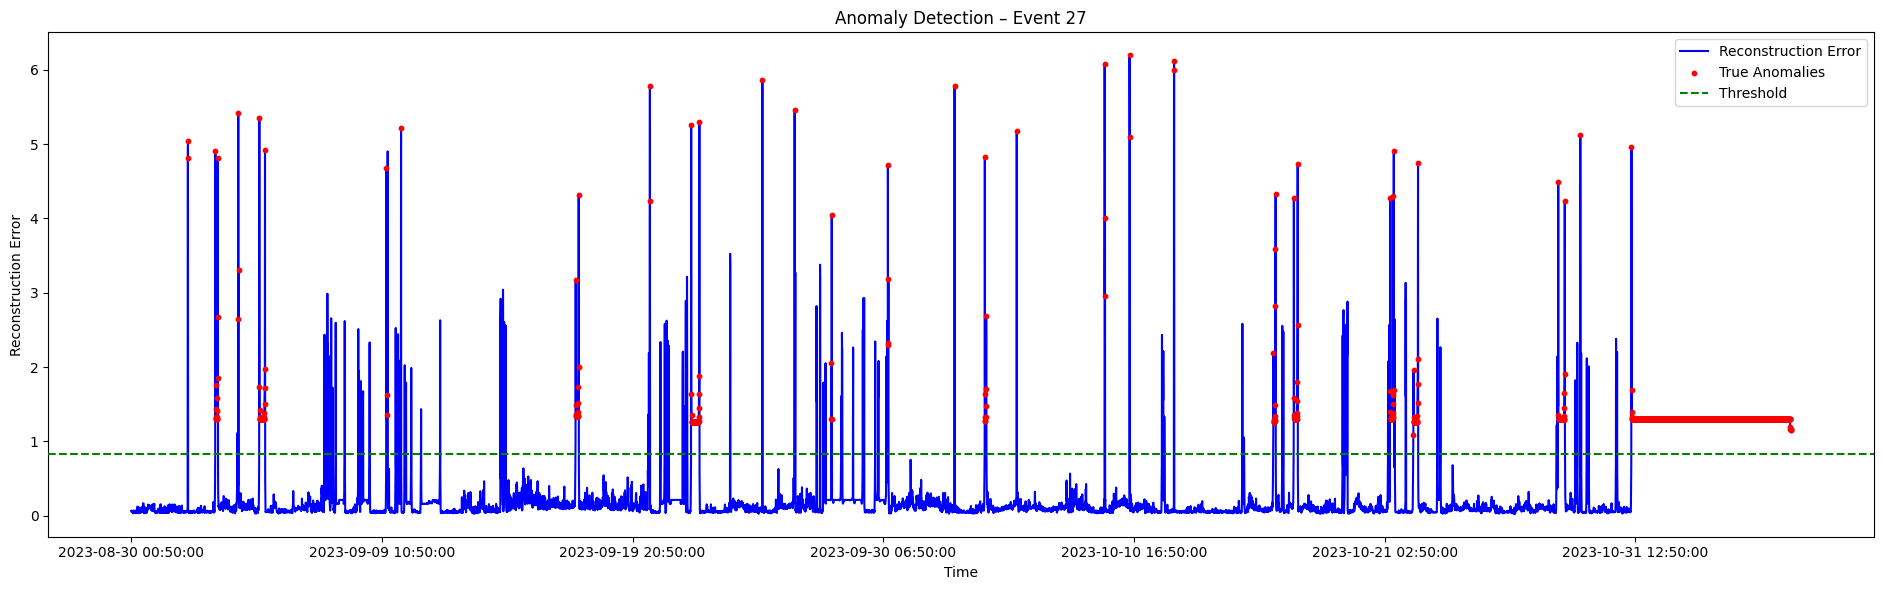

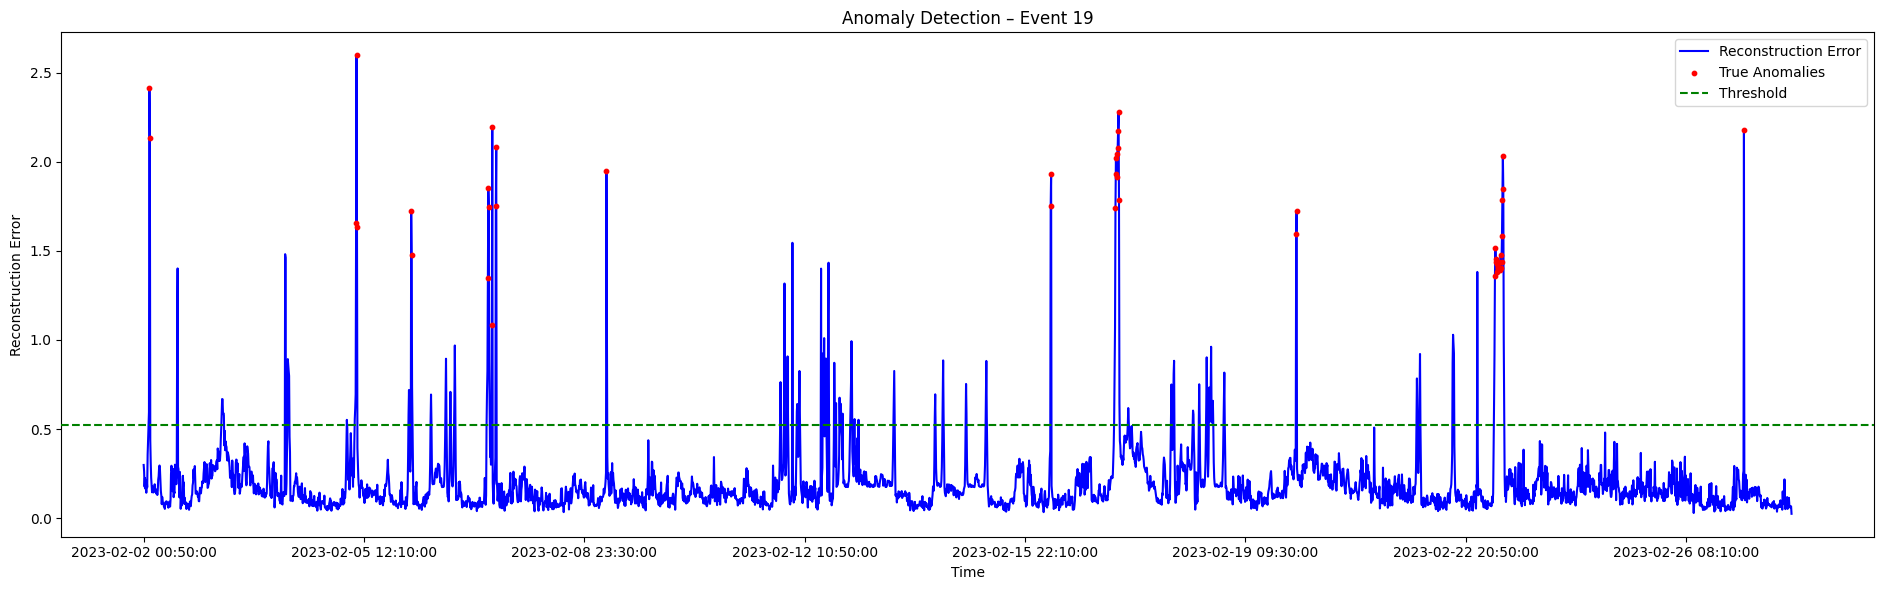

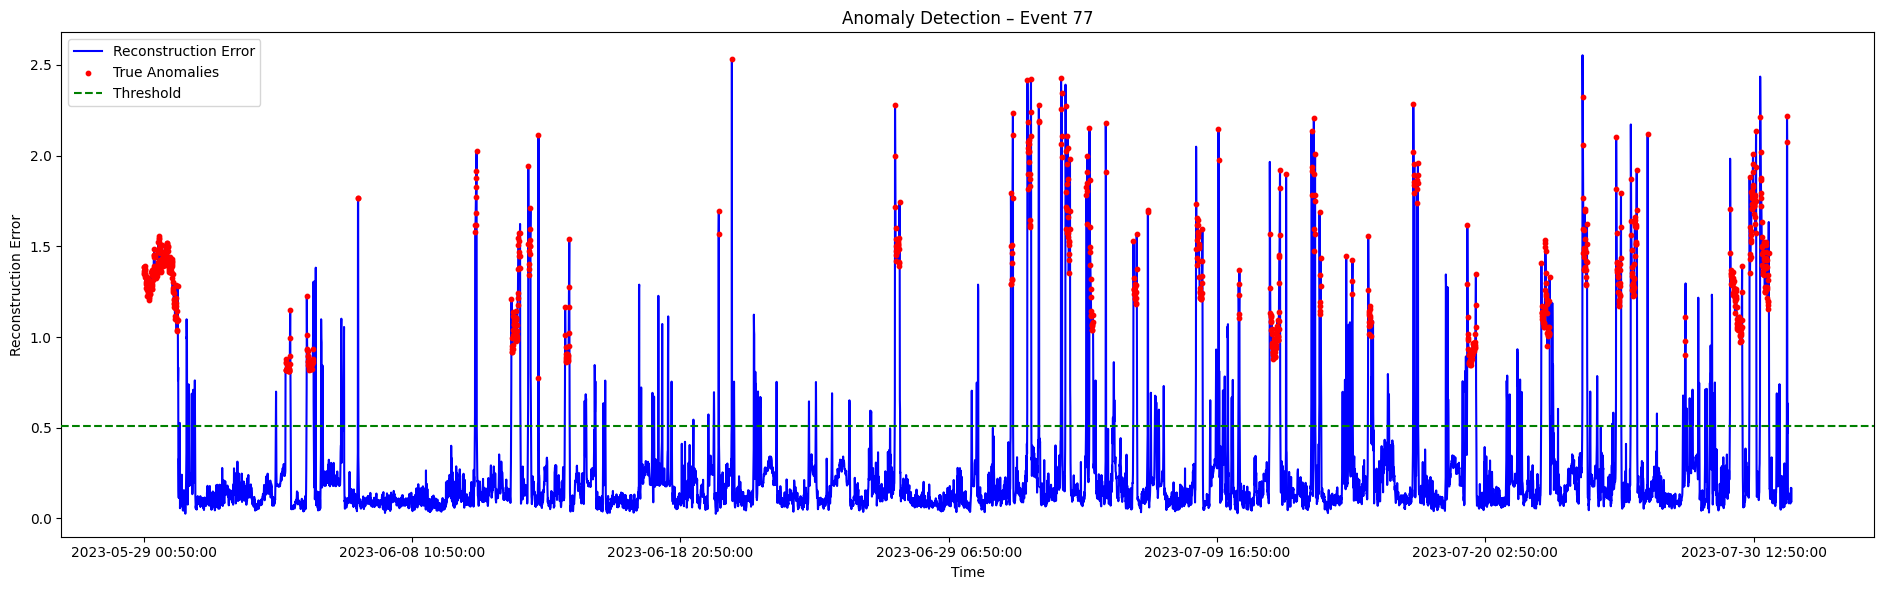

In [29]:
def create_sequences(data, timesteps):
    return np.array([data[i: i + timesteps] for i in range(len(data) - timesteps + 1)])


def create_sequences_with_indices(data, timesteps):
    sequences, index_map = [], []
    for i in range(len(data) - timesteps + 1):
        sequences.append(data[i: i + timesteps])
        index_map.append(list(range(i, i + timesteps)))
    return np.array(sequences), index_map


def safe_confusion_matrix(y_true, y_pred):
    labels = [0, 1]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if cm.shape == (1, 1):
        TN = cm[0, 0] if y_true[0] == 0 else 0
        FP = FN = TP = 0
    elif cm.shape == (1, 2):
        TN, FP = cm[0]
        FN = TP = 0
    elif cm.shape == (2, 1):
        TN = cm[0, 0]
        FN = cm[1, 0]
        FP = TP = 0
    else:
        TN, FP, FN, TP = cm.ravel()
    return TN, FP, FN, TP


datasets = {
    'Event 34': pd.read_csv('Wind Farm B/datasets/34.csv', sep=';'),
    'Event 7': pd.read_csv('Wind Farm B/datasets/7.csv', sep=';'),
    'Event 53': pd.read_csv('Wind Farm B/datasets/53.csv', sep=';'),
    'Event 27': pd.read_csv('Wind Farm B/datasets/27.csv', sep=';'),
    'Event 19': pd.read_csv('Wind Farm B/datasets/19.csv', sep=';'),
    'Event 77': pd.read_csv('Wind Farm B/datasets/77.csv', sep=';')
}

timesteps = 6
conf_matrices = {}
results = []
loss_curves = {}
histograms = {}
feature_errors_dict = {}
time_series_errors = {}

for event_name, df in datasets.items():
    print(f"\n{event_name}")

    df['label'] = df['status_type_id'].apply(lambda x: 0 if x in [0, 2] else 1)

    features = df.drop(columns=['train_test', 'status_type_id', 'asset_id', 'time_stamp', 'id'], errors='ignore')
    if 'label' not in features.columns:
        features['label'] = df['label']
    labels = features['label']
    features = features.drop(columns=['label'])

    selector = VarianceThreshold(threshold=0.2)
    selector.fit(features)
    features = features.loc[:, selector.get_support()]

    model = xgb.XGBClassifier(objective="binary:logistic")
    model.fit(features, labels)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(features)

    shap_importance = pd.DataFrame({
        'feature': features.columns,
        'mean_abs_shap': np.abs(shap_values).mean(axis=0)
    }).sort_values(by='mean_abs_shap', ascending=False)

    top_features = shap_importance.head(5)['feature'].values
    print("Selected features:", top_features)

    normal_train = df[(df['train_test'] == 'train') & (df['label'] == 0)]
    normal_train_filtered = normal_train[top_features]
    X_normal_train = normal_train_filtered

    scaler = StandardScaler()
    X_normal_train_scaled = scaler.fit_transform(X_normal_train)

    X_train_seq = create_sequences(X_normal_train_scaled, timesteps)
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], timesteps, X_normal_train_scaled.shape[1]))

    os.environ['PYTHONHASHSEED'] = '42'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

    input_shape = (timesteps, X_normal_train_scaled.shape[1])
    inputs = Input(shape=input_shape)
    encoded = LSTM(10, activation='tanh', return_sequences=False)(inputs)
    encoded = Dropout(0.2)(encoded)
    bottleneck = RepeatVector(timesteps)(encoded)
    decoded = LSTM(10, activation='tanh', return_sequences=True)(bottleneck)
    decoded = Dropout(0.2)(decoded)
    outputs = TimeDistributed(Dense(X_normal_train_scaled.shape[1], activation='linear'))(decoded)

    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer=Adam(0.0001), loss='mae')

    autoencoder.summary()

    history = autoencoder.fit(
        X_train_seq, X_train_seq,
        epochs=30, batch_size=256,
        validation_split=0.1, shuffle=True, verbose=1
    )

    loss_curves[event_name] = history.history

    reconstructed_train = autoencoder.predict(X_train_seq)

    row_errors = np.mean(np.abs(X_train_seq - reconstructed_train), axis=(1, 2))
    threshold = np.percentile(row_errors, 95)

    print(f"Reconstruction error threshold ({event_name}): {threshold:.6f}")

    histograms[event_name] = (row_errors, threshold)

    test = df[df['train_test'] == 'prediction']
    X_test = test[top_features]
    y_test = test['label'].values
    X_test_scaled = scaler.transform(X_test)

    X_test_seq, index_map = create_sequences_with_indices(X_test_scaled, timesteps)
    reconstructed_test = autoencoder.predict(X_test_seq)

    abs_errors = np.abs(reconstructed_test - X_test_seq)
    sample_errors = np.mean(abs_errors, axis=2)

    error_sum, error_count = defaultdict(float), defaultdict(int)
    for seq_idx, row_indices in enumerate(index_map):
        for t_idx, row_idx in enumerate(row_indices):
            error_sum[row_idx] += sample_errors[seq_idx, t_idx]
            error_count[row_idx] += 1

    row_errors_test = np.array([error_sum[i] / error_count[i] if error_count[i] > 0 else np.nan
                                for i in range(len(X_test_scaled))])
    predicted_labels = (row_errors_test > threshold).astype(int)

    valid_mask = ~np.isnan(row_errors_test)
    y_true, y_pred = y_test[valid_mask], predicted_labels[valid_mask]

    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred, zero_division=0) * 100
    rec = recall_score(y_true, y_pred, zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, zero_division=0) * 100
    TN, FP, FN, TP = safe_confusion_matrix(y_true, y_pred)
    far = (FP / (FP + TN) * 100) if (FP + TN) > 0 else 0

    results.append({
        'Event': event_name,
        'Accuracy': round(acc, 2),
        'Precision': round(prec, 2),
        'Recall': round(rec, 2),
        'F1': round(f1, 2),
        'FAR': round(far, 2)
    })

    conf_matrices[event_name] = np.array([[TN, FP], [FN, TP]])

    num_features = abs_errors.shape[2]
    num_samples = len(X_test_scaled)

    error_sum_per_feature = defaultdict(lambda: np.zeros(num_features))
    error_count_per_feature = defaultdict(int)

    for seq_idx, row_indices in enumerate(index_map):
        for t_idx, row_idx in enumerate(row_indices):
            error_sum_per_feature[row_idx] += abs_errors[seq_idx, t_idx]
            error_count_per_feature[row_idx] += 1

    feature_errors_per_sample = np.zeros((num_samples, num_features))

    for i in range(num_samples):
        if error_count_per_feature[i] > 0:
            feature_errors_per_sample[i] = error_sum_per_feature[i] / error_count_per_feature[i]
        else:
            feature_errors_per_sample[i] = np.nan

    feature_errors_valid = feature_errors_per_sample[valid_mask]
    y_true_valid = y_true
    y_pred_valid = y_pred

    normal_errors = feature_errors_valid[y_true_valid == 0]
    anomaly_errors = feature_errors_valid[y_true_valid == 1]

    avg_normal_errors = np.nanmean(normal_errors, axis=0)
    avg_anomaly_errors = np.nanmean(anomaly_errors, axis=0)

    feature_errors_dict[event_name] = (top_features, avg_normal_errors, avg_anomaly_errors)

    test = df[df['train_test'] == 'prediction']
    test_data = test[timesteps - 1:]
    timestamps = test_data['time_stamp'].values
    y_true_aligned = y_true[timesteps - 1:]
    y_pred_aligned = y_pred[timesteps - 1:]
    row_errors_aligned = row_errors_test[timesteps - 1:]

    time_series_errors[event_name] = (row_errors_aligned, threshold, y_true_aligned, y_pred_aligned, timestamps)


results_df = pd.DataFrame(results)
results_df.loc['Average'] = results_df.mean(numeric_only=True).round(2)

print("\nAnomaly Detection Results for All Events: LSTM Autoencoder (removing low-variance features) (%):\n")
print(results_df)

print()


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for ax, (event_name, hist) in zip(axes, loss_curves.items()):
    ax.plot(hist['loss'], label='Training Loss')
    ax.plot(hist['val_loss'], label='Validation Loss')
    ax.set_title(event_name)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
fig.suptitle("Loss Curves – All Events", fontsize=16, y=1.02)
plt.show()


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for ax, (event_name, (errors, threshold)) in zip(axes, histograms.items()):
    ax.hist(errors, bins=50, color="blue", alpha=0.7)
    ax.axvline(x=threshold, color="green", linestyle="--", label="Threshold")
    ax.set_title(event_name)
    ax.set_xlabel("Reconstruction Error")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.grid(True)
plt.tight_layout()
fig.suptitle("Training Errors and Threshold – All Events", fontsize=16, y=1.02)
plt.show()


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
labels = [0, 1]
for ax, (event_name, cm) in zip(axes.flatten(), conf_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax, colorbar=False)
    ax.set_title(event_name)
plt.tight_layout()
fig.suptitle("Confusion Matrices – All Events", fontsize=16, y=1.02)
plt.show()


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for ax, (event_name, (top_features, avg_normal_errors, avg_anomaly_errors)) in zip(axes, feature_errors_dict.items()):
    x = np.arange(len(top_features))
    width = 0.35
    ax.bar(x - width/2, avg_normal_errors, width, label='Normal')
    ax.bar(x + width/2, avg_anomaly_errors, width, label='Anomaly')
    ax.set_xlabel('Features')
    ax.set_ylabel('Average Reconstruction Error')
    ax.set_xticks(x)
    ax.set_xticklabels(top_features, rotation=90)
    ax.legend()
    ax.set_title(event_name)
plt.tight_layout()
fig.suptitle("Average Reconstruction Errors per Feature – All Events", fontsize=16, y=1.02)
plt.show()


for event_name, (row_errors_aligned, threshold, y_true_aligned, y_pred_aligned, timestamps) in time_series_errors.items():
    plt.figure(figsize=(19, 6))
    anomalies = (y_true_aligned == 1)
    plt.plot(timestamps, row_errors_aligned, label="Reconstruction Error", color="blue", zorder=2)
    plt.scatter(timestamps[anomalies], row_errors_aligned[anomalies],
                color="red", label="True Anomalies", s=10, zorder=5)
    plt.axhline(y=threshold, color="green", linestyle="--", label="Threshold", zorder=3)
    plt.xlabel("Time")
    plt.ylabel("Reconstruction Error")
    plt.title(f"Anomaly Detection – {event_name}")
    plt.legend()
    plt.tight_layout()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))
    plt.show()


### Bi-LSTM Autoencoder

#### Without Removing Low-Variance Features


Event 34
Selected features: ['sensor_10_max' 'reactive_power_11_std' 'sensor_10_avg' 'sensor_20_std'
 'sensor_15_std']


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 20)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_12 (RepeatVector) │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 6, 20)          │         2,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 6, 5)           │           105 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,865 (15.10 KB)

 Trainable params: 3,865 (15.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.7349 - val_loss: 0.7775
Epoch 2/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6372 - val_loss: 0.6655
Epoch 3/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5316 - val_loss: 0.5767
Epoch 4/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4547 - val_loss: 0.5118
Epoch 5/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4057 - val_loss: 0.4716
Epoch 6/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3702 - val_loss: 0.4301
Epoch 7/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3373 - val_loss: 0.3889
Epoch 8/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3112 - val_loss: 0.3572
Epoch 9/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2931 - val_loss: 0.3338
Epoch 10/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2798 - val_loss: 0.3145
Epoch 11/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2704 - val_loss: 0.2996
Epoch 12/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 20)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_13 (RepeatVector) │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 6, 20)          │         2,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 6, 5)           │           105 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,865 (15.10 KB)

 Trainable params: 3,865 (15.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.6147 - val_loss: 0.6725
Epoch 2/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5162 - val_loss: 0.5624
Epoch 3/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4132 - val_loss: 0.4594
Epoch 4/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3405 - val_loss: 0.3956
Epoch 5/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3093 - val_loss: 0.3701
Epoch 6/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2935 - val_loss: 0.3579
Epoch 7/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2823 - val_loss: 0.3494
Epoch 8/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2736 - val_loss: 0.3432
Epoch 9/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2662 - val_loss: 0.3378
Epoch 10/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2598 - val_loss: 0.3325
Epoch 11/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2544 - val_loss: 0.3264
Epoch 12/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 20)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_14 (RepeatVector) │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 6, 20)          │         2,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 6, 5)           │           105 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,865 (15.10 KB)

 Trainable params: 3,865 (15.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.7963 - val_loss: 0.6360
Epoch 2/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6781 - val_loss: 0.4816
Epoch 3/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5387 - val_loss: 0.3520
Epoch 4/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.4355 - val_loss: 0.2891
Epoch 5/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3688 - val_loss: 0.2525
Epoch 6/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3325 - val_loss: 0.2296
Epoch 7/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3071 - val_loss: 0.2126
Epoch 8/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2887 - val_loss: 0.2002
Epoch 9/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2768 - val_loss: 0.1906
Epoch 10/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2675 - val_loss: 0.1833
Epoch 11/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2601 - val_loss: 0.1777
Epoch 12/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 20)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_15 (RepeatVector) │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 6, 20)          │         2,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 6, 5)           │           105 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,865 (15.10 KB)

 Trainable params: 3,865 (15.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.7918 - val_loss: 0.6575
Epoch 2/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6563 - val_loss: 0.5020
Epoch 3/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4903 - val_loss: 0.3680
Epoch 4/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3877 - val_loss: 0.2702
Epoch 5/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3365 - val_loss: 0.2159
Epoch 6/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3077 - val_loss: 0.1863
Epoch 7/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2910 - val_loss: 0.1712
Epoch 8/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2801 - val_loss: 0.1633
Epoch 9/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.2719 - val_loss: 0.1590
Epoch 10/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2654 - val_loss: 0.1567
Epoch 11/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2591 - val_loss: 0.1545
Epoch 12/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 20)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_16 (RepeatVector) │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 6, 20)          │         2,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 6, 5)           │           105 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,865 (15.10 KB)

 Trainable params: 3,865 (15.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8285 - val_loss: 0.7477
Epoch 2/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7298 - val_loss: 0.6076
Epoch 3/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6064 - val_loss: 0.4922
Epoch 4/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5138 - val_loss: 0.4182
Epoch 5/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4607 - val_loss: 0.3660
Epoch 6/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4230 - val_loss: 0.3252
Epoch 7/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3942 - val_loss: 0.2968
Epoch 8/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3738 - val_loss: 0.2777
Epoch 9/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3606 - val_loss: 0.2649
Epoch 10/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3518 - val_loss: 0.2574
Epoch 11/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3444 - val_loss: 0.2504
Epoch 12/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 20)             │         1,280 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_17 (RepeatVector) │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 6, 20)          │         2,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 6, 5)           │           105 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,865 (15.10 KB)

 Trainable params: 3,865 (15.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.7839 - val_loss: 0.6549
Epoch 2/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6499 - val_loss: 0.4873
Epoch 3/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.4928 - val_loss: 0.3567
Epoch 4/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4055 - val_loss: 0.2953
Epoch 5/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3632 - val_loss: 0.2580
Epoch 6/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3332 - val_loss: 0.2293
Epoch 7/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3117 - val_loss: 0.2105
Epoch 8/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2976 - val_loss: 0.1988
Epoch 9/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2877 - val_loss: 0.1912
Epoch 10/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2801 - val_loss: 0.1858
Epoch 11/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.2734 - val_loss: 0.1818
Epoch 12/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 

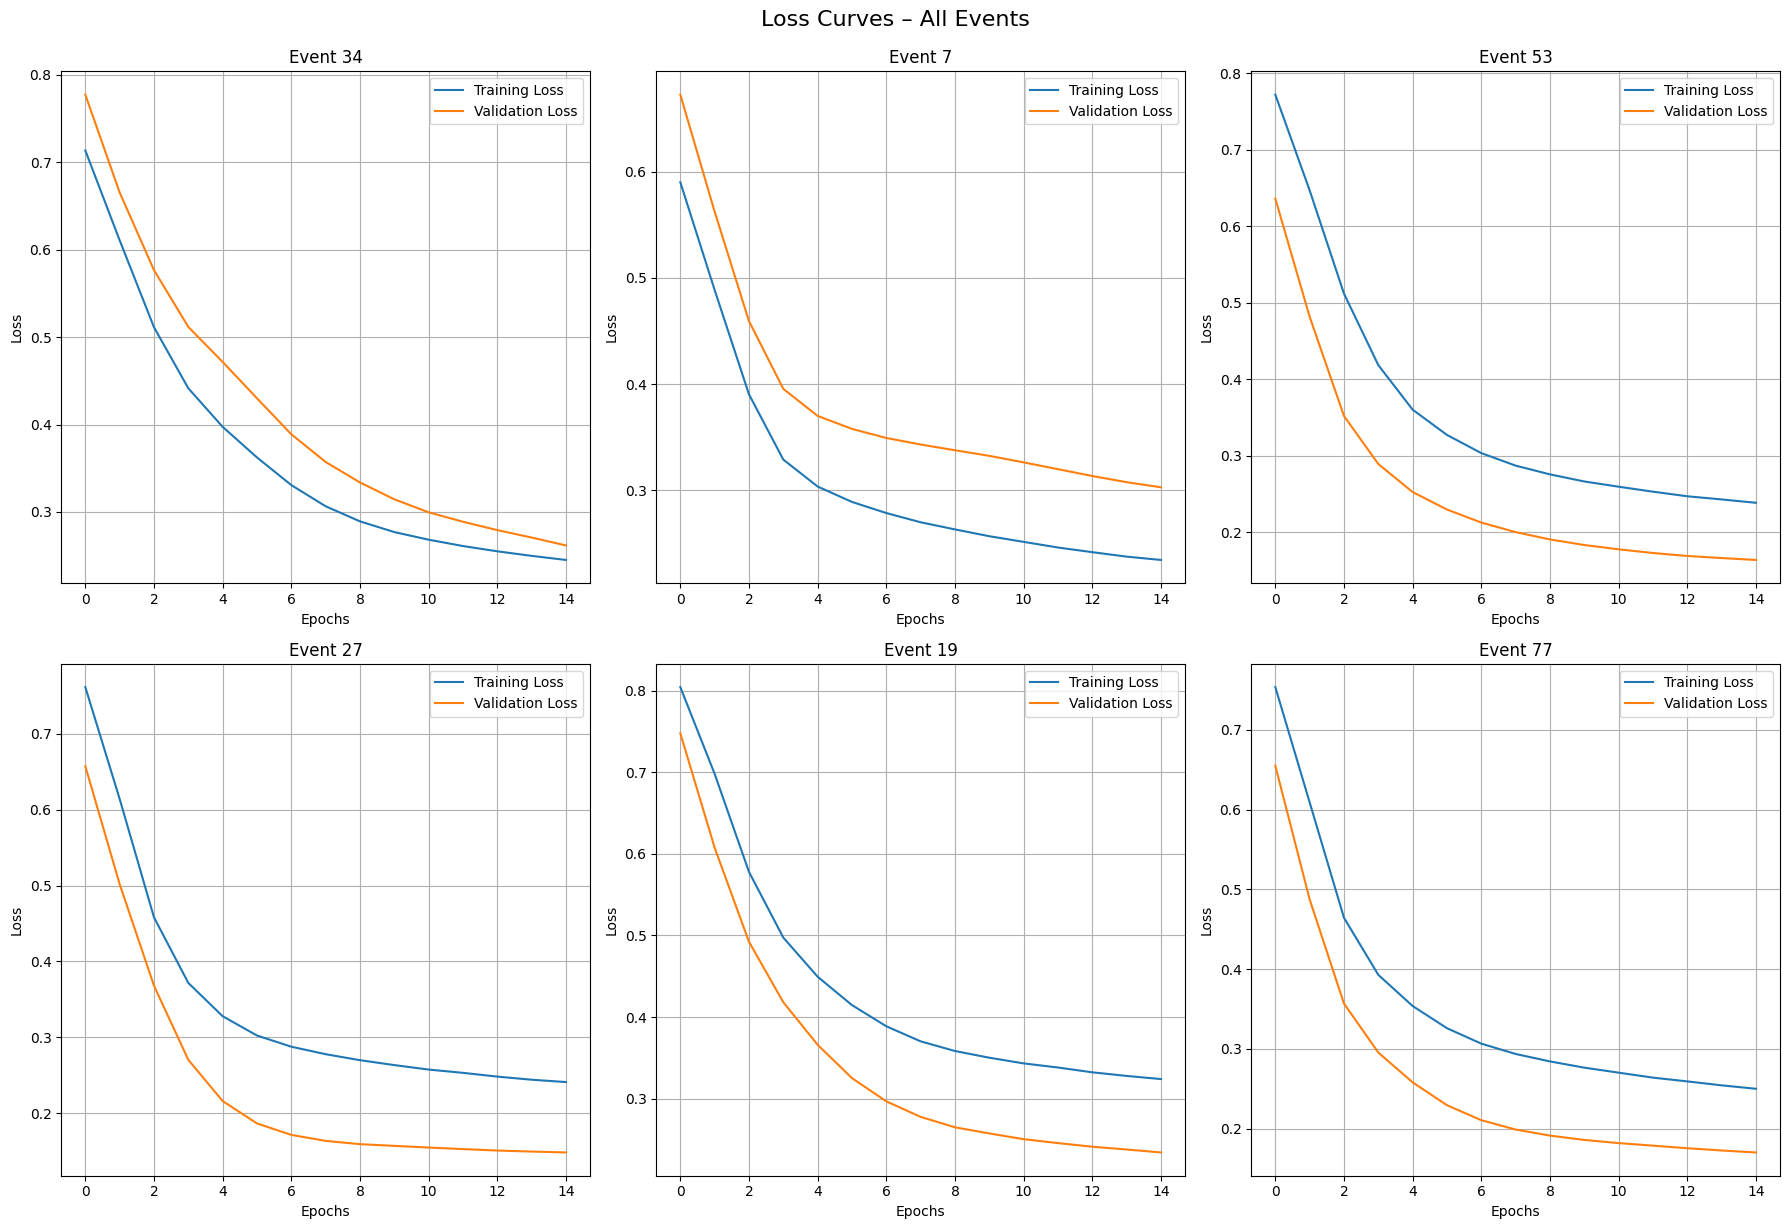

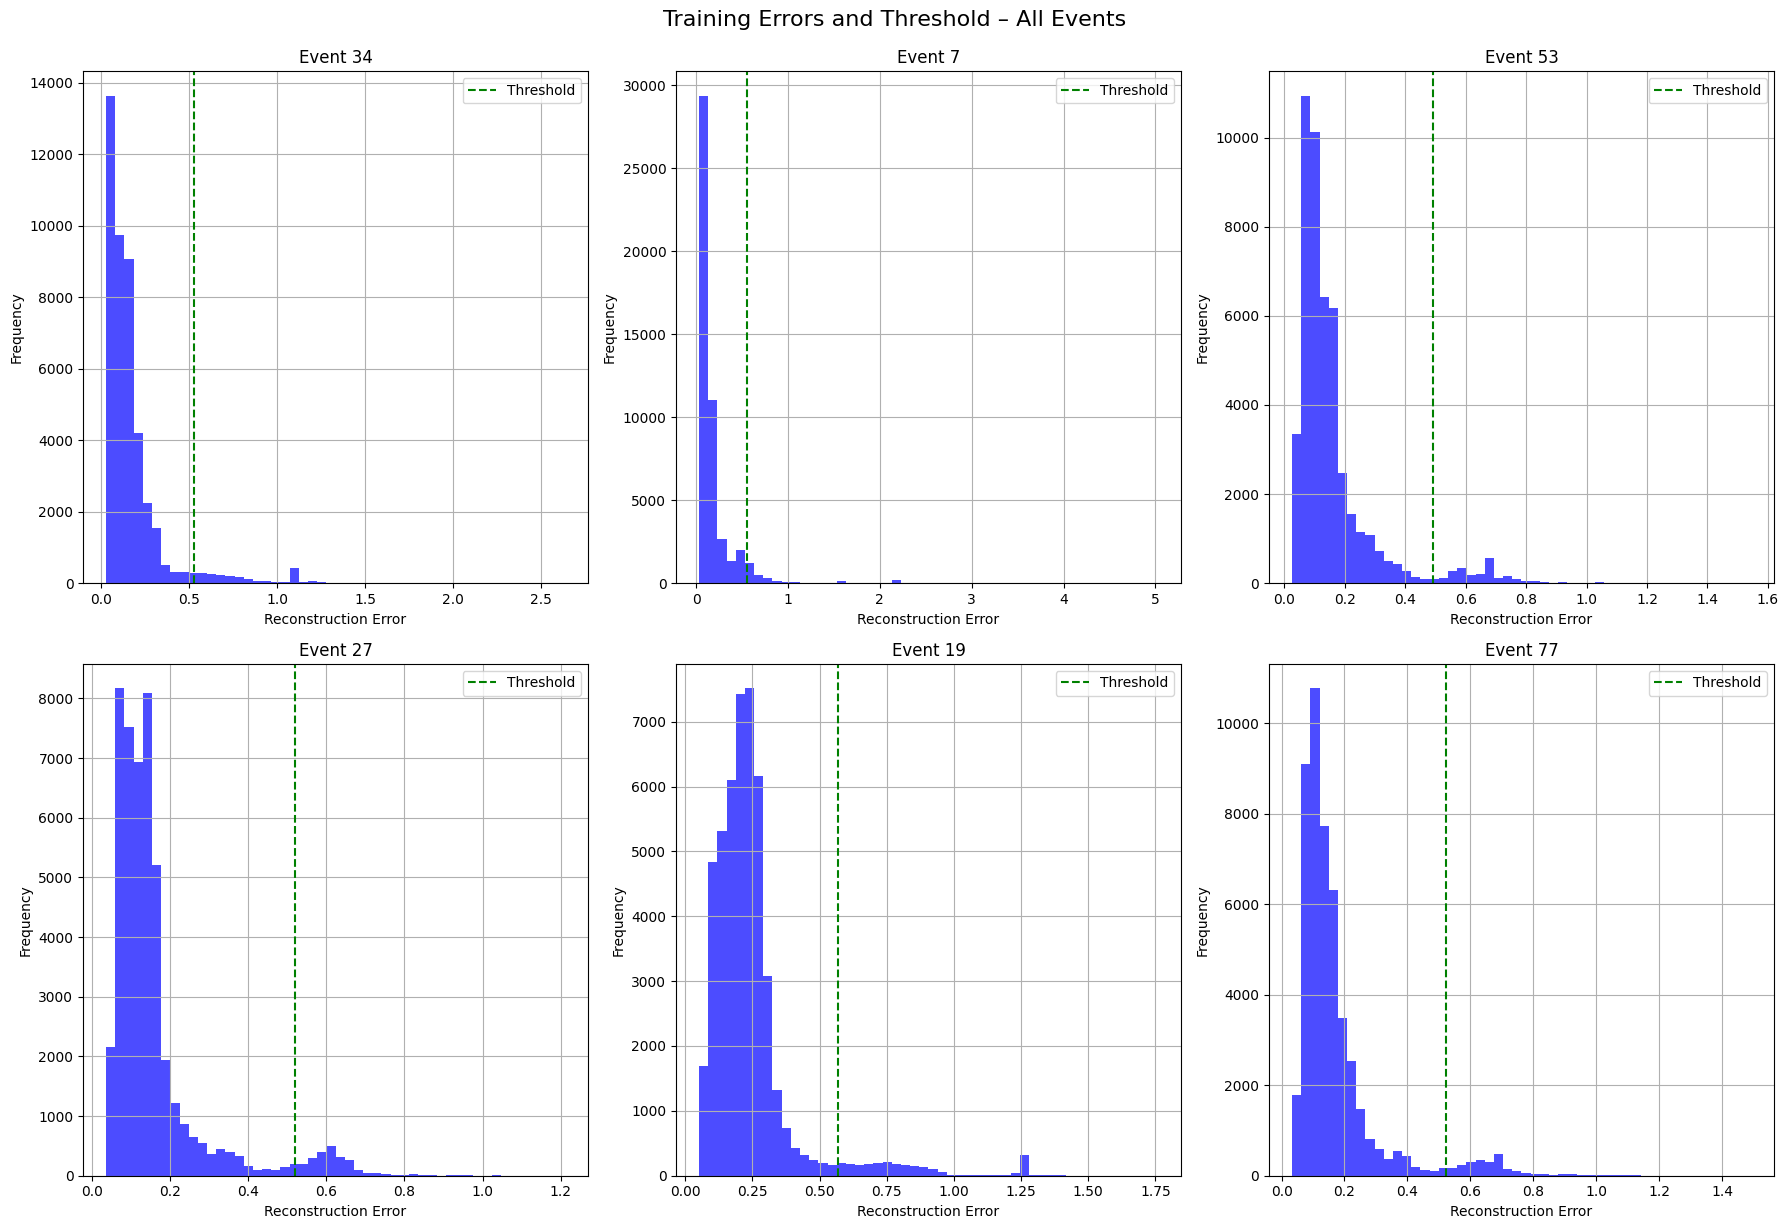

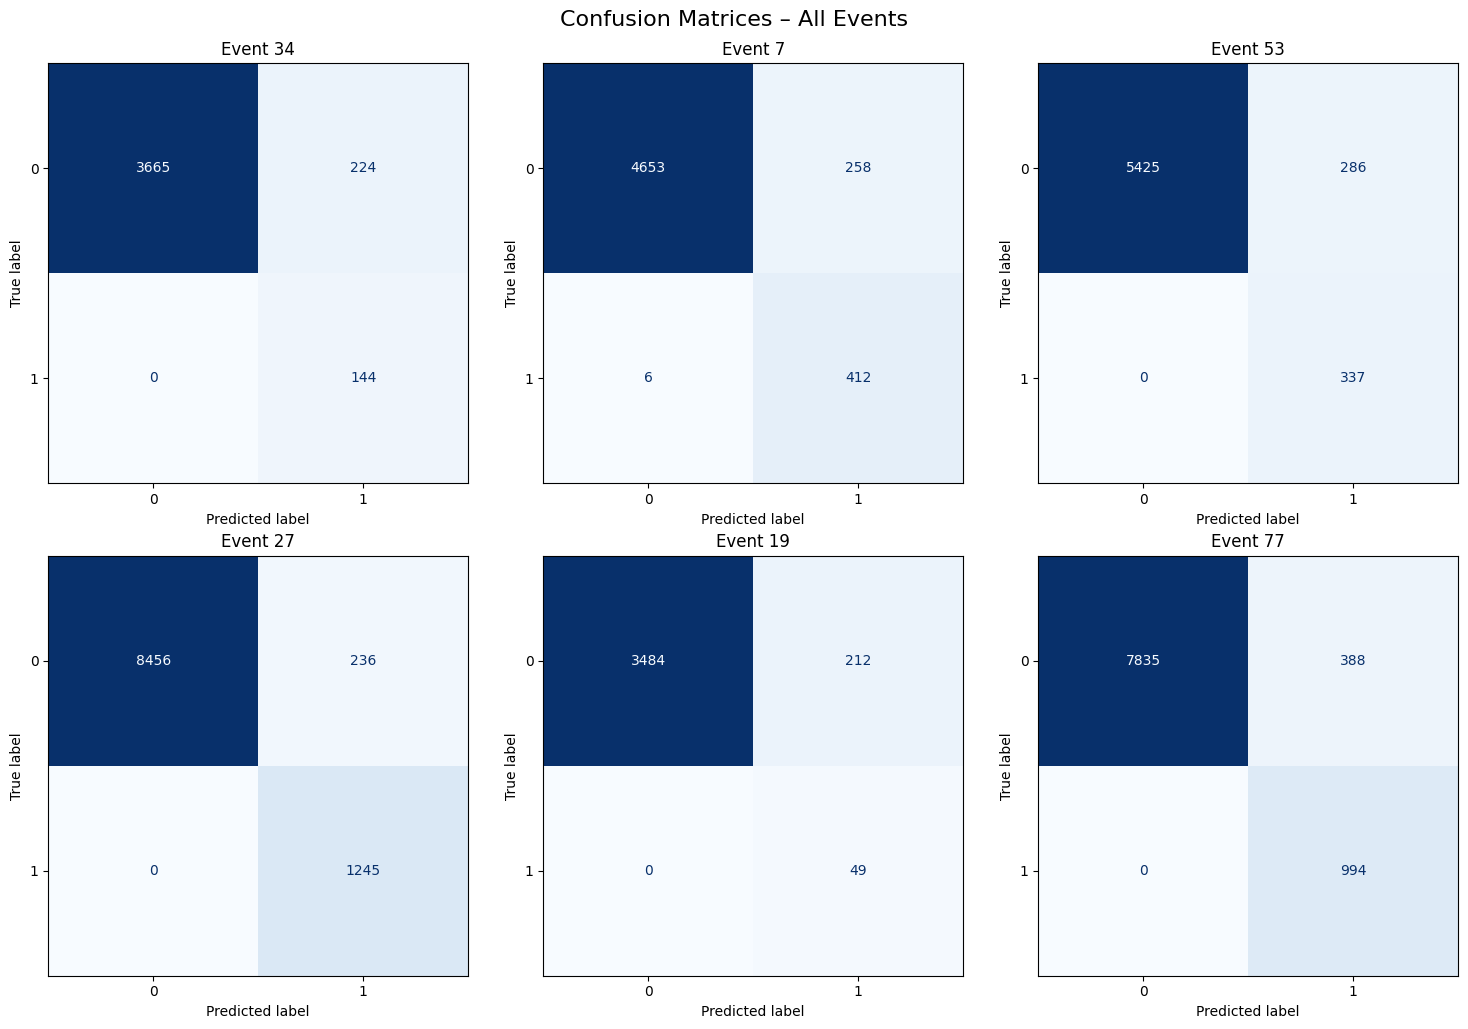

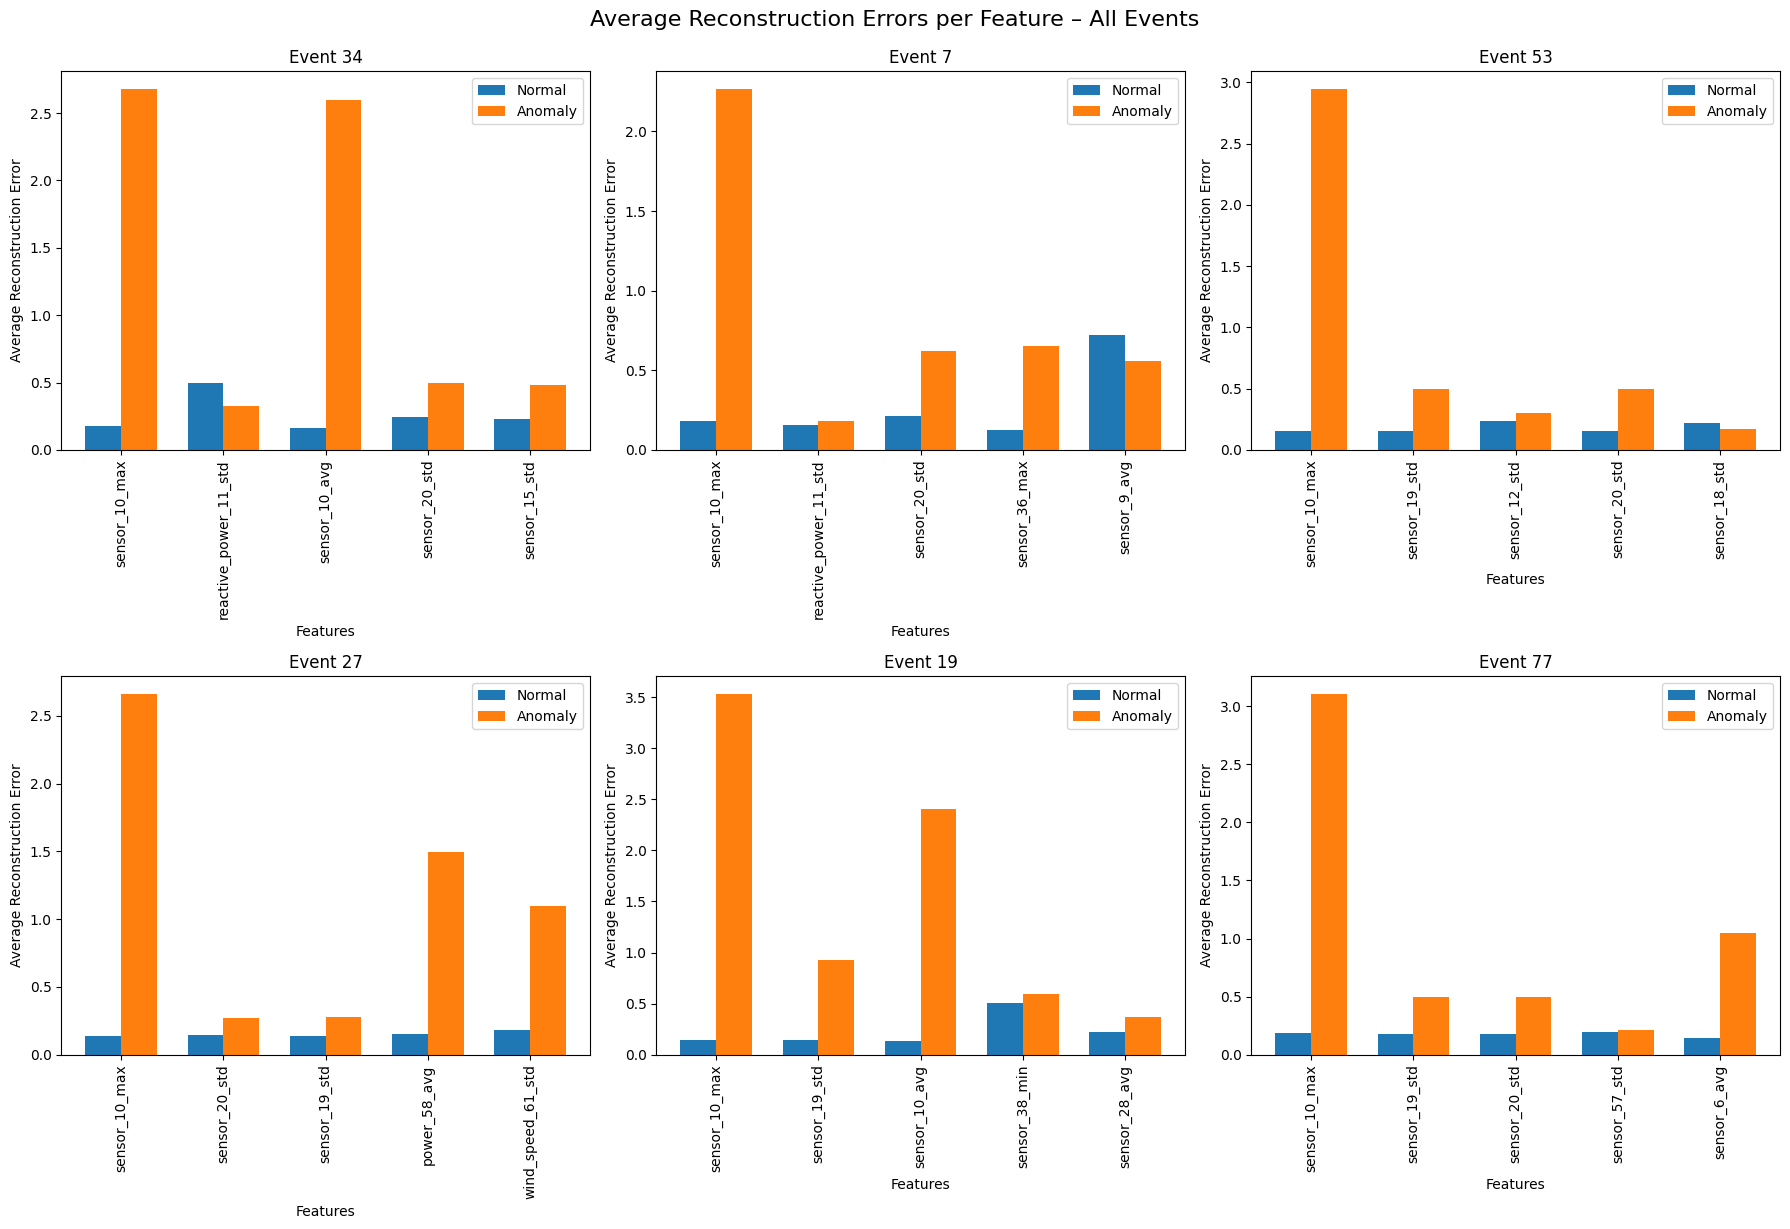

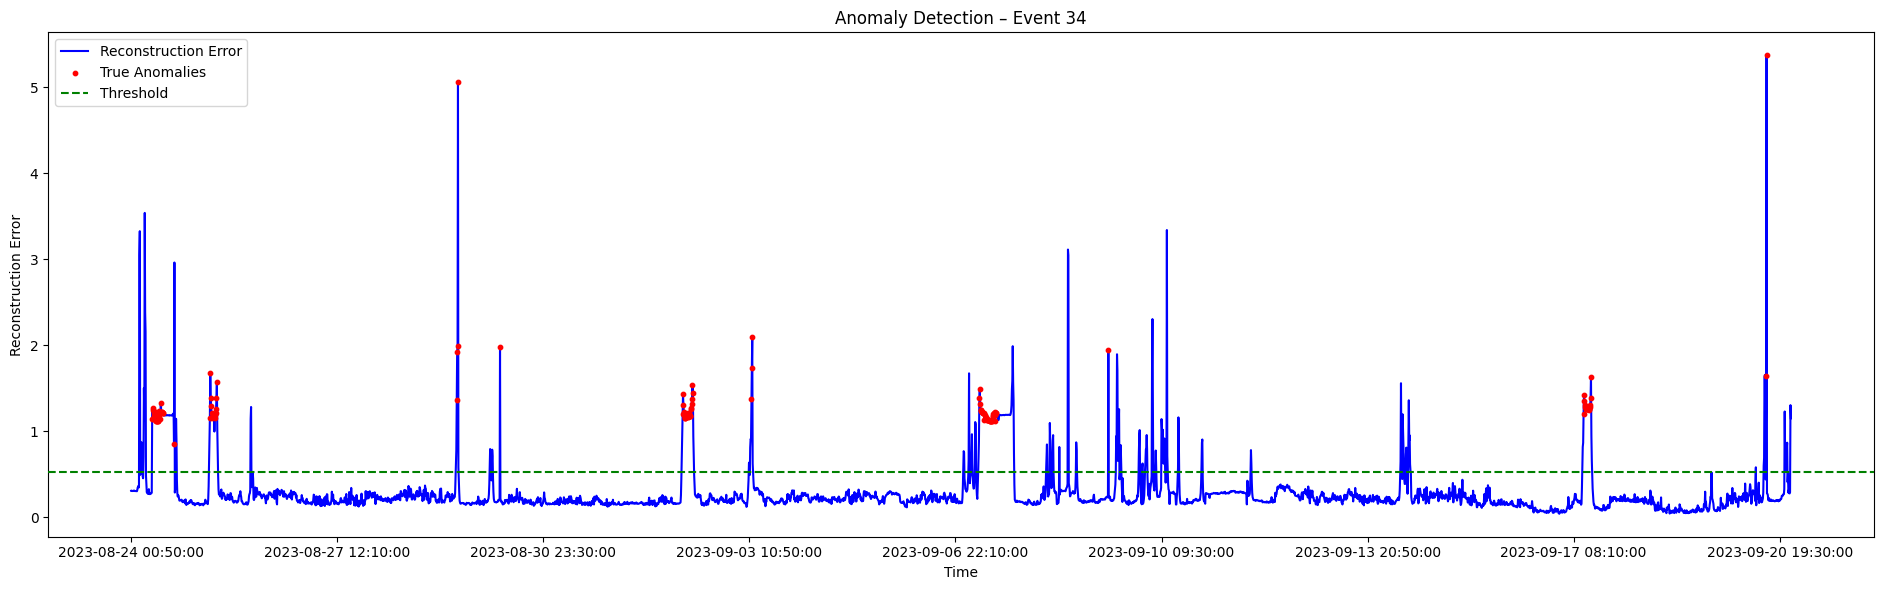

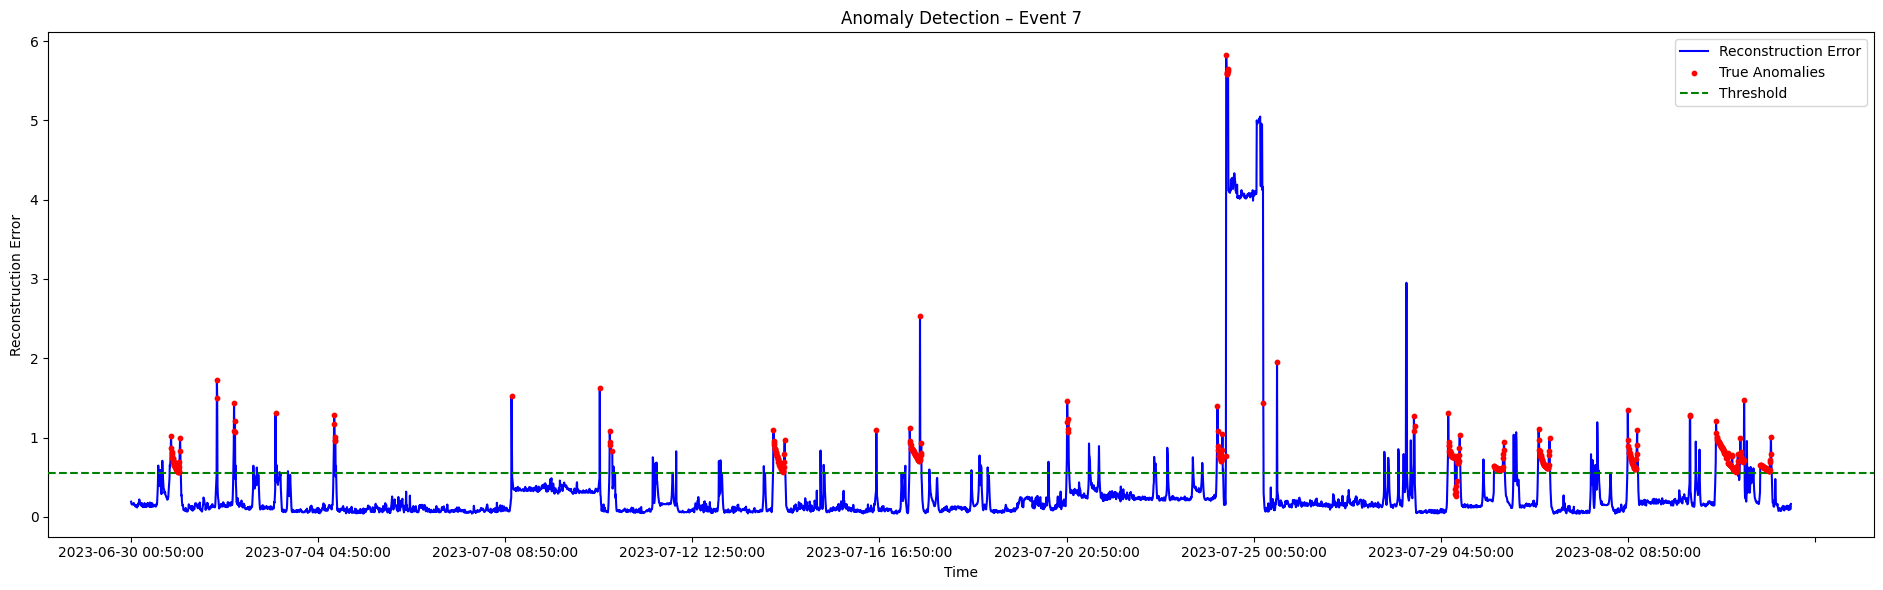

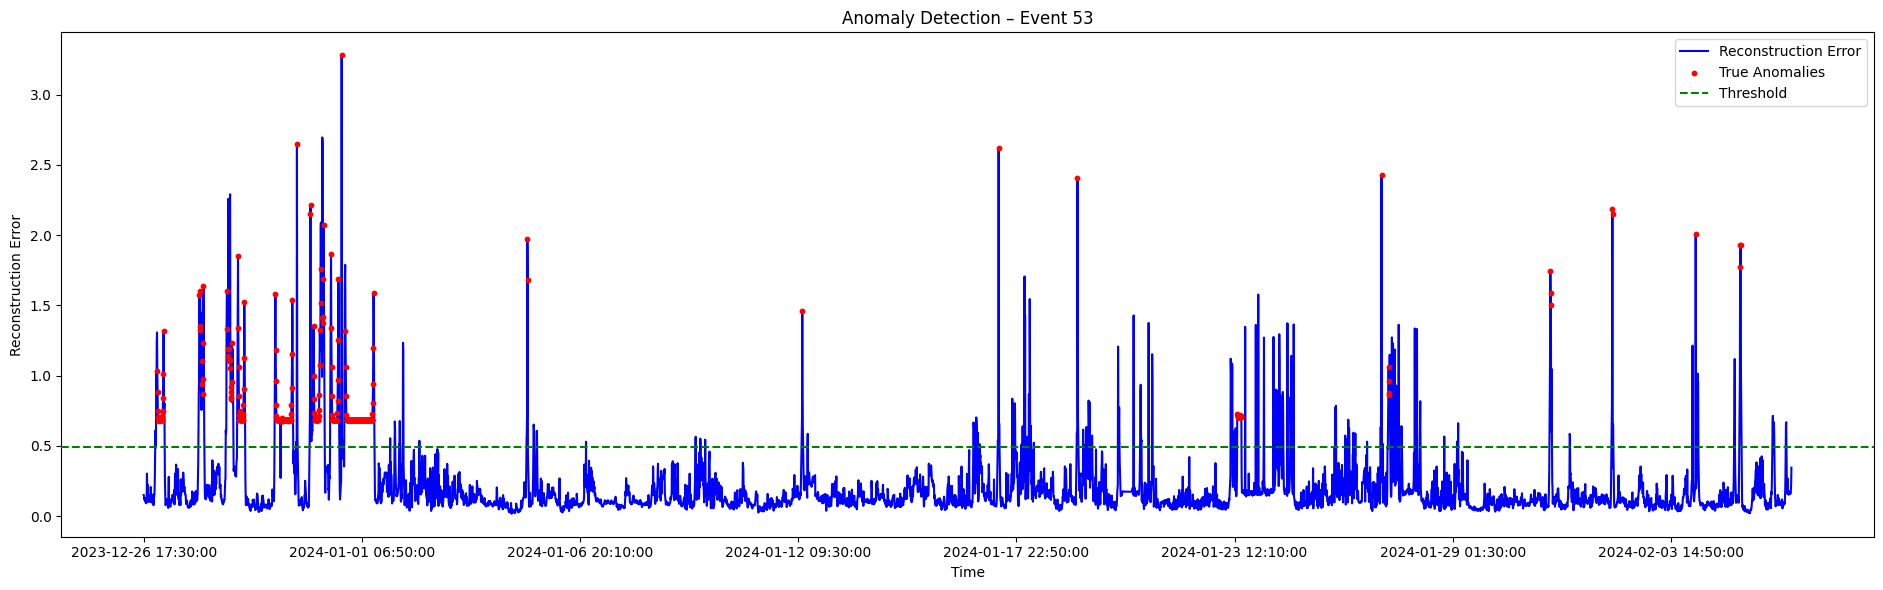

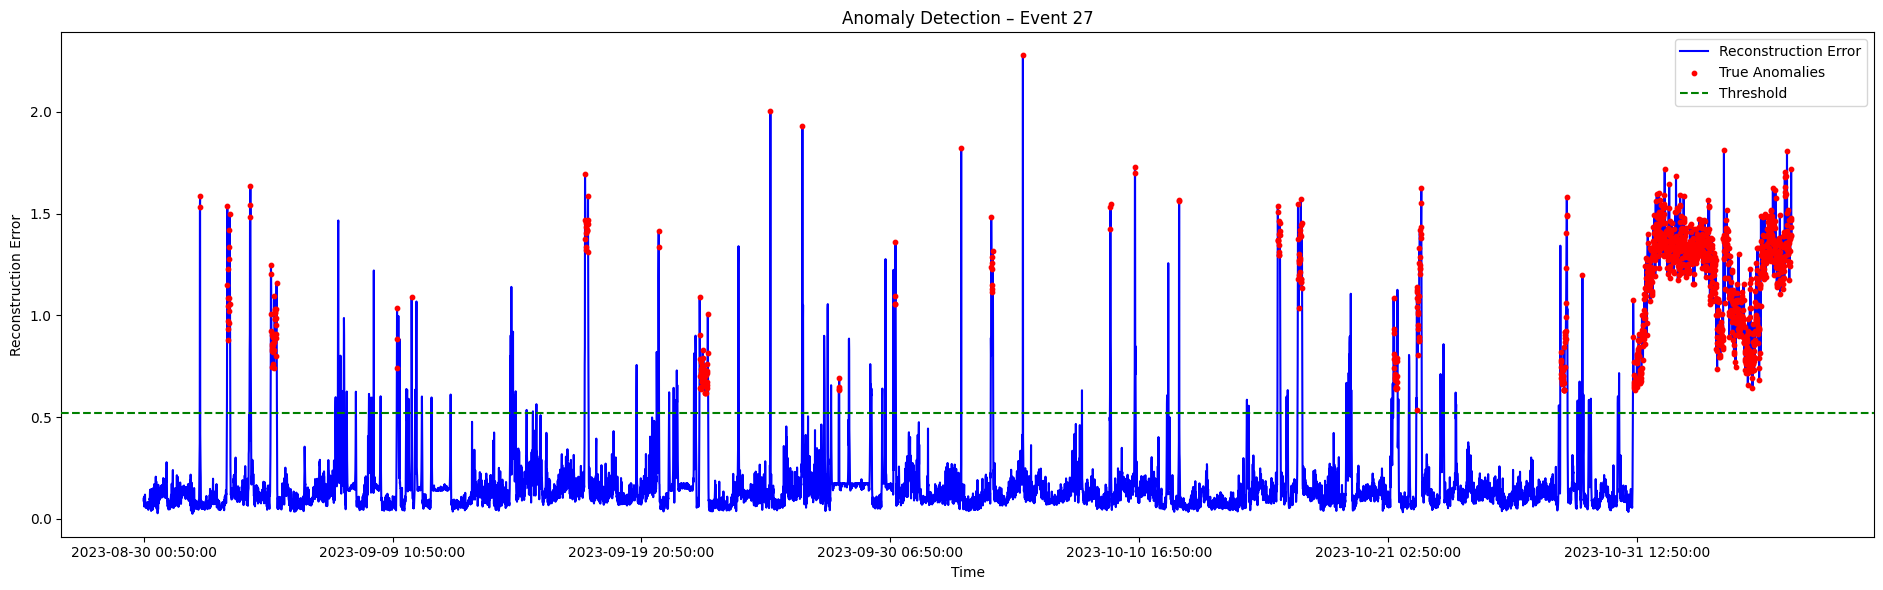

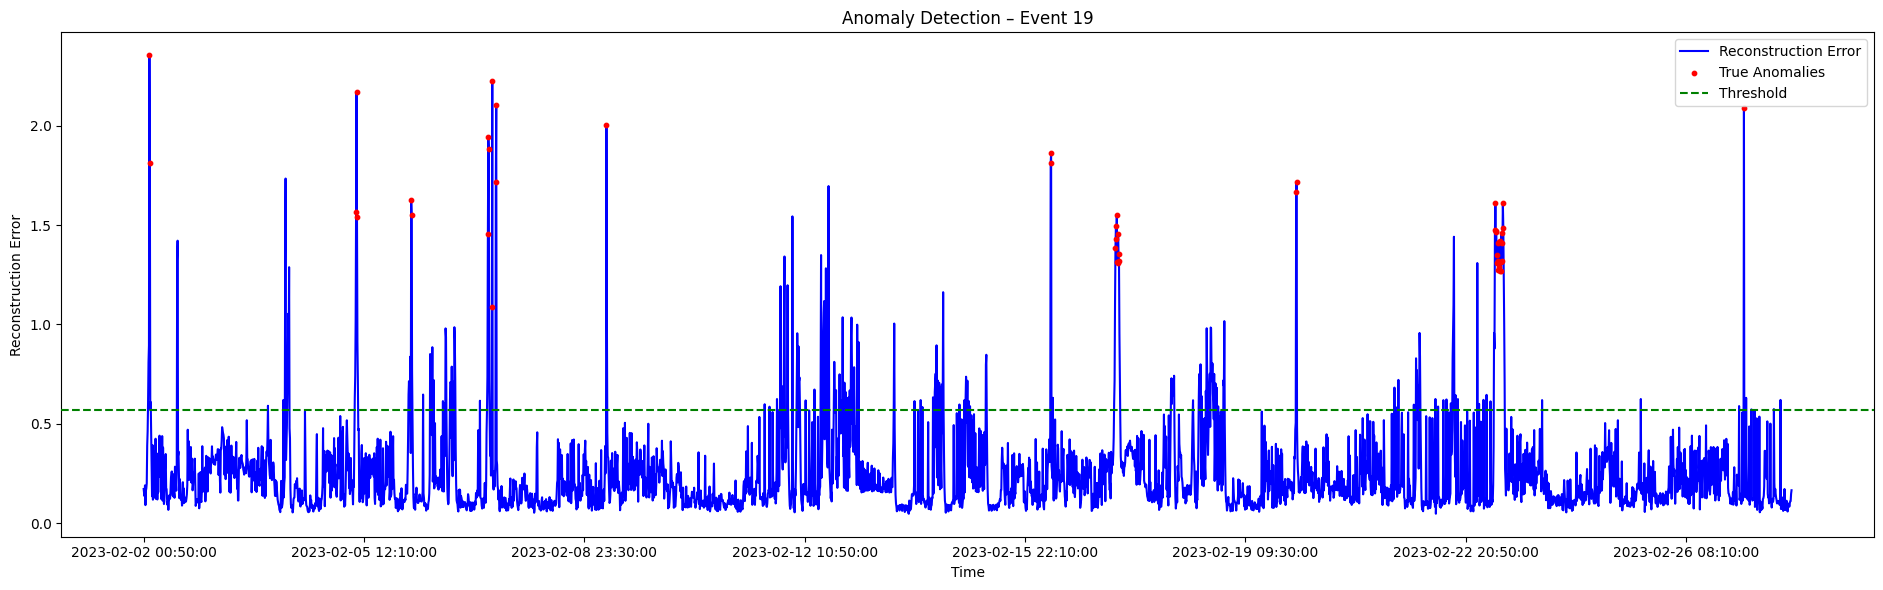

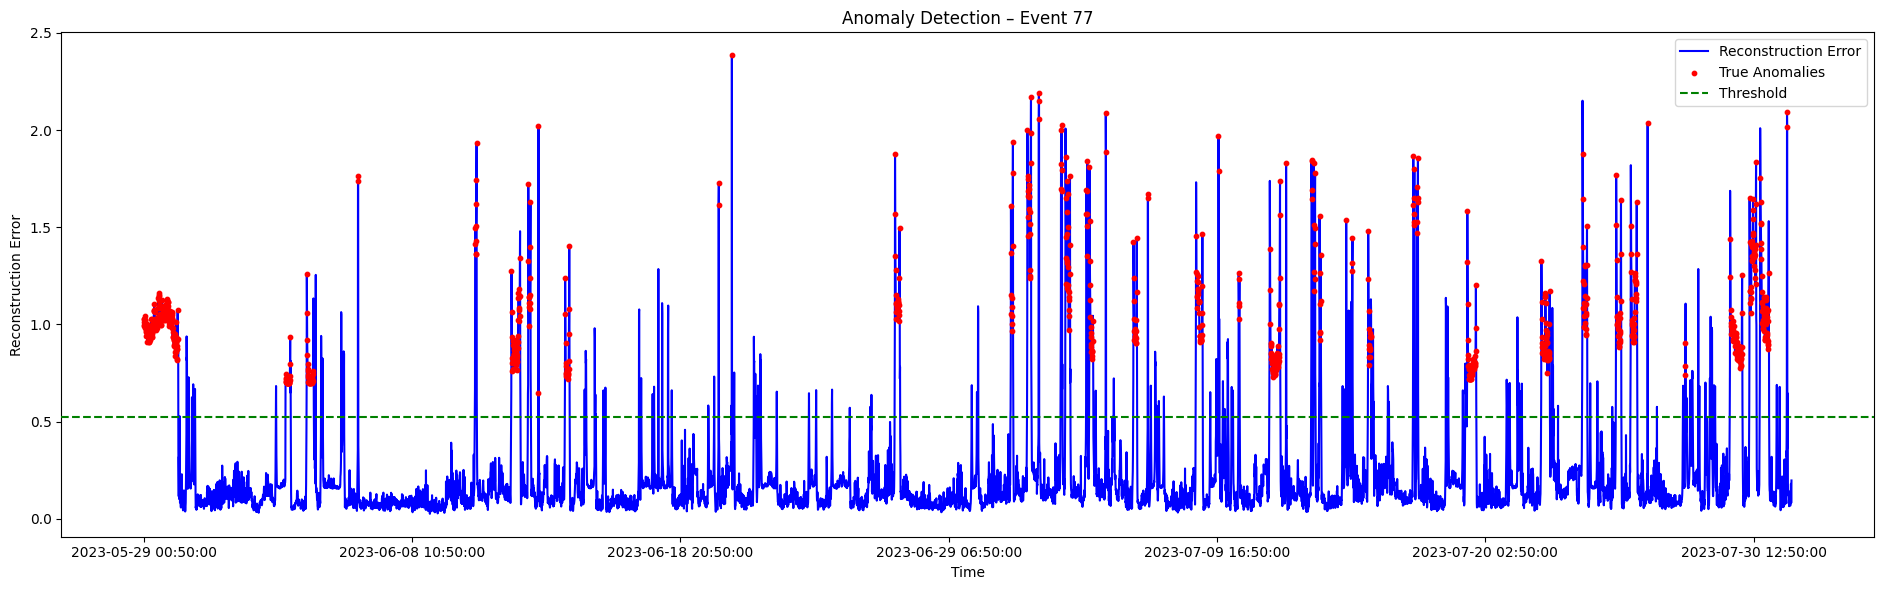

In [30]:
def create_sequences(data, timesteps):
    return np.array([data[i: i + timesteps] for i in range(len(data) - timesteps + 1)])


def create_sequences_with_indices(data, timesteps):
    sequences, index_map = [], []
    for i in range(len(data) - timesteps + 1):
        sequences.append(data[i: i + timesteps])
        index_map.append(list(range(i, i + timesteps)))
    return np.array(sequences), index_map


def safe_confusion_matrix(y_true, y_pred):
    labels = [0, 1]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if cm.shape == (1, 1):
        TN = cm[0, 0] if y_true[0] == 0 else 0
        FP = FN = TP = 0
    elif cm.shape == (1, 2):
        TN, FP = cm[0]
        FN = TP = 0
    elif cm.shape == (2, 1):
        TN = cm[0, 0]
        FN = cm[1, 0]
        FP = TP = 0
    else:
        TN, FP, FN, TP = cm.ravel()
    return TN, FP, FN, TP


datasets = {
    'Event 34': pd.read_csv('Wind Farm B/datasets/34.csv', sep=';'),
    'Event 7': pd.read_csv('Wind Farm B/datasets/7.csv', sep=';'),
    'Event 53': pd.read_csv('Wind Farm B/datasets/53.csv', sep=';'),
    'Event 27': pd.read_csv('Wind Farm B/datasets/27.csv', sep=';'),
    'Event 19': pd.read_csv('Wind Farm B/datasets/19.csv', sep=';'),
    'Event 77': pd.read_csv('Wind Farm B/datasets/77.csv', sep=';')
}

timesteps = 6
conf_matrices = {}
results = []
loss_curves = {}
histograms = {}
feature_errors_dict = {}
time_series_errors = {}

for event_name, df in datasets.items():
    print(f"\n{event_name}")

    df['label'] = df['status_type_id'].apply(lambda x: 0 if x in [0, 2] else 1)

    features = df.drop(columns=['train_test', 'status_type_id', 'asset_id', 'time_stamp', 'id'], errors='ignore')
    if 'label' not in features.columns:
        features['label'] = df['label']
    labels = features['label']
    features = features.drop(columns=['label'])

    model = xgb.XGBClassifier(objective="binary:logistic")
    model.fit(features, labels)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(features)

    shap_importance = pd.DataFrame({
        'feature': features.columns,
        'mean_abs_shap': np.abs(shap_values).mean(axis=0)
    }).sort_values(by='mean_abs_shap', ascending=False)

    top_features = shap_importance.head(5)['feature'].values
    print("Selected features:", top_features)

    normal_train = df[(df['train_test'] == 'train') & (df['label'] == 0)]
    normal_train_filtered = normal_train[top_features]
    X_normal_train = normal_train_filtered

    scaler = StandardScaler()
    X_normal_train_scaled = scaler.fit_transform(X_normal_train)

    X_train_seq = create_sequences(X_normal_train_scaled, timesteps)
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], timesteps, X_normal_train_scaled.shape[1]))

    os.environ['PYTHONHASHSEED'] = '42'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

    input_shape = (timesteps, X_normal_train_scaled.shape[1])
    inputs = Input(shape=input_shape)
    encoded = Bidirectional(LSTM(10, activation='tanh', return_sequences=False))(inputs)
    encoded = Dropout(0.2)(encoded)
    bottleneck = RepeatVector(timesteps)(encoded)
    decoded = Bidirectional(LSTM(10, activation='tanh', return_sequences=True))(bottleneck)
    decoded = Dropout(0.2)(decoded)
    outputs = TimeDistributed(Dense(X_normal_train_scaled.shape[1], activation='linear'))(decoded)

    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer=Adam(0.0001), loss='mae')
    autoencoder.summary()

    history = autoencoder.fit(
        X_train_seq, X_train_seq,
        epochs=15, batch_size=256,
        validation_split=0.1, shuffle=True, verbose=1
    )

    loss_curves[event_name] = history.history

    reconstructed_train = autoencoder.predict(X_train_seq)
    row_errors = np.mean(np.abs(X_train_seq - reconstructed_train), axis=(1, 2))
    threshold = np.percentile(row_errors, 95)

    print(f"Reconstruction error threshold ({event_name}): {threshold:.6f}")
    histograms[event_name] = (row_errors, threshold)

    test = df[df['train_test'] == 'prediction']
    X_test = test[top_features]
    y_test = test['label'].values
    X_test_scaled = scaler.transform(X_test)

    X_test_seq, index_map = create_sequences_with_indices(X_test_scaled, timesteps)
    reconstructed_test = autoencoder.predict(X_test_seq)

    abs_errors = np.abs(reconstructed_test - X_test_seq)
    sample_errors = np.mean(abs_errors, axis=2)

    error_sum, error_count = defaultdict(float), defaultdict(int)
    for seq_idx, row_indices in enumerate(index_map):
        for t_idx, row_idx in enumerate(row_indices):
            error_sum[row_idx] += sample_errors[seq_idx, t_idx]
            error_count[row_idx] += 1

    row_errors_test = np.array([error_sum[i] / error_count[i] if error_count[i] > 0 else np.nan
                                for i in range(len(X_test_scaled))])
    predicted_labels = (row_errors_test > threshold).astype(int)

    valid_mask = ~np.isnan(row_errors_test)
    y_true, y_pred = y_test[valid_mask], predicted_labels[valid_mask]

    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred, zero_division=0) * 100
    rec = recall_score(y_true, y_pred, zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, zero_division=0) * 100
    TN, FP, FN, TP = safe_confusion_matrix(y_true, y_pred)
    far = (FP / (FP + TN) * 100) if (FP + TN) > 0 else 0

    results.append({
        'Event': event_name,
        'Accuracy': round(acc, 2),
        'Precision': round(prec, 2),
        'Recall': round(rec, 2),
        'F1': round(f1, 2),
        'FAR': round(far, 2)
    })

    conf_matrices[event_name] = np.array([[TN, FP], [FN, TP]])

    num_features = abs_errors.shape[2]
    num_samples = len(X_test_scaled)

    error_sum_per_feature = defaultdict(lambda: np.zeros(num_features))
    error_count_per_feature = defaultdict(int)

    for seq_idx, row_indices in enumerate(index_map):
        for t_idx, row_idx in enumerate(row_indices):
            error_sum_per_feature[row_idx] += abs_errors[seq_idx, t_idx]
            error_count_per_feature[row_idx] += 1

    feature_errors_per_sample = np.zeros((num_samples, num_features))

    for i in range(num_samples):
        if error_count_per_feature[i] > 0:
            feature_errors_per_sample[i] = error_sum_per_feature[i] / error_count_per_feature[i]
        else:
            feature_errors_per_sample[i] = np.nan

    feature_errors_valid = feature_errors_per_sample[valid_mask]
    y_true_valid = y_true
    y_pred_valid = y_pred

    normal_errors = feature_errors_valid[y_true_valid == 0]
    anomaly_errors = feature_errors_valid[y_true_valid == 1]

    avg_normal_errors = np.nanmean(normal_errors, axis=0)
    avg_anomaly_errors = np.nanmean(anomaly_errors, axis=0)

    feature_errors_dict[event_name] = (top_features, avg_normal_errors, avg_anomaly_errors)

    test = df[df['train_test'] == 'prediction']
    test_data = test[timesteps - 1:]
    timestamps = test_data['time_stamp'].values
    y_true_aligned = y_true[timesteps - 1:]
    y_pred_aligned = y_pred[timesteps - 1:]
    row_errors_aligned = row_errors_test[timesteps - 1:]

    time_series_errors[event_name] = (row_errors_aligned, threshold, y_true_aligned, y_pred_aligned, timestamps)


results_df = pd.DataFrame(results)
results_df.loc['Average'] = results_df.mean(numeric_only=True).round(2)

print("\nAnomaly Detection Results for All Events: Bi-LSTM Autoencoder (without low-variance feature removal) (%):\n")
print(results_df)


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for ax, (event_name, hist) in zip(axes, loss_curves.items()):
    ax.plot(hist['loss'], label='Training Loss')
    ax.plot(hist['val_loss'], label='Validation Loss')
    ax.set_title(event_name)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
fig.suptitle("Loss Curves – All Events", fontsize=16, y=1.02)
plt.show()


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for ax, (event_name, (errors, threshold)) in zip(axes, histograms.items()):
    ax.hist(errors, bins=50, color="blue", alpha=0.7)
    ax.axvline(x=threshold, color="green", linestyle="--", label="Threshold")
    ax.set_title(event_name)
    ax.set_xlabel("Reconstruction Error")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.grid(True)
plt.tight_layout()
fig.suptitle("Training Errors and Threshold – All Events", fontsize=16, y=1.02)
plt.show()


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
labels = [0, 1]
for ax, (event_name, cm) in zip(axes.flatten(), conf_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax, colorbar=False)
    ax.set_title(event_name)
plt.tight_layout()
fig.suptitle("Confusion Matrices – All Events", fontsize=16, y=1.02)
plt.show()


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for ax, (event_name, (top_features, avg_normal_errors, avg_anomaly_errors)) in zip(axes, feature_errors_dict.items()):
    x = np.arange(len(top_features))
    width = 0.35
    ax.bar(x - width/2, avg_normal_errors, width, label='Normal')
    ax.bar(x + width/2, avg_anomaly_errors, width, label='Anomaly')
    ax.set_xlabel('Features')
    ax.set_ylabel('Average Reconstruction Error')
    ax.set_xticks(x)
    ax.set_xticklabels(top_features, rotation=90)
    ax.legend()
    ax.set_title(event_name)
plt.tight_layout()
fig.suptitle("Average Reconstruction Errors per Feature – All Events", fontsize=16, y=1.02)
plt.show()


for event_name, (row_errors_aligned, threshold, y_true_aligned, y_pred_aligned, timestamps) in time_series_errors.items():
    plt.figure(figsize=(19, 6))
    anomalies = (y_true_aligned == 1)
    plt.plot(timestamps, row_errors_aligned, label="Reconstruction Error", color="blue", zorder=2)
    plt.scatter(timestamps[anomalies], row_errors_aligned[anomalies],
                color="red", label="True Anomalies", s=10, zorder=5)
    plt.axhline(y=threshold, color="green", linestyle="--", label="Threshold", zorder=3)
    plt.xlabel("Time")
    plt.ylabel("Reconstruction Error")
    plt.title(f"Anomaly Detection – {event_name}")
    plt.legend()
    plt.tight_layout()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))
    plt.show()


#### Removing Low-Variance Features


Event 34
Selected features: ['sensor_10_max' 'sensor_10_avg' 'sensor_20_std' 'sensor_15_std'
 'sensor_30_std']


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 20)             │         1,280 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_18 (RepeatVector) │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 6, 20)          │         2,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 6, 5)           │           105 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,865 (15.10 KB)

 Trainable params: 3,865 (15.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.7962 - val_loss: 0.6988
Epoch 2/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6959 - val_loss: 0.5666
Epoch 3/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5774 - val_loss: 0.4501
Epoch 4/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.4849 - val_loss: 0.3733
Epoch 5/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4205 - val_loss: 0.3141
Epoch 6/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3740 - val_loss: 0.2599
Epoch 7/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3417 - val_loss: 0.2281
Epoch 8/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3237 - val_loss: 0.2128
Epoch 9/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3123 - val_loss: 0.2052
Epoch 10/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3035 - val_loss: 0.1993
Epoch 11/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2972 - val_loss: 0.1954
Epoch 12/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 20)             │         1,280 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_19 (RepeatVector) │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 6, 20)          │         2,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 6, 5)           │           105 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,865 (15.10 KB)

 Trainable params: 3,865 (15.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.7322 - val_loss: 0.7962
Epoch 2/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6176 - val_loss: 0.6543
Epoch 3/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4957 - val_loss: 0.5296
Epoch 4/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4127 - val_loss: 0.4516
Epoch 5/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.3664 - val_loss: 0.4012
Epoch 6/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3357 - val_loss: 0.3633
Epoch 7/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3152 - val_loss: 0.3358
Epoch 8/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2975 - val_loss: 0.3127
Epoch 9/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2842 - val_loss: 0.2929
Epoch 10/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2734 - val_loss: 0.2784
Epoch 11/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2644 - val_loss: 0.2667
Epoch 12/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 20)             │         1,280 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_20 (RepeatVector) │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 6, 20)          │         2,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 6, 5)           │           105 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,865 (15.10 KB)

 Trainable params: 3,865 (15.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.7813 - val_loss: 0.6140
Epoch 2/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6553 - val_loss: 0.4458
Epoch 3/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5063 - val_loss: 0.3284
Epoch 4/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4137 - val_loss: 0.2792
Epoch 5/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3578 - val_loss: 0.2473
Epoch 6/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3232 - val_loss: 0.2256
Epoch 7/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3007 - val_loss: 0.2099
Epoch 8/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2847 - val_loss: 0.1980
Epoch 9/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2742 - val_loss: 0.1892
Epoch 10/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2659 - val_loss: 0.1825
Epoch 11/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2588 - val_loss: 0.1774
Epoch 12/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 20)             │         1,280 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_21 (RepeatVector) │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 6, 20)          │         2,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 6, 5)           │           105 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,865 (15.10 KB)

 Trainable params: 3,865 (15.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.6406 - val_loss: 0.6141
Epoch 2/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.5430 - val_loss: 0.4874
Epoch 3/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4381 - val_loss: 0.3563
Epoch 4/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3483 - val_loss: 0.2637
Epoch 5/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2970 - val_loss: 0.2248
Epoch 6/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2766 - val_loss: 0.2055
Epoch 7/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2657 - val_loss: 0.1954
Epoch 8/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2578 - val_loss: 0.1897
Epoch 9/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2514 - val_loss: 0.1850
Epoch 10/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2465 - val_loss: 0.1820
Epoch 11/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2419 - val_loss: 0.1791
Epoch 12/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 20)             │         1,280 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_22 (RepeatVector) │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ (None, 6, 20)          │         2,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 6, 5)           │           105 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,865 (15.10 KB)

 Trainable params: 3,865 (15.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.7780 - val_loss: 0.7597
Epoch 2/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6560 - val_loss: 0.5750
Epoch 3/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5123 - val_loss: 0.4278
Epoch 4/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4213 - val_loss: 0.3601
Epoch 5/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.3742 - val_loss: 0.3179
Epoch 6/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3426 - val_loss: 0.2864
Epoch 7/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3161 - val_loss: 0.2616
Epoch 8/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2963 - val_loss: 0.2424
Epoch 9/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2835 - val_loss: 0.2277
Epoch 10/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2747 - val_loss: 0.2169
Epoch 11/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2671 - val_loss: 0.2083
Epoch 12/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 20)             │         1,280 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_23 (RepeatVector) │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 6, 20)          │         2,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 6, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 6, 5)           │           105 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,865 (15.10 KB)

 Trainable params: 3,865 (15.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.7954 - val_loss: 0.6727
Epoch 2/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6750 - val_loss: 0.5371
Epoch 3/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5404 - val_loss: 0.4107
Epoch 4/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4416 - val_loss: 0.3206
Epoch 5/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3761 - val_loss: 0.2675
Epoch 6/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3374 - val_loss: 0.2369
Epoch 7/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3137 - val_loss: 0.2179
Epoch 8/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2986 - val_loss: 0.2053
Epoch 9/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2877 - val_loss: 0.1965
Epoch 10/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2801 - val_loss: 0.1900
Epoch 11/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2735 - val_loss: 0.1853
Epoch 12/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 

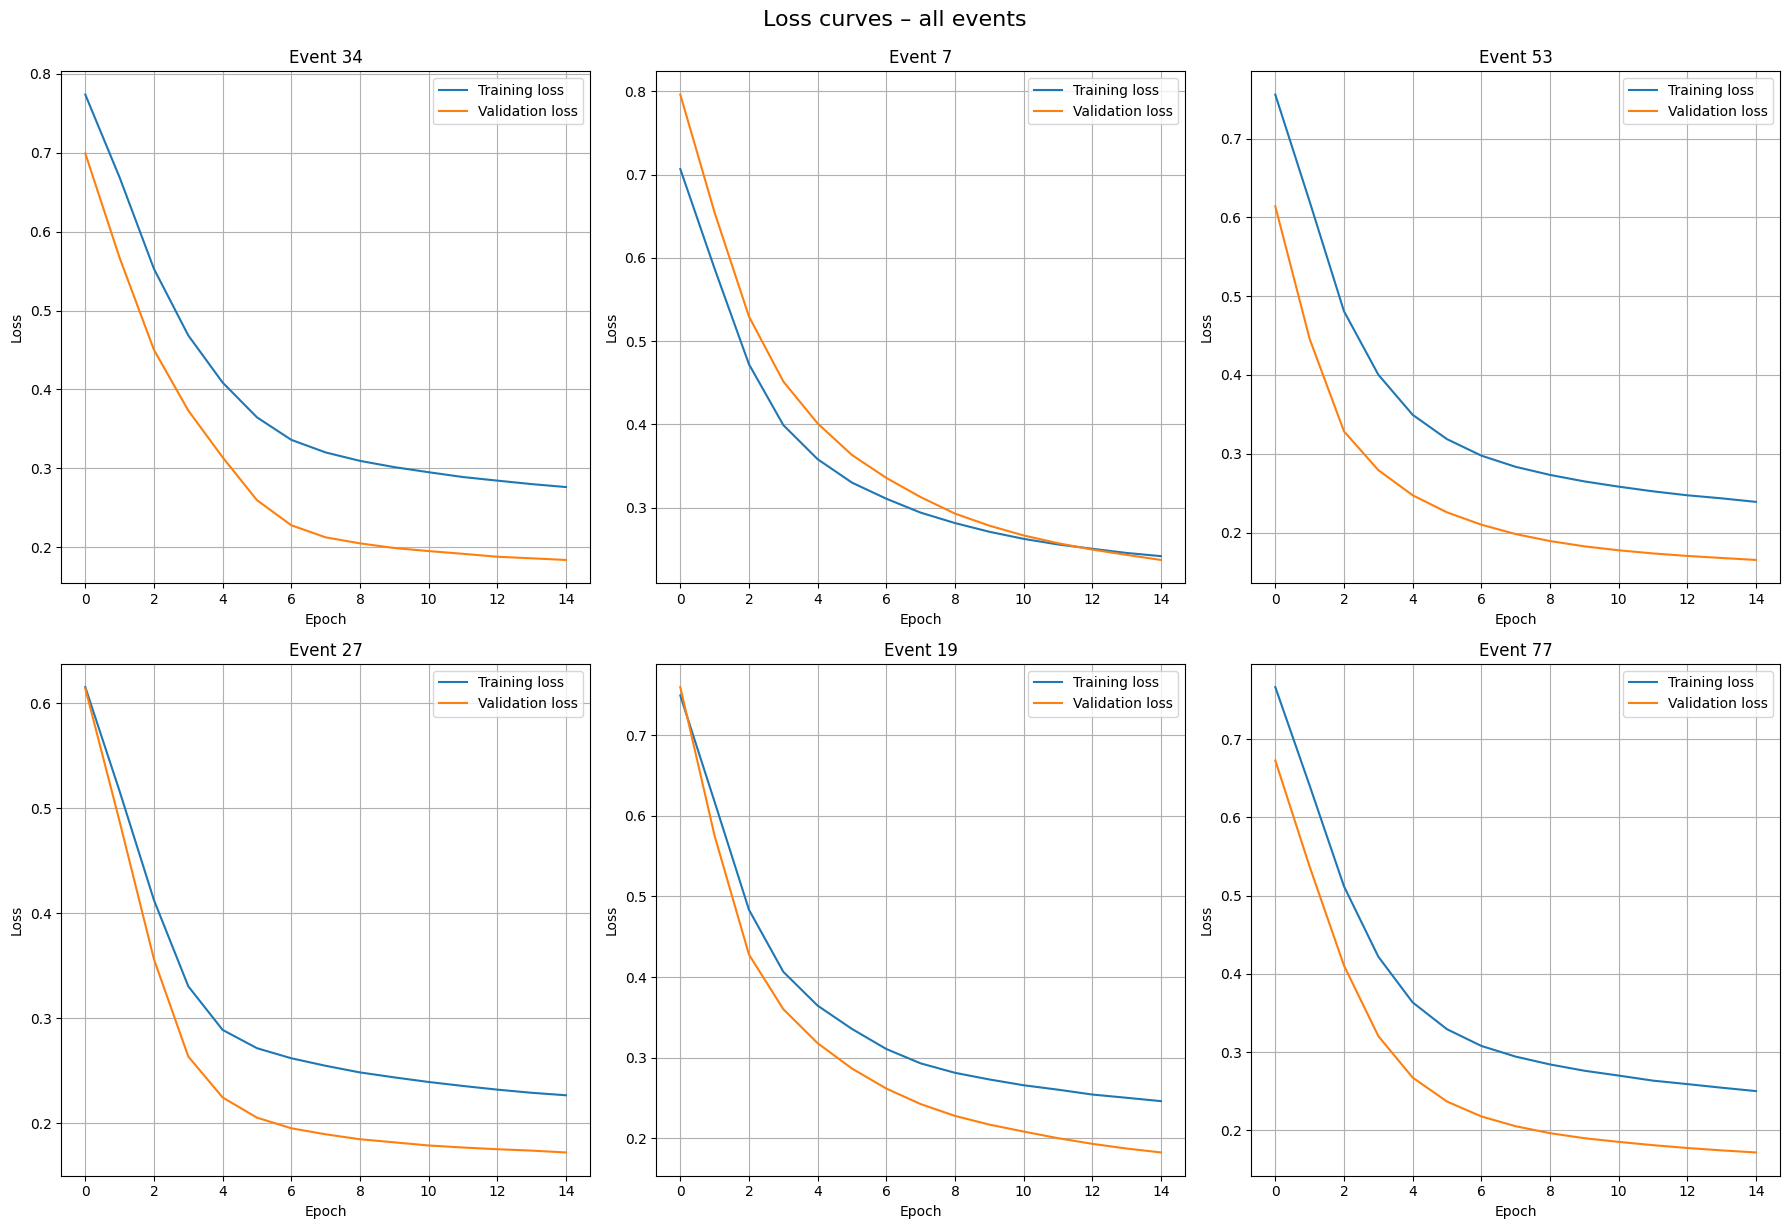

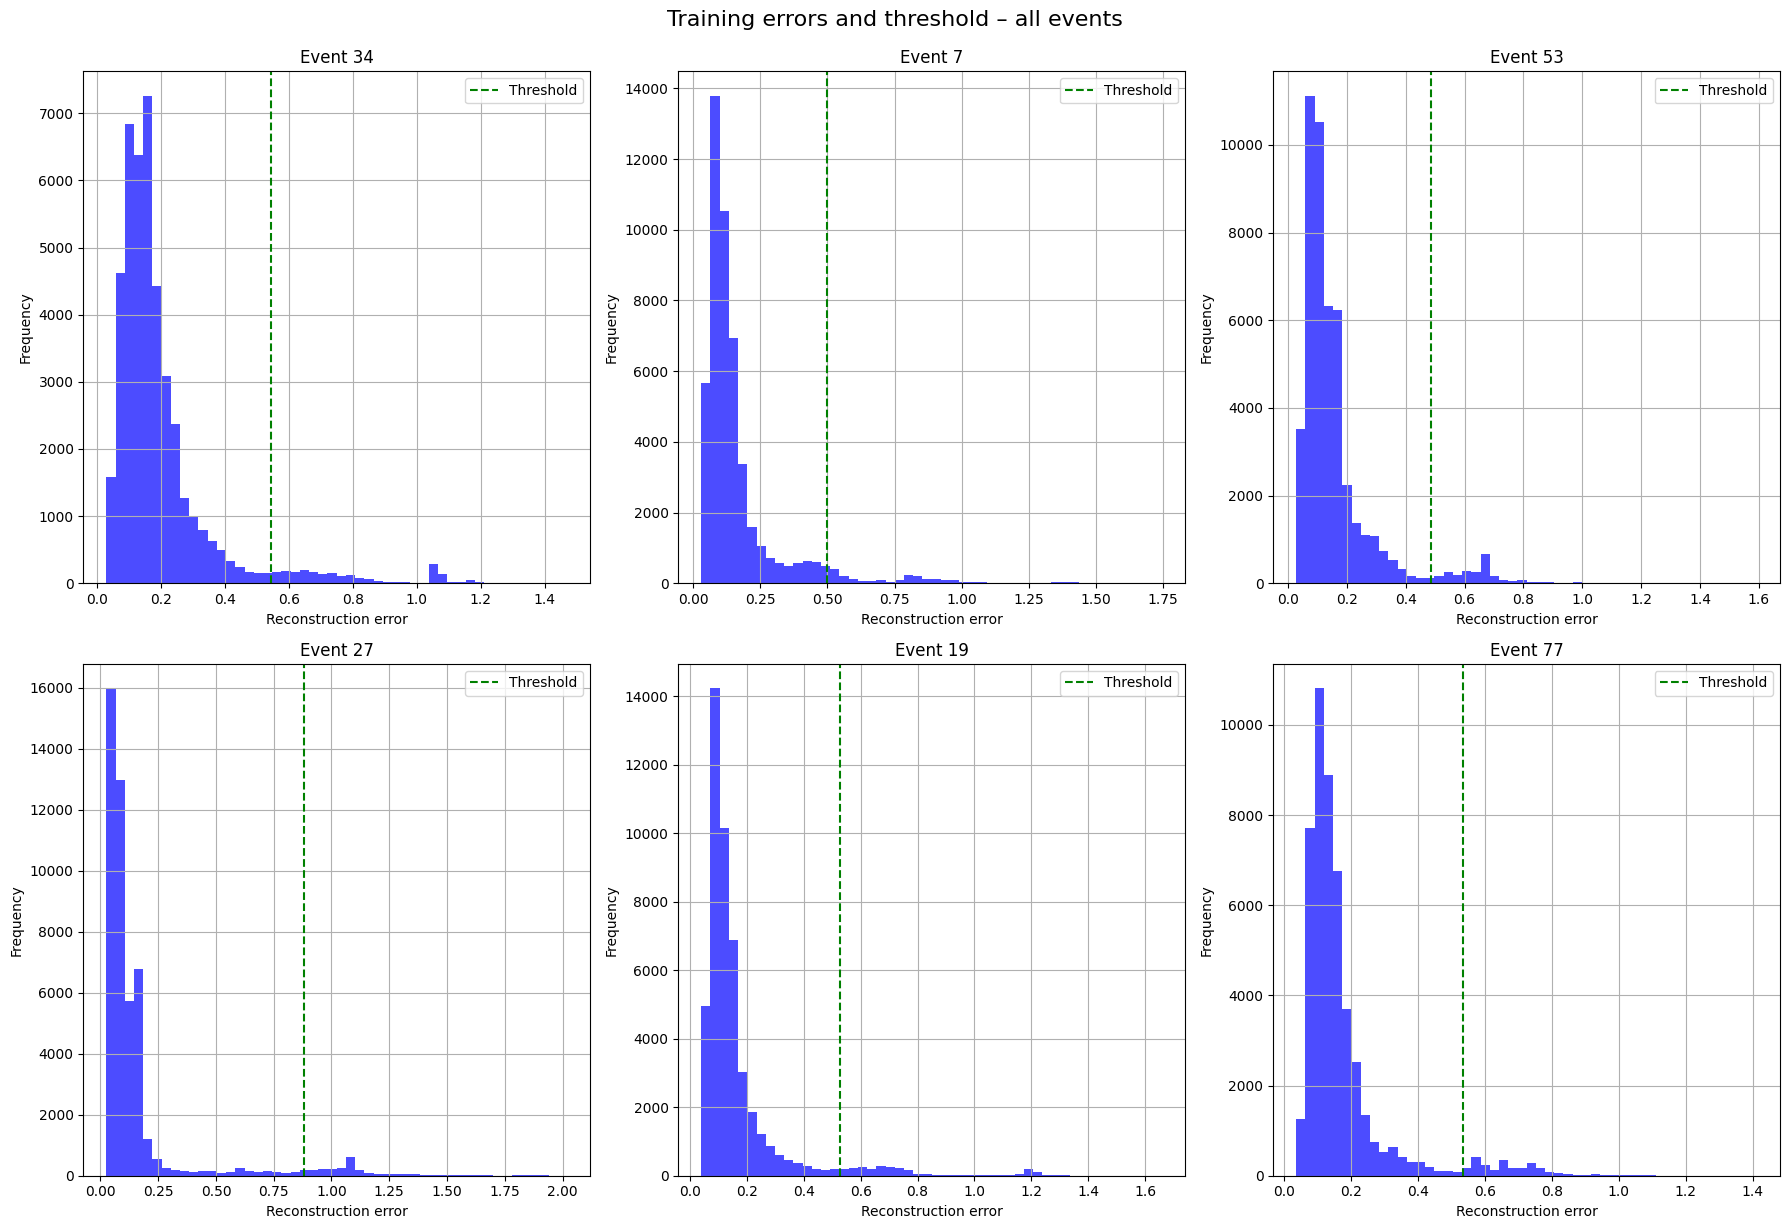

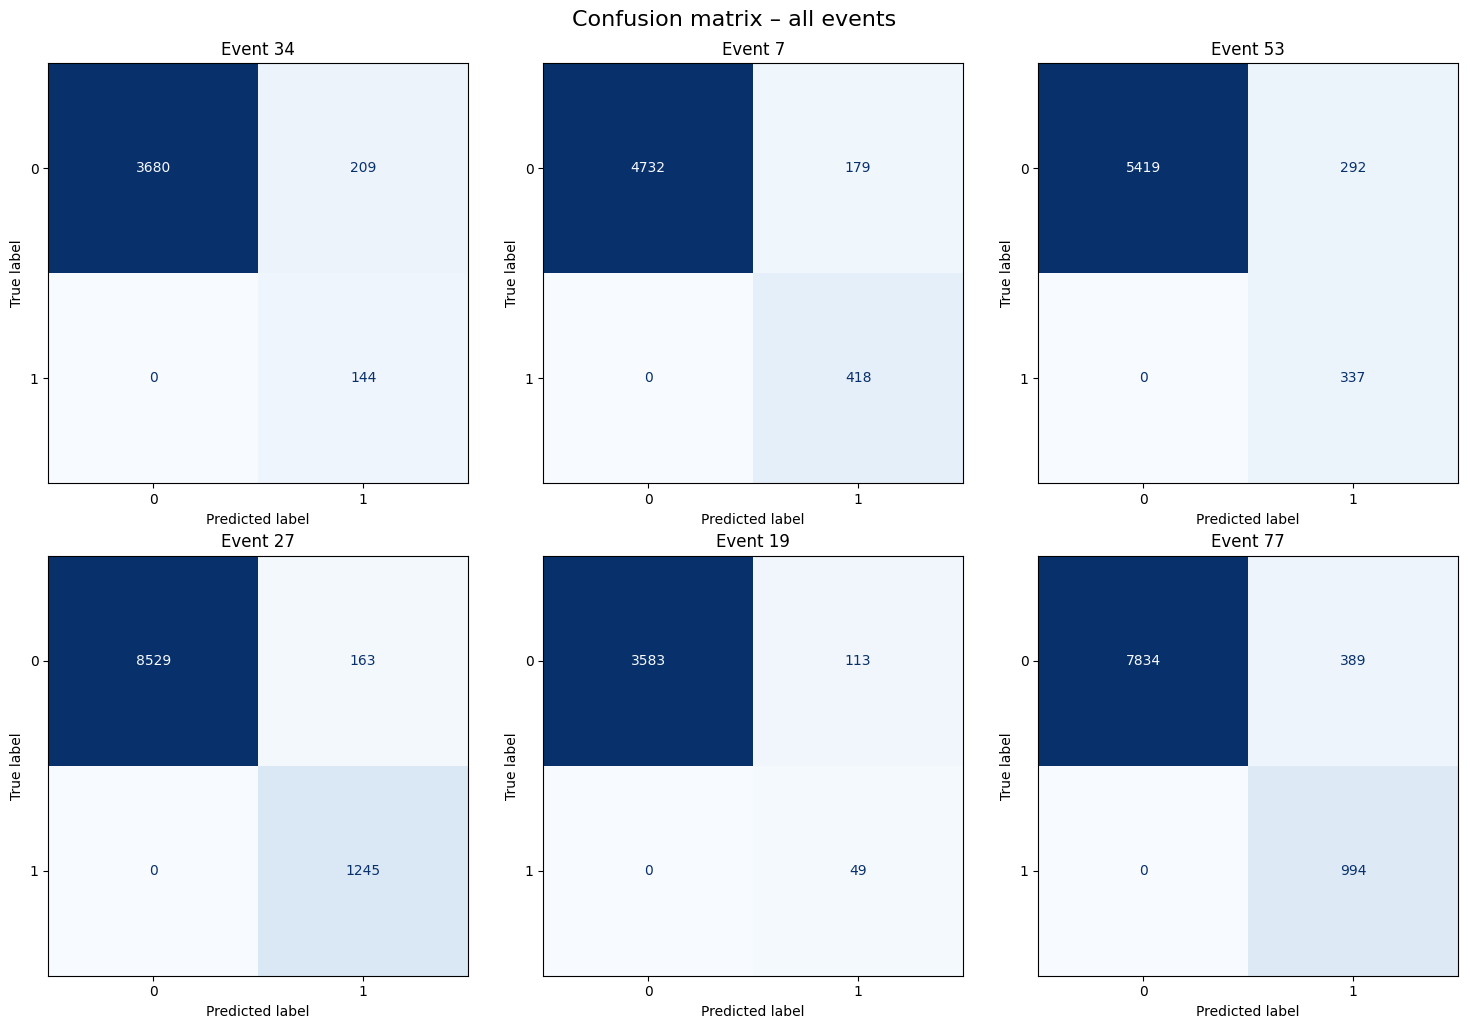

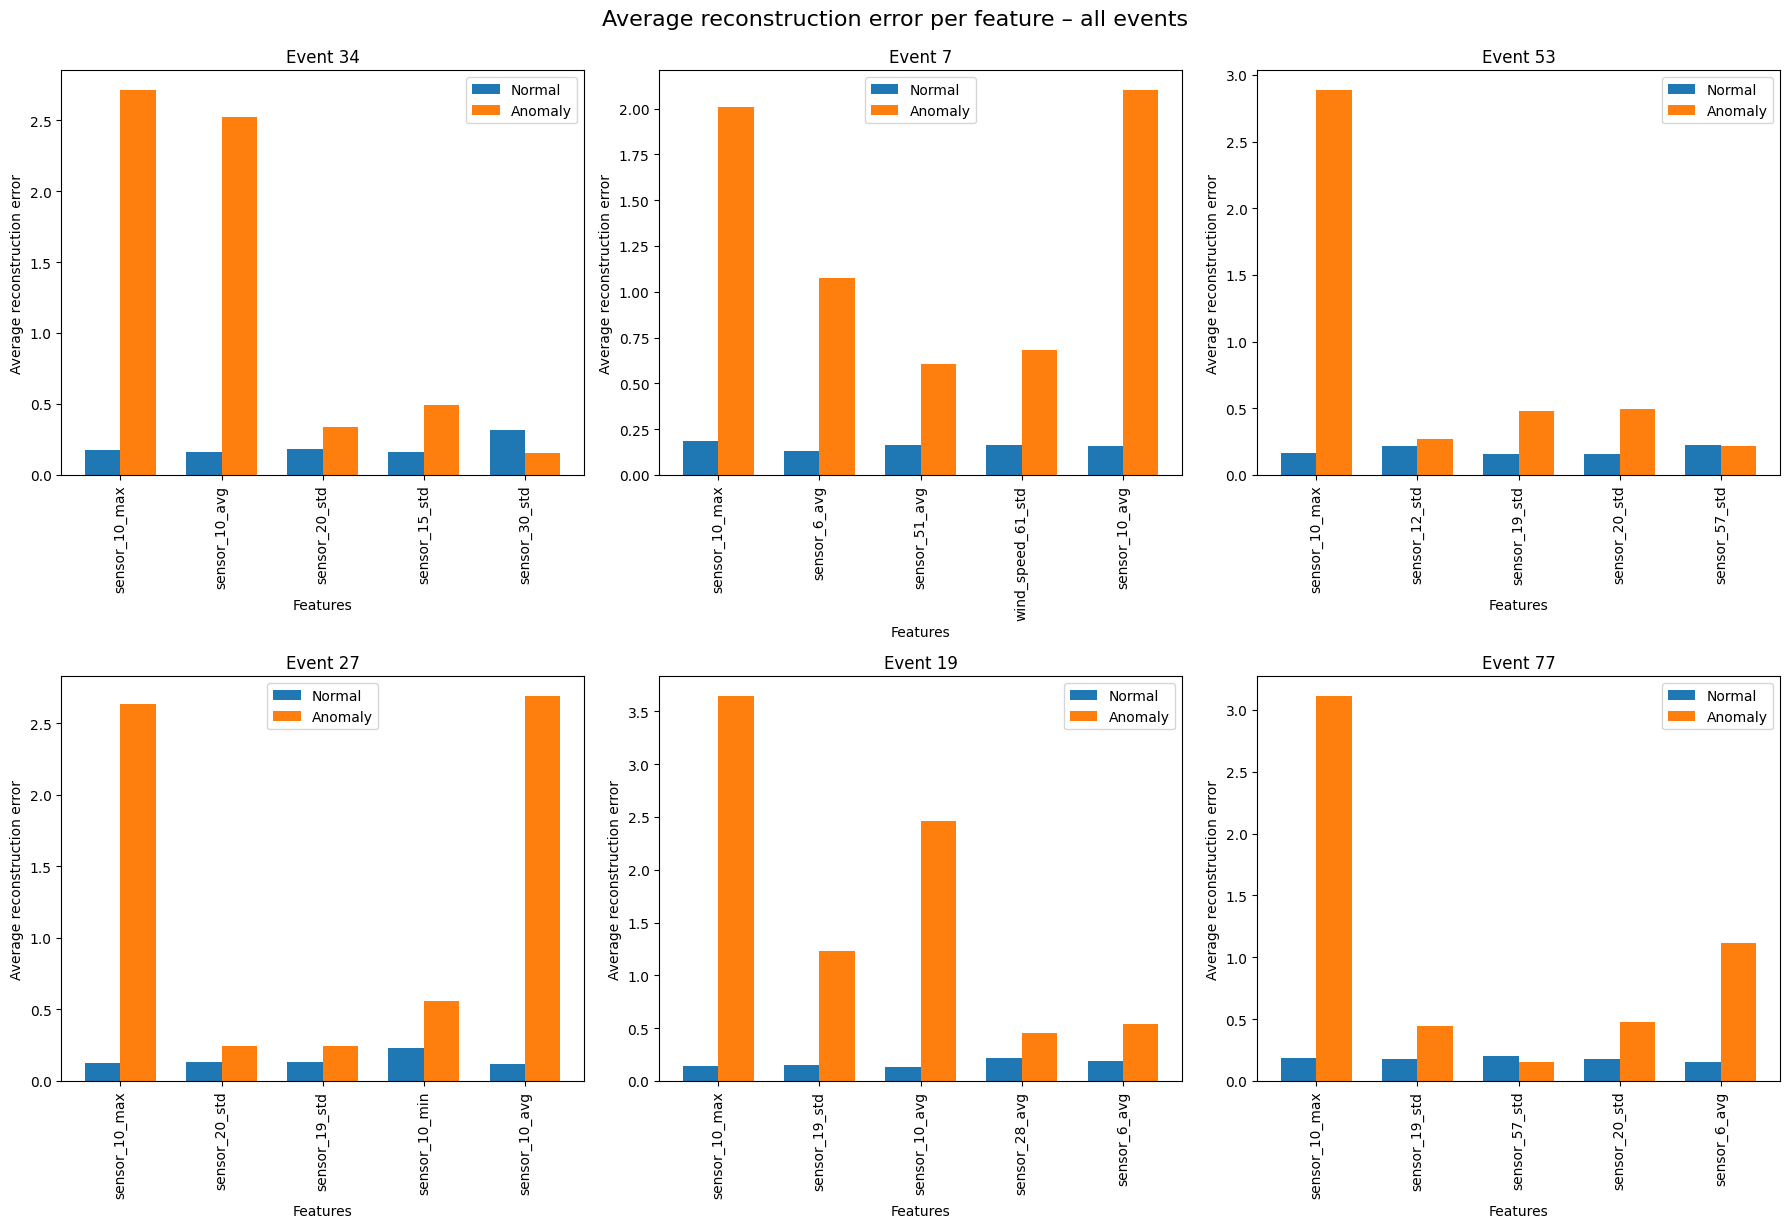

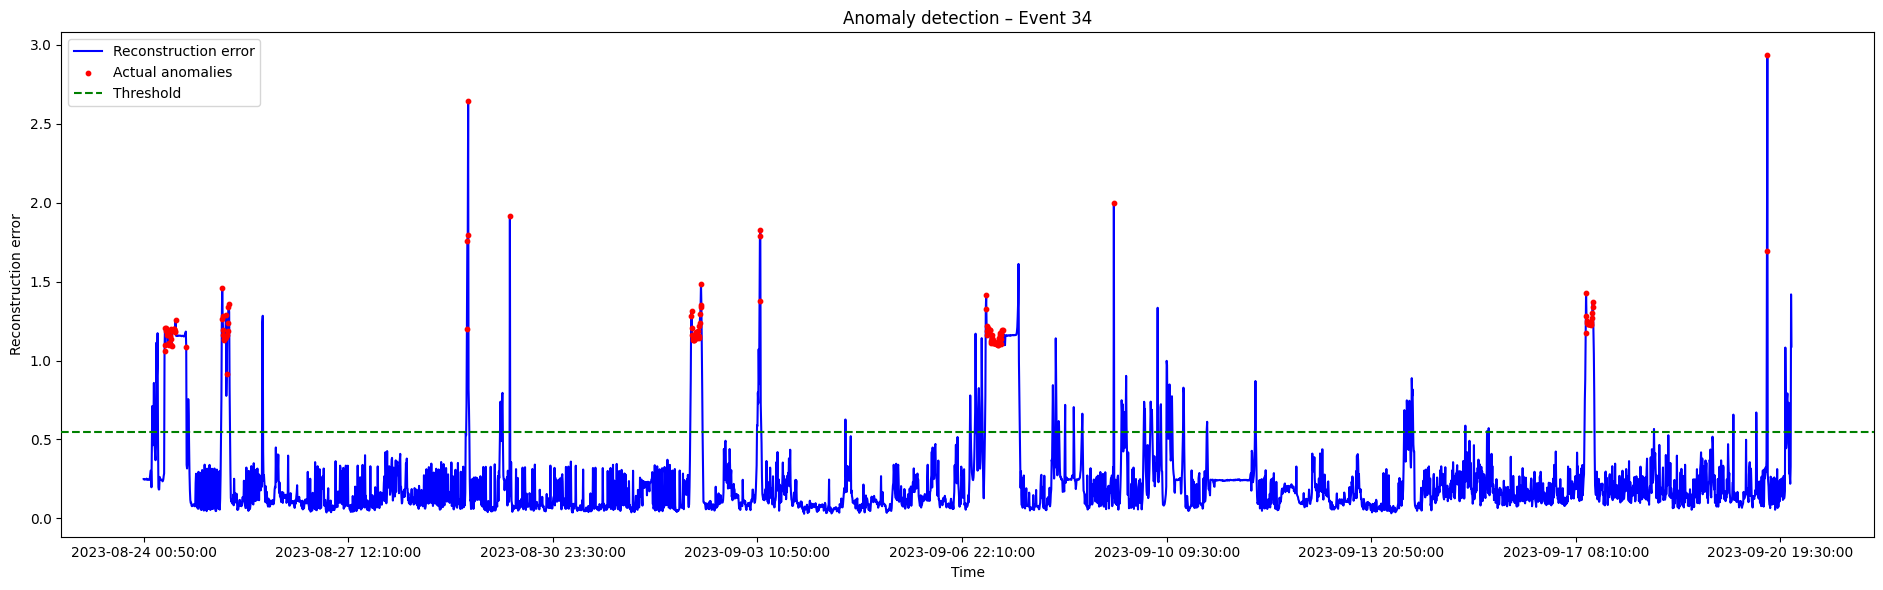

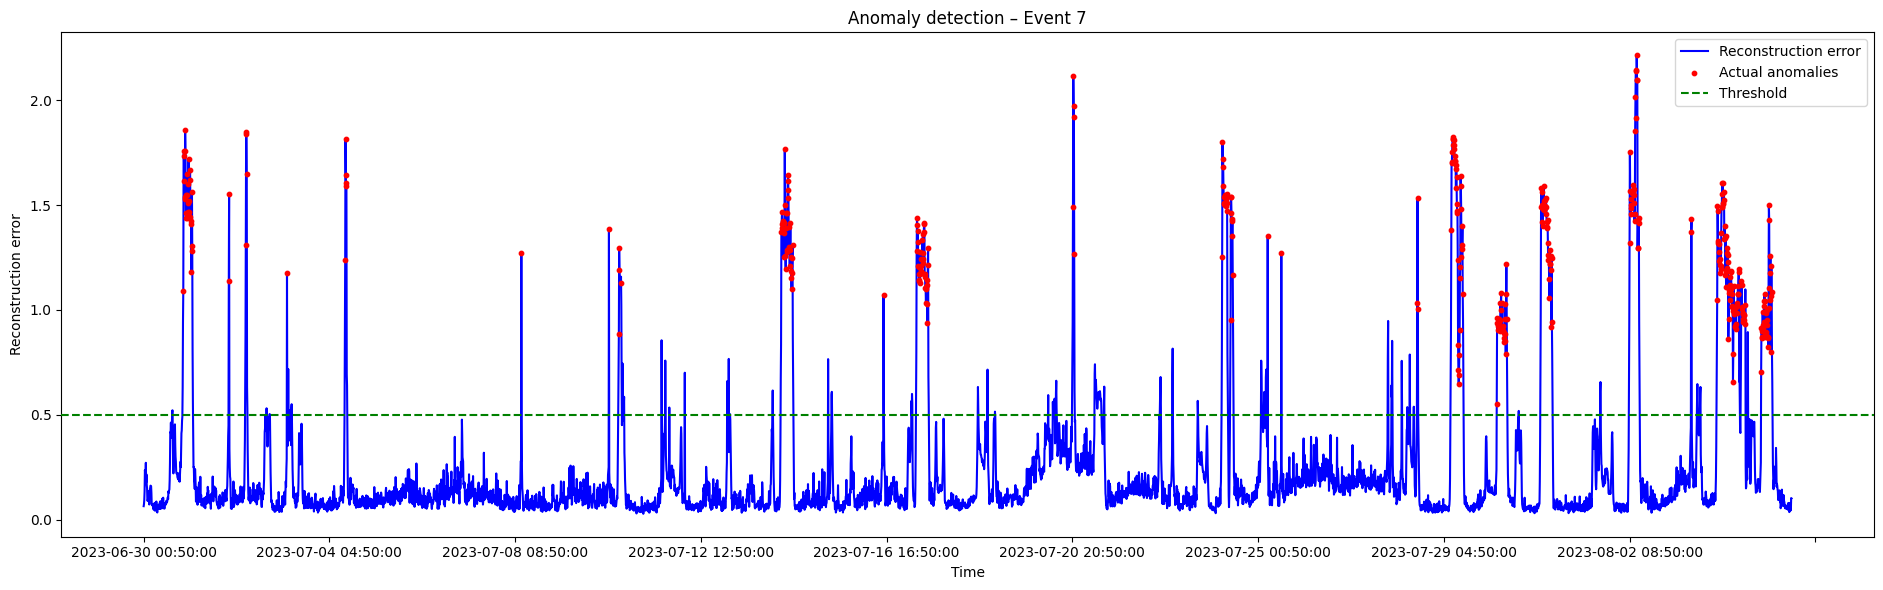

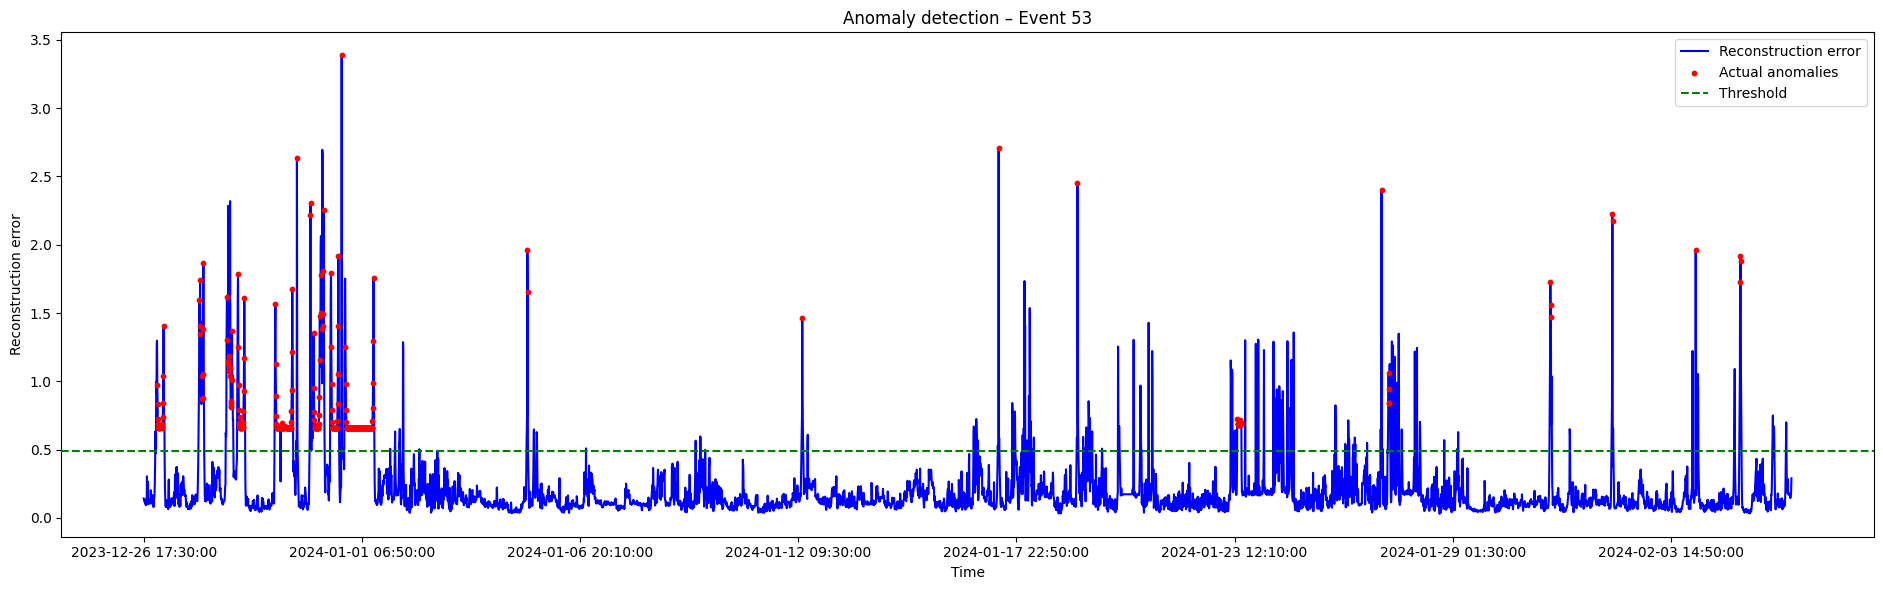

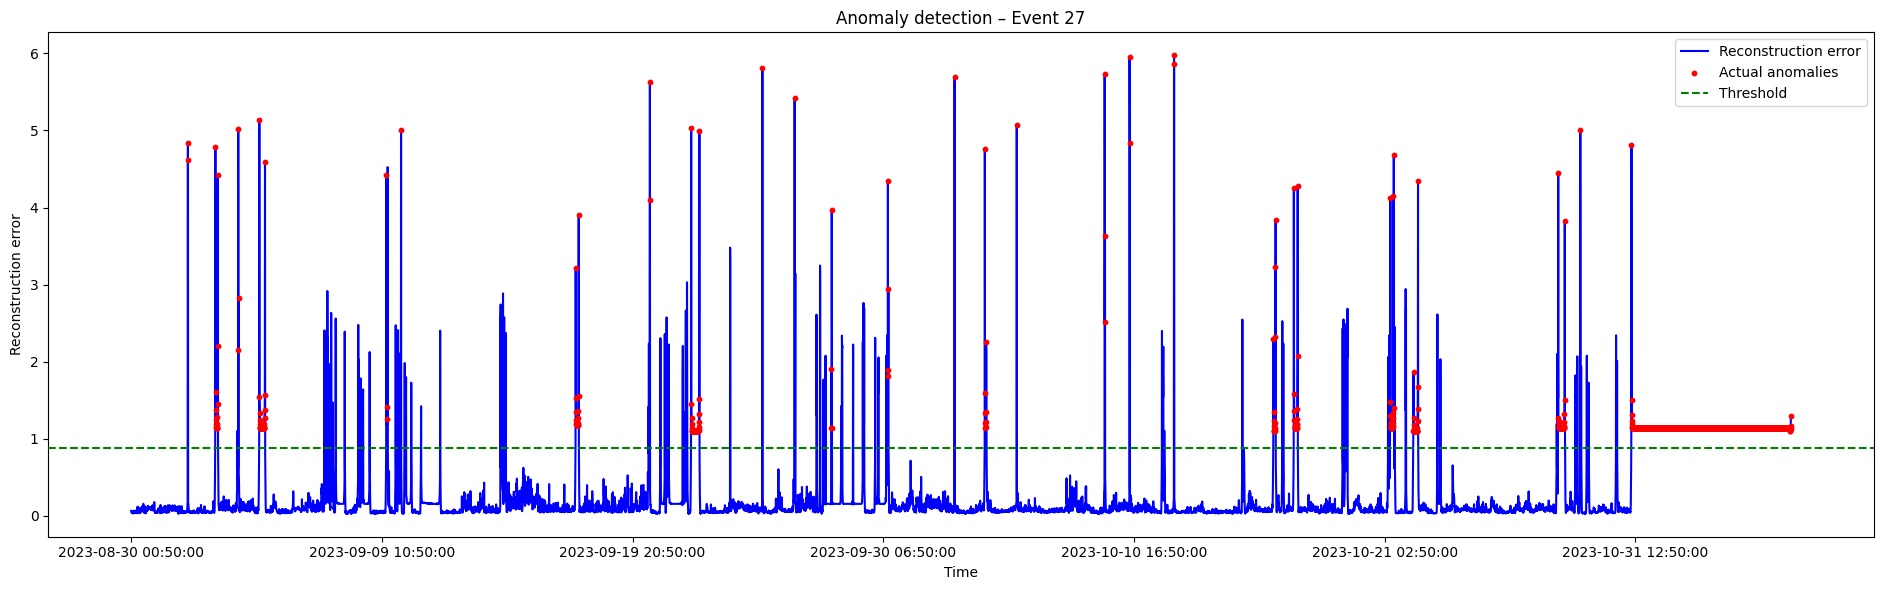

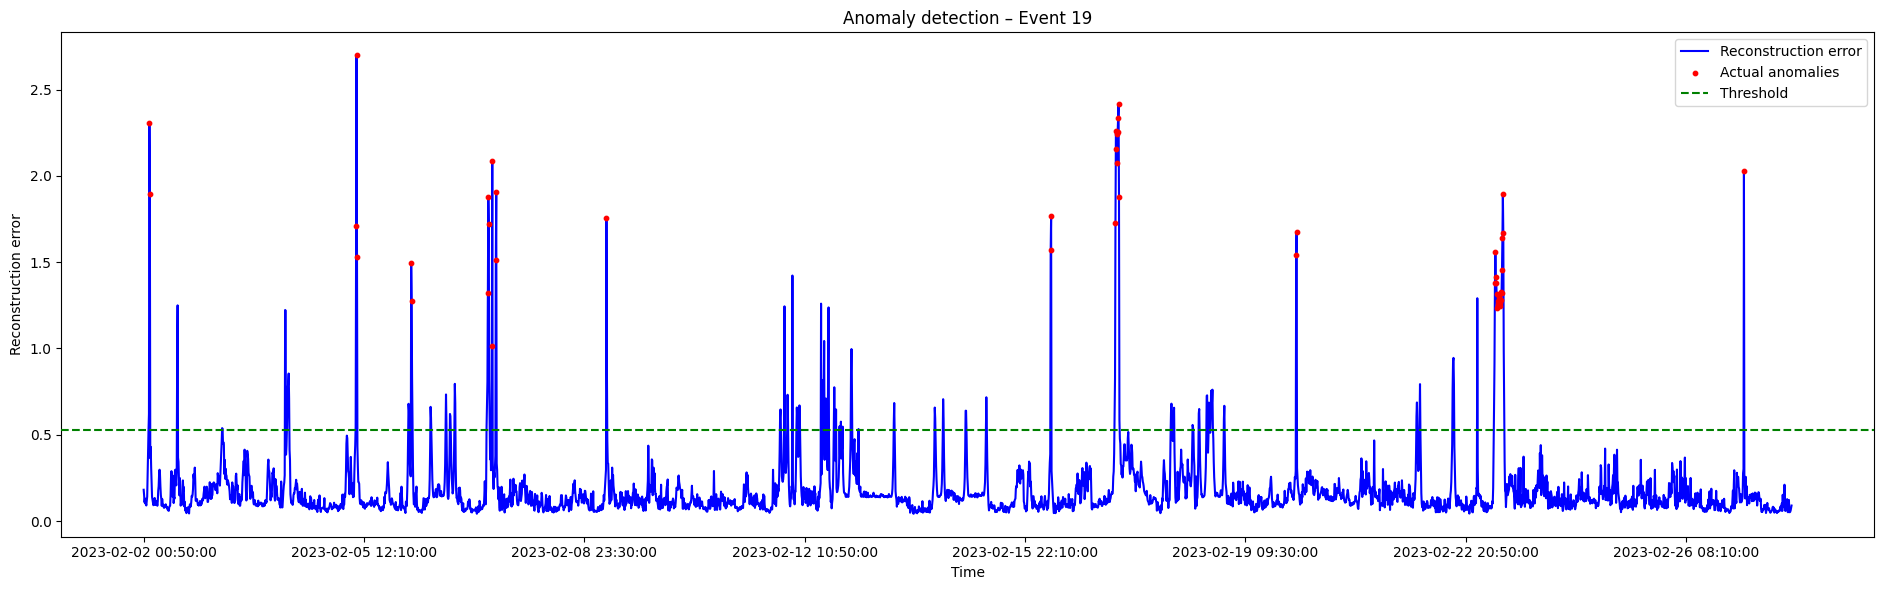

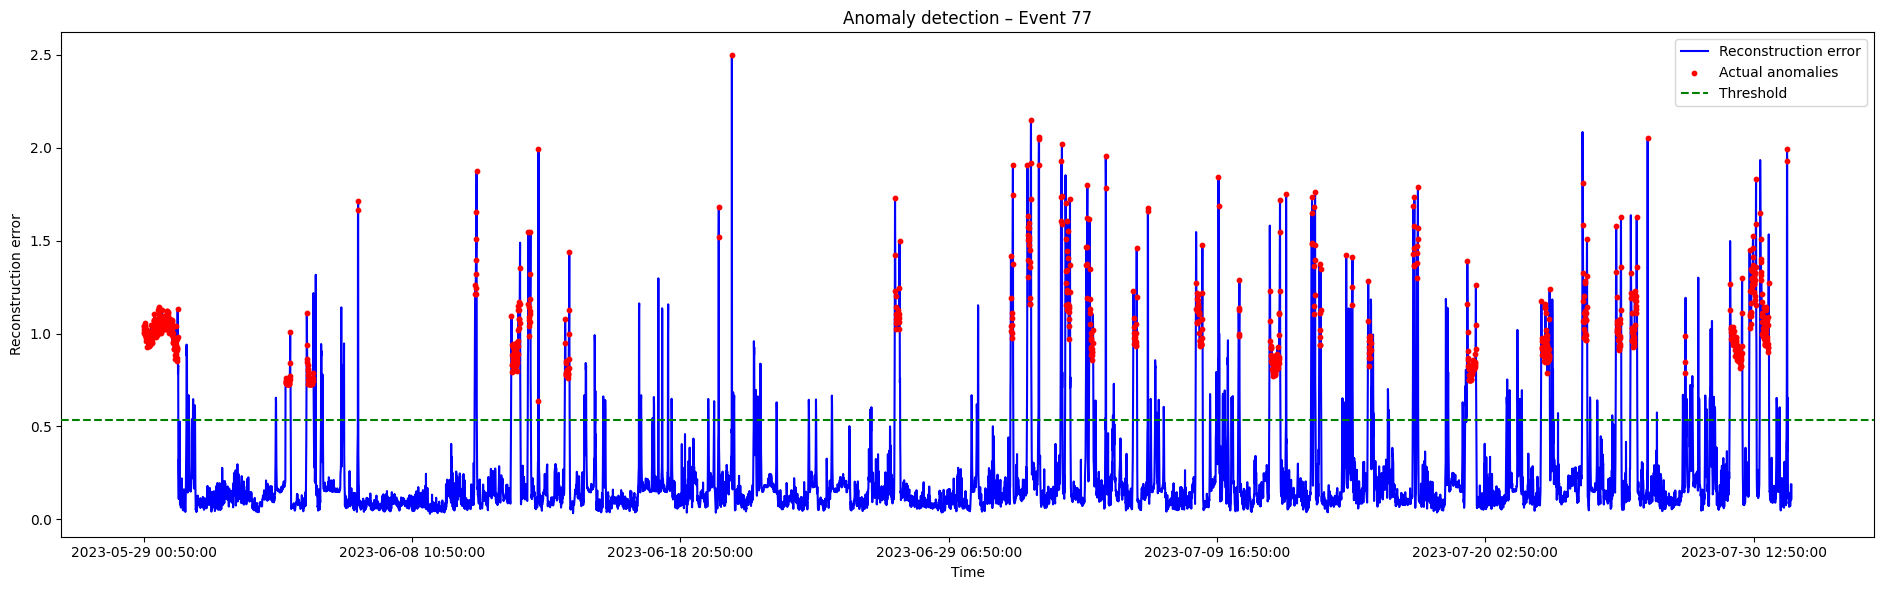

In [31]:
def create_sequences(data, timesteps):
    return np.array([data[i: i + timesteps] for i in range(len(data) - timesteps + 1)])


def create_sequences_with_indices(data, timesteps):
    sequences, index_map = [], []
    for i in range(len(data) - timesteps + 1):
        sequences.append(data[i: i + timesteps])
        index_map.append(list(range(i, i + timesteps)))
    return np.array(sequences), index_map


def safe_confusion_matrix(y_true, y_pred):
    labels = [0, 1]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if cm.shape == (1, 1):
        TN = cm[0, 0] if y_true[0] == 0 else 0
        FP = FN = TP = 0
    elif cm.shape == (1, 2):
        TN, FP = cm[0]
        FN = TP = 0
    elif cm.shape == (2, 1):
        TN = cm[0, 0]
        FN = cm[1, 0]
        FP = TP = 0
    else:
        TN, FP, FN, TP = cm.ravel()
    return TN, FP, FN, TP


datasets = {
    'Event 34': pd.read_csv('Wind Farm B/datasets/34.csv', sep=';'),
    'Event 7': pd.read_csv('Wind Farm B/datasets/7.csv', sep=';'),
    'Event 53': pd.read_csv('Wind Farm B/datasets/53.csv', sep=';'),
    'Event 27': pd.read_csv('Wind Farm B/datasets/27.csv', sep=';'),
    'Event 19': pd.read_csv('Wind Farm B/datasets/19.csv', sep=';'),
    'Event 77': pd.read_csv('Wind Farm B/datasets/77.csv', sep=';')
}

timesteps = 6
conf_matrices = {}
results = []
loss_curves = {}
histograms = {}
feature_errors_dict = {}
time_series_errors = {}

for event_name, df in datasets.items():
    print(f"\n{event_name}")

    df['label'] = df['status_type_id'].apply(lambda x: 0 if x in [0, 2] else 1)

    features = df.drop(columns=['train_test', 'status_type_id', 'asset_id', 'time_stamp', 'id'], errors='ignore')
    if 'label' not in features.columns:
        features['label'] = df['label']
    labels = features['label']
    features = features.drop(columns=['label'])

    selector = VarianceThreshold(threshold=0.2)
    selector.fit(features)
    features = features.loc[:, selector.get_support()]

    model = xgb.XGBClassifier(objective="binary:logistic")
    model.fit(features, labels)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(features)

    shap_importance = pd.DataFrame({
        'feature': features.columns,
        'mean_abs_shap': np.abs(shap_values).mean(axis=0)
    }).sort_values(by='mean_abs_shap', ascending=False)

    top_features = shap_importance.head(5)['feature'].values
    print("Selected features:", top_features)

    normal_train = df[(df['train_test'] == 'train') & (df['label'] == 0)]
    normal_train_filtered = normal_train[top_features]
    X_normal_train = normal_train_filtered

    scaler = StandardScaler()
    X_normal_train_scaled = scaler.fit_transform(X_normal_train)

    X_train_seq = create_sequences(X_normal_train_scaled, timesteps)
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], timesteps, X_normal_train_scaled.shape[1]))

    os.environ['PYTHONHASHSEED'] = '42'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

    input_shape = (timesteps, X_normal_train_scaled.shape[1])
    inputs = Input(shape=input_shape)
    encoded = Bidirectional(LSTM(10, activation='tanh', return_sequences=False))(inputs)
    encoded = Dropout(0.2)(encoded)
    bottleneck = RepeatVector(timesteps)(encoded)
    decoded = Bidirectional(LSTM(10, activation='tanh', return_sequences=True))(bottleneck)
    decoded = Dropout(0.2)(decoded)
    outputs = TimeDistributed(Dense(X_normal_train_scaled.shape[1], activation='linear'))(decoded)

    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer=Adam(0.0001), loss='mae')
    autoencoder.summary()

    history = autoencoder.fit(
        X_train_seq, X_train_seq,
        epochs=15, batch_size=256,
        validation_split=0.1, shuffle=True, verbose=1
    )

    loss_curves[event_name] = history.history

    reconstructed_train = autoencoder.predict(X_train_seq)
    row_errors = np.mean(np.abs(X_train_seq - reconstructed_train), axis=(1, 2))
    threshold = np.percentile(row_errors, 95)

    print(f"Reconstruction error threshold ({event_name}): {threshold:.6f}")

    histograms[event_name] = (row_errors, threshold)

    test = df[df['train_test'] == 'prediction']
    X_test = test[top_features]
    y_test = test['label'].values
    X_test_scaled = scaler.transform(X_test)

    X_test_seq, index_map = create_sequences_with_indices(X_test_scaled, timesteps)
    reconstructed_test = autoencoder.predict(X_test_seq)

    abs_errors = np.abs(reconstructed_test - X_test_seq)
    sample_errors = np.mean(abs_errors, axis=2)

    error_sum, error_count = defaultdict(float), defaultdict(int)
    for seq_idx, row_indices in enumerate(index_map):
        for t_idx, row_idx in enumerate(row_indices):
            error_sum[row_idx] += sample_errors[seq_idx, t_idx]
            error_count[row_idx] += 1

    row_errors_test = np.array([error_sum[i] / error_count[i] if error_count[i] > 0 else np.nan
                                for i in range(len(X_test_scaled))])
    predicted_labels = (row_errors_test > threshold).astype(int)

    valid_mask = ~np.isnan(row_errors_test)
    y_true, y_pred = y_test[valid_mask], predicted_labels[valid_mask]

    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred, zero_division=0) * 100
    rec = recall_score(y_true, y_pred, zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, zero_division=0) * 100
    TN, FP, FN, TP = safe_confusion_matrix(y_true, y_pred)
    far = (FP / (FP + TN) * 100) if (FP + TN) > 0 else 0

    results.append({
        'Event': event_name,
        'Accuracy': round(acc, 2),
        'Precision': round(prec, 2),
        'Recall': round(rec, 2),
        'F1': round(f1, 2),
        'FAR': round(far, 2)
    })

    conf_matrices[event_name] = np.array([[TN, FP], [FN, TP]])

    num_features = abs_errors.shape[2]
    num_samples = len(X_test_scaled)

    error_sum_per_feature = defaultdict(lambda: np.zeros(num_features))
    error_count_per_feature = defaultdict(int)

    for seq_idx, row_indices in enumerate(index_map):
        for t_idx, row_idx in enumerate(row_indices):
            error_sum_per_feature[row_idx] += abs_errors[seq_idx, t_idx]
            error_count_per_feature[row_idx] += 1

    feature_errors_per_sample = np.zeros((num_samples, num_features))
    for i in range(num_samples):
        if error_count_per_feature[i] > 0:
            feature_errors_per_sample[i] = error_sum_per_feature[i] / error_count_per_feature[i]
        else:
            feature_errors_per_sample[i] = np.nan

    feature_errors_valid = feature_errors_per_sample[valid_mask]
    y_true_valid = y_true
    y_pred_valid = y_pred

    normal_errors = feature_errors_valid[y_true_valid == 0]
    anomaly_errors = feature_errors_valid[y_true_valid == 1]

    avg_normal_errors = np.nanmean(normal_errors, axis=0)
    avg_anomaly_errors = np.nanmean(anomaly_errors, axis=0)

    feature_errors_dict[event_name] = (top_features, avg_normal_errors, avg_anomaly_errors)

    test_data = test[timesteps - 1:]
    timestamps = test_data['time_stamp'].values
    y_true_aligned = y_true[timesteps - 1:]
    y_pred_aligned = y_pred[timesteps - 1:]
    row_errors_aligned = row_errors_test[timesteps - 1:]

    time_series_errors[event_name] = (row_errors_aligned, threshold, y_true_aligned, y_pred_aligned, timestamps)


results_df = pd.DataFrame(results)
results_df.loc['Average'] = results_df.mean(numeric_only=True).round(2)

print("\nAnomaly detection results for all events: Bi-LSTM autoencoder (removing low-variance features) (%):\n")
print(results_df)

print()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for ax, (event_name, hist) in zip(axes, loss_curves.items()):
    ax.plot(hist['loss'], label='Training loss')
    ax.plot(hist['val_loss'], label='Validation loss')
    ax.set_title(event_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
fig.suptitle("Loss curves – all events", fontsize=16, y=1.02)
plt.show()

print()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for ax, (event_name, (errors, threshold)) in zip(axes, histograms.items()):
    ax.hist(errors, bins=50, color="blue", alpha=0.7)
    ax.axvline(x=threshold, color="green", linestyle="--", label="Threshold")
    ax.set_title(event_name)
    ax.set_xlabel("Reconstruction error")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.grid(True)
plt.tight_layout()
fig.suptitle("Training errors and threshold – all events", fontsize=16, y=1.02)
plt.show()

print()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
labels = [0, 1]
for ax, (event_name, cm) in zip(axes.flatten(), conf_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax, colorbar=False)
    ax.set_title(event_name)
plt.tight_layout()
fig.suptitle("Confusion matrix – all events", fontsize=16, y=1.02)
plt.show()

print()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for ax, (event_name, (top_features, avg_normal_errors, avg_anomaly_errors)) in zip(axes, feature_errors_dict.items()):
    x = np.arange(len(top_features))
    width = 0.35
    ax.bar(x - width/2, avg_normal_errors, width, label='Normal')
    ax.bar(x + width/2, avg_anomaly_errors, width, label='Anomaly')
    ax.set_xlabel('Features')
    ax.set_ylabel('Average reconstruction error')
    ax.set_xticks(x)
    ax.set_xticklabels(top_features, rotation=90)
    ax.legend()
    ax.set_title(event_name)
plt.tight_layout()
fig.suptitle("Average reconstruction error per feature – all events", fontsize=16, y=1.02)
plt.show()

print()

for event_name, (row_errors_aligned, threshold, y_true_aligned, y_pred_aligned, timestamps) in time_series_errors.items():
    plt.figure(figsize=(19, 6))

    anomalies = (y_true_aligned == 1)
    plt.plot(timestamps, row_errors_aligned, label="Reconstruction error", color="blue", zorder=2)
    plt.scatter(timestamps[anomalies], row_errors_aligned[anomalies],
                color="red", label="Actual anomalies", s=10, zorder=5)
    plt.axhline(y=threshold, color="green", linestyle="--", label="Threshold", zorder=3)

    plt.xlabel("Time")
    plt.ylabel("Reconstruction error")
    plt.title(f"Anomaly detection – {event_name}")
    plt.legend()
    plt.tight_layout()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

    plt.show()
    print()
